## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


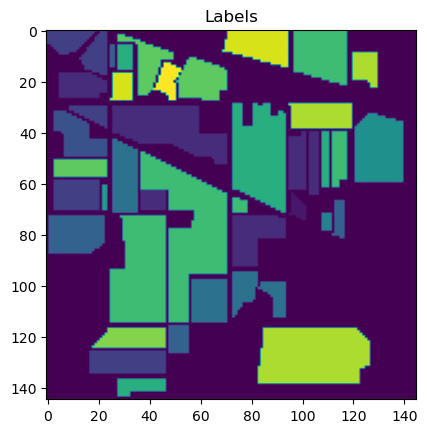

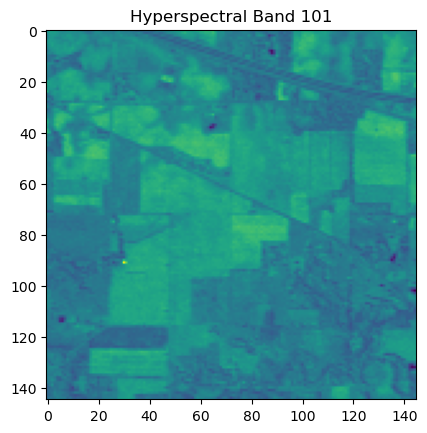

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(608, 5, 5, 200)
(70, 5, 5, 200)
(9571, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0791, PSNR: 10.1333


Epoch [1/50] Training Loss: 0.0645, PSNR: 11.5068
	[Val]   Batch [1/33] Loss: 0.0487, PSNR: 12.7916
	[Val]   Batch [10/33] Loss: 0.0481, PSNR: 12.4444
	[Val]   Batch [20/33] Loss: 0.0477, PSNR: 12.0408
	[Val]   Batch [30/33] Loss: 0.0464, PSNR: 12.4142
Epoch [1/50] Validation Loss: 0.0484, PSNR: 12.6069

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0484, PSNR: 12.6686


Epoch [2/50] Training Loss: 0.0391, PSNR: 13.6750
	[Val]   Batch [1/33] Loss: 0.0287, PSNR: 15.0833
	[Val]   Batch [10/33] Loss: 0.0282, PSNR: 14.7675
	[Val]   Batch [20/33] Loss: 0.0279, PSNR: 14.3793
	[Val]   Batch [30/33] Loss: 0.0271, PSNR: 14.7390
Epoch [2/50] Validation Loss: 0.0286, PSNR: 14.8994

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0285, PSNR: 14.9202


Epoch [3/50] Training Loss: 0.0230, PSNR: 15.9545
	[Val]   Batch [1/33] Loss: 0.0178, PSNR: 17.1511
	[Val]   Batch [10/33] Loss: 0.0173, PSNR: 16.8738
	[Val]   Batch [20/33] Loss: 0.0171, PSNR: 16.5126
	[Val]   Batch [30/33] Loss: 0.0166, PSNR: 16.8849
Epoch [3/50] Validation Loss: 0.0177, PSNR: 16.9686

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0174, PSNR: 17.5886


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0415
	[Val]   Batch [1/33] Loss: 0.0118, PSNR: 18.9535
	[Val]   Batch [10/33] Loss: 0.0113, PSNR: 18.7297
	[Val]   Batch [20/33] Loss: 0.0110, PSNR: 18.4065
	[Val]   Batch [30/33] Loss: 0.0106, PSNR: 18.8051
Epoch [4/50] Validation Loss: 0.0117, PSNR: 18.7773

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0106, PSNR: 19.2747


Epoch [5/50] Training Loss: 0.0096, PSNR: 19.7419
	[Val]   Batch [1/33] Loss: 0.0084, PSNR: 20.4415
	[Val]   Batch [10/33] Loss: 0.0079, PSNR: 20.2796
	[Val]   Batch [20/33] Loss: 0.0076, PSNR: 19.9939
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.3986
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2645

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0098, PSNR: 19.7440


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0248
	[Val]   Batch [1/33] Loss: 0.0065, PSNR: 21.5641
	[Val]   Batch [10/33] Loss: 0.0060, PSNR: 21.4712
	[Val]   Batch [20/33] Loss: 0.0058, PSNR: 21.2262
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6411
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.3941

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0060, PSNR: 21.9123


Epoch [7/50] Training Loss: 0.0057, PSNR: 22.0405
	[Val]   Batch [1/33] Loss: 0.0053, PSNR: 22.4212
	[Val]   Batch [10/33] Loss: 0.0049, PSNR: 22.3898
	[Val]   Batch [20/33] Loss: 0.0046, PSNR: 22.1756
	[Val]   Batch [30/33] Loss: 0.0045, PSNR: 22.5893
Epoch [7/50] Validation Loss: 0.0053, PSNR: 22.2546

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0046, PSNR: 22.9160


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8703
	[Val]   Batch [1/33] Loss: 0.0043, PSNR: 23.2904
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.3634
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1899
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.6201
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.1587

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0050, PSNR: 22.2101


Epoch [9/50] Training Loss: 0.0039, PSNR: 23.6035
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9478
	[Val]   Batch [10/33] Loss: 0.0033, PSNR: 24.1111
	[Val]   Batch [20/33] Loss: 0.0031, PSNR: 23.9662
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.4055
Epoch [9/50] Validation Loss: 0.0037, PSNR: 23.8513

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0041, PSNR: 23.6276


Epoch [10/50] Training Loss: 0.0034, PSNR: 24.2612
	[Val]   Batch [1/33] Loss: 0.0032, PSNR: 24.6331
	[Val]   Batch [10/33] Loss: 0.0027, PSNR: 24.9151
	[Val]   Batch [20/33] Loss: 0.0025, PSNR: 24.8118
	[Val]   Batch [30/33] Loss: 0.0024, PSNR: 25.3016
Epoch [10/50] Validation Loss: 0.0031, PSNR: 24.5997

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0028, PSNR: 25.0367


Epoch [11/50] Training Loss: 0.0029, PSNR: 24.8809
	[Val]   Batch [1/33] Loss: 0.0028, PSNR: 25.1857
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.5599
	[Val]   Batch [20/33] Loss: 0.0022, PSNR: 25.4901
	[Val]   Batch [30/33] Loss: 0.0020, PSNR: 25.9905
Epoch [11/50] Validation Loss: 0.0027, PSNR: 25.2004

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.5335


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.4183
	[Val]   Batch [1/33] Loss: 0.0025, PSNR: 25.6496
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 26.0928
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 26.0497
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.6038
Epoch [12/50] Validation Loss: 0.0024, PSNR: 25.7106

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 24.6268


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.8460
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.0191
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.4885
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.4798
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 27.0702
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.0955

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0025, PSNR: 25.1031


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1907
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.4189
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.8749
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.8958
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.4768
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4922

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.8545


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.5964
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0739
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5265
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5780
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.1719
Epoch [15/50] Validation Loss: 0.0017, PSNR: 27.1355

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.6498


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9737
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4884
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.9159
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.9715
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.5105
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.5243

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 26.9999


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2709
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.9394
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.3376
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.4110
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9545
Epoch [17/50] Validation Loss: 0.0014, PSNR: 27.9676

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.9973


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6597
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.3108
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6164
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7016
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3094
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3020

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.3669


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9730
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.8742
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1661
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2712
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.8860
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.8594

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.6399


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2882
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.1488
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.4296
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.5692
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2173
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.1343

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.6665


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.5459
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.4114
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.5975
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7282
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.4002
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.3532

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.2322


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7339
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8863
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0773
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2805
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9247
Epoch [22/50] Validation Loss: 0.0009, PSNR: 29.8588

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6111


Epoch [23/50] Training Loss: 0.0011, PSNR: 28.9771
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 29.9405
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1395
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3118
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9129
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.9099

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.4677


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1577
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3236
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.5104
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7677
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4701
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.3420

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2856


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.3538
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3218
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4830
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7319
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4917
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3646

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2783


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4597
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5722
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7266
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9804
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7098
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5926

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.1820


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.6368
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.7358
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9101
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1737
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9215
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.7680

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9904


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.7238
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8518
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.0062
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2787
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0458
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.8964
Early stopping triggered at epoch 28. No improvement for 3 epochs.


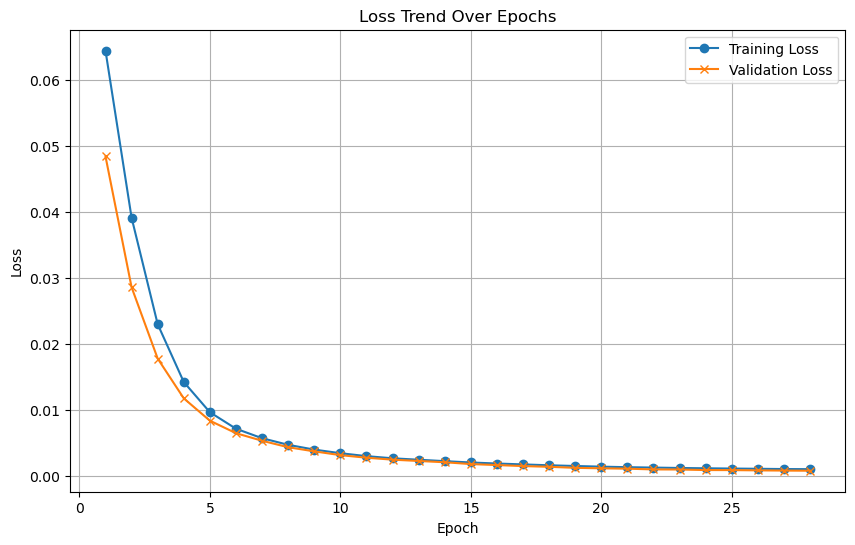

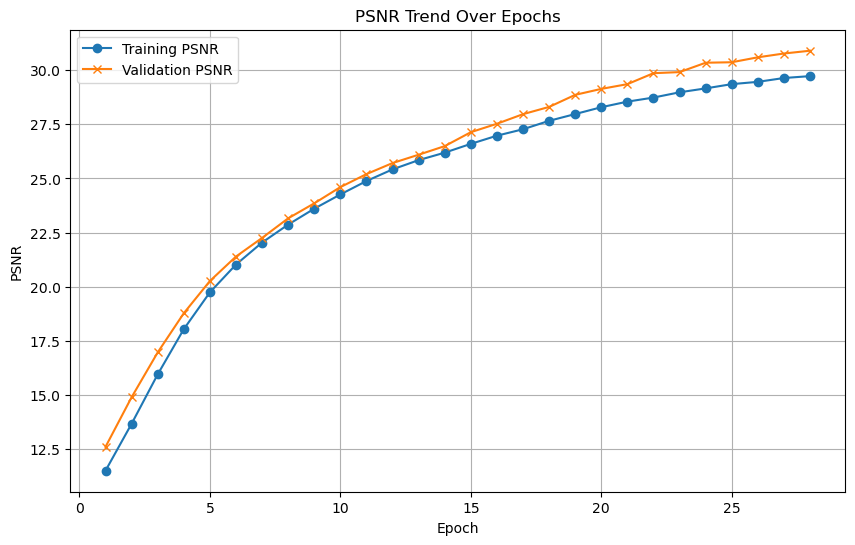

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/38 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8013
    Validation Batch [1/1], Loss: 2.7988
Validation Loss: 2.7988, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.7988. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7720
    Validation Batch [1/1], Loss: 2.7991
Validation Loss: 2.7991, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7571
    Validation Batch [1/1], Loss: 2.7995
Validation Loss: 2.7995, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7415
    Validation Batch [1/1], Loss: 2.7998
Validation Loss: 2.7998, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [8/1000] completed, Average Training Loss: 2.7097
    Validation Batch [1/1], Loss: 2.8005
Validation Loss: 2.8005, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.7157
    Validation Batch [1/1], Loss: 2.8006
Validation Loss: 2.8006, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6959
    Validation Batch [1/1], Loss: 2.8007
Validation Loss: 2.8007, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6937
    Validation Batch [1/1], Loss: 2.8006
Validation Loss: 2.8006, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6847
    Validation Ba

Epoch [15/1000] completed, Average Training Loss: 2.6605
    Validation Batch [1/1], Loss: 2.8002
Validation Loss: 2.8002, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.6605
    Validation Batch [1/1], Loss: 2.8001
Validation Loss: 2.8001, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.6483
    Validation Batch [1/1], Loss: 2.8001
Validation Loss: 2.8001, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.6335
    Validation Batch [1/1], Loss: 2.8001
Validation Loss: 2.8001, Validation Accuracy: 0.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.6358
    Validat

Epoch [31/1000] completed, Average Training Loss: 2.5453
    Validation Batch [1/1], Loss: 2.7951
Validation Loss: 2.7951, Validation Accuracy: 0.00%
Validation loss improved from 2.7963 to 2.7951. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.5460
    Validation Batch [1/1], Loss: 2.7931
Validation Loss: 2.7931, Validation Accuracy: 4.29%
Validation loss improved from 2.7951 to 2.7931. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.5411
    Validation Batch [1/1], Loss: 2.7904
Validation Loss: 2.7904, Validation Accuracy: 7.14%
Validation loss improved from 2.7931 to 2.7904. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.5473
    Validation Batch [1/1], Loss: 2.7871
Validation Loss: 2.7871, Validation Accuracy: 7.14%
Validation loss improved from 2.7904 to 2.7871. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/10

Epoch [38/1000] completed, Average Training Loss: 2.5058
    Validation Batch [1/1], Loss: 2.7737
Validation Loss: 2.7737, Validation Accuracy: 7.14%
Validation loss improved from 2.7786 to 2.7737. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.4910
    Validation Batch [1/1], Loss: 2.7680
Validation Loss: 2.7680, Validation Accuracy: 2.86%
Validation loss improved from 2.7737 to 2.7680. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.4777
    Validation Batch [1/1], Loss: 2.7627
Validation Loss: 2.7627, Validation Accuracy: 2.86%
Validation loss improved from 2.7680 to 2.7627. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.4791
    Validation Batch [1/1], Loss: 2.7577
Validation Loss: 2.7577, Validation Accuracy: 4.29%
Validation loss improved from 2.7627 to 2.7577. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/10

    Validation Batch [1/1], Loss: 2.6071
Validation Loss: 2.6071, Validation Accuracy: 27.14%
Validation loss improved from 2.6212 to 2.6071. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.3727
    Validation Batch [1/1], Loss: 2.5907
Validation Loss: 2.5907, Validation Accuracy: 27.14%
Validation loss improved from 2.6071 to 2.5907. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.3751
    Validation Batch [1/1], Loss: 2.5758
Validation Loss: 2.5758, Validation Accuracy: 27.14%
Validation loss improved from 2.5907 to 2.5758. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.3723
    Validation Batch [1/1], Loss: 2.5604
Validation Loss: 2.5604, Validation Accuracy: 30.00%
Validation loss improved from 2.5758 to 2.5604. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.3543
    Vali

Epoch [60/1000] completed, Average Training Loss: 2.3301
    Validation Batch [1/1], Loss: 2.5261
Validation Loss: 2.5261, Validation Accuracy: 30.00%
Validation loss improved from 2.5328 to 2.5261. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.3158
    Validation Batch [1/1], Loss: 2.5101
Validation Loss: 2.5101, Validation Accuracy: 31.43%
Validation loss improved from 2.5261 to 2.5101. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.3182
    Validation Batch [1/1], Loss: 2.4977
Validation Loss: 2.4977, Validation Accuracy: 35.71%
Validation loss improved from 2.5101 to 2.4977. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.3169
    Validation Batch [1/1], Loss: 2.4826
Validation Loss: 2.4826, Validation Accuracy: 35.71%
Validation loss improved from 2.4977 to 2.4826. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.3387
Validation Loss: 2.3387, Validation Accuracy: 37.14%
Validation loss improved from 2.3448 to 2.3387. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.1935
    Validation Batch [1/1], Loss: 2.3337
Validation Loss: 2.3337, Validation Accuracy: 37.14%
Validation loss improved from 2.3387 to 2.3337. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.2072
    Validation Batch [1/1], Loss: 2.3365
Validation Loss: 2.3365, Validation Accuracy: 42.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.2009
    Validation Batch [1/1], Loss: 2.3152
Validation Loss: 2.3152, Validation Accuracy: 45.71%
Validation loss improved from 2.3337 to 2.3152. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.1921
    Validation Batch [1

Epoch [83/1000] completed, Average Training Loss: 2.1570
    Validation Batch [1/1], Loss: 2.2050
Validation Loss: 2.2050, Validation Accuracy: 44.29%
Validation loss improved from 2.2105 to 2.2050. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.1485
    Validation Batch [1/1], Loss: 2.1955
Validation Loss: 2.1955, Validation Accuracy: 44.29%
Validation loss improved from 2.2050 to 2.1955. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 2.1395
    Validation Batch [1/1], Loss: 2.1731
Validation Loss: 2.1731, Validation Accuracy: 41.43%
Validation loss improved from 2.1955 to 2.1731. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.1226
    Validation Batch [1/1], Loss: 2.1544
Validation Loss: 2.1544, Validation Accuracy: 44.29%
Validation loss improved from 2.1731 to 2.1544. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [8

Epoch [97/1000] completed, Average Training Loss: 2.0299
    Validation Batch [1/1], Loss: 2.0824
Validation Loss: 2.0824, Validation Accuracy: 55.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 2.0309
    Validation Batch [1/1], Loss: 2.0982
Validation Loss: 2.0982, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 2.0174
    Validation Batch [1/1], Loss: 2.0842
Validation Loss: 2.0842, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.9821
    Validation Batch [1/1], Loss: 2.0682
Validation Loss: 2.0682, Validation Accuracy: 51.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.9980
    Val

Epoch [106/1000] completed, Average Training Loss: 1.9582
    Validation Batch [1/1], Loss: 2.0876
Validation Loss: 2.0876, Validation Accuracy: 51.43%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.9597
    Validation Batch [1/1], Loss: 2.0718
Validation Loss: 2.0718, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.9587
    Validation Batch [1/1], Loss: 2.0305
Validation Loss: 2.0305, Validation Accuracy: 51.43%
Validation loss improved from 2.0573 to 2.0305. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.9351
    Validation Batch [1/1], Loss: 2.0353
Validation Loss: 2.0353, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 1.9145
Validation Loss: 1.9145, Validation Accuracy: 54.29%
Validation loss improved from 1.9238 to 1.9145. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.8218
    Validation Batch [1/1], Loss: 1.9439
Validation Loss: 1.9439, Validation Accuracy: 57.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.8298
    Validation Batch [1/1], Loss: 1.9680
Validation Loss: 1.9680, Validation Accuracy: 55.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.8209
    Validation Batch [1/1], Loss: 1.9486
Validation Loss: 1.9486, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.8202
    Validation Batch [1/1], Loss: 1.9312
Vali

Epoch [130/1000] completed, Average Training Loss: 1.7216
    Validation Batch [1/1], Loss: 1.8943
Validation Loss: 1.8943, Validation Accuracy: 51.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.7377
    Validation Batch [1/1], Loss: 1.8621
Validation Loss: 1.8621, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.7167
    Validation Batch [1/1], Loss: 1.8224
Validation Loss: 1.8224, Validation Accuracy: 58.57%
Validation loss improved from 1.8319 to 1.8224. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.7169
    Validation Batch [1/1], Loss: 1.8036
Validation Loss: 1.8036, Validation Accuracy: 58.57%
Validation loss improved from 1.8224 to 1.8036. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Av

Epoch [139/1000] completed, Average Training Loss: 1.6674
    Validation Batch [1/1], Loss: 1.7411
Validation Loss: 1.7411, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.6729
    Validation Batch [1/1], Loss: 1.7388
Validation Loss: 1.7388, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.6403
    Validation Batch [1/1], Loss: 1.7556
Validation Loss: 1.7556, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.6240
    Validation Batch [1/1], Loss: 1.8132
Validation Loss: 1.8132, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.6199
  

Epoch [155/1000] completed, Average Training Loss: 1.5204
    Validation Batch [1/1], Loss: 1.6396
Validation Loss: 1.6396, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.4864
    Validation Batch [1/1], Loss: 1.6305
Validation Loss: 1.6305, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.4753
    Validation Batch [1/1], Loss: 1.6288
Validation Loss: 1.6288, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.4983
    Validation Batch [1/1], Loss: 1.6089
Validation Loss: 1.6089, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.4673
  

    Validation Batch [1/1], Loss: 1.5462
Validation Loss: 1.5462, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.4461
    Validation Batch [1/1], Loss: 1.5275
Validation Loss: 1.5275, Validation Accuracy: 65.71%
Validation loss improved from 1.5331 to 1.5275. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.4555
    Validation Batch [1/1], Loss: 1.5147
Validation Loss: 1.5147, Validation Accuracy: 68.57%
Validation loss improved from 1.5275 to 1.5147. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.4237
    Validation Batch [1/1], Loss: 1.5046
Validation Loss: 1.5046, Validation Accuracy: 65.71%
Validation loss improved from 1.5147 to 1.5046. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.3836
    Validation 

Epoch [178/1000] completed, Average Training Loss: 1.2886
    Validation Batch [1/1], Loss: 1.4521
Validation Loss: 1.4521, Validation Accuracy: 57.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.2681
    Validation Batch [1/1], Loss: 1.4336
Validation Loss: 1.4336, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.2795
    Validation Batch [1/1], Loss: 1.4013
Validation Loss: 1.4013, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.2503
    Validation Batch [1/1], Loss: 1.4211
Validation Loss: 1.4211, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.2450
  

    Validation Batch [1/1], Loss: 1.4024
Validation Loss: 1.4024, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.2320
    Validation Batch [1/1], Loss: 1.3395
Validation Loss: 1.3395, Validation Accuracy: 82.86%
Validation loss improved from 1.3896 to 1.3395. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.1985
    Validation Batch [1/1], Loss: 1.2954
Validation Loss: 1.2954, Validation Accuracy: 82.86%
Validation loss improved from 1.3395 to 1.2954. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.2021
    Validation Batch [1/1], Loss: 1.3538
Validation Loss: 1.3538, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 1.1960
    Validation Batch [1/1], Lo

Epoch [199/1000] completed, Average Training Loss: 1.0680
    Validation Batch [1/1], Loss: 1.3168
Validation Loss: 1.3168, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 1.0784
    Validation Batch [1/1], Loss: 1.2911
Validation Loss: 1.2911, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.0776
    Validation Batch [1/1], Loss: 1.2011
Validation Loss: 1.2011, Validation Accuracy: 81.43%
Validation loss improved from 1.2448 to 1.2011. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.0957
    Validation Batch [1/1], Loss: 1.2373
Validation Loss: 1.2373, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training 

Epoch [209/1000] completed, Average Training Loss: 1.0203
    Validation Batch [1/1], Loss: 1.2746
Validation Loss: 1.2746, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.9743
    Validation Batch [1/1], Loss: 1.3655
Validation Loss: 1.3655, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0158
    Validation Batch [1/1], Loss: 1.2606
Validation Loss: 1.2606, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.9879
    Validation Batch [1/1], Loss: 1.3523
Validation Loss: 1.3523, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.9849
  

    Validation Batch [1/1], Loss: 1.1010
Validation Loss: 1.1010, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.8675
    Validation Batch [1/1], Loss: 1.1247
Validation Loss: 1.1247, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.8724
    Validation Batch [1/1], Loss: 1.1722
Validation Loss: 1.1722, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.8924
    Validation Batch [1/1], Loss: 1.1241
Validation Loss: 1.1241, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.9128
    Validation Batch [1/1], Loss: 1.0584
Validation Loss: 1.

Epoch [233/1000] completed, Average Training Loss: 0.8350
    Validation Batch [1/1], Loss: 1.1905
Validation Loss: 1.1905, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.8464
    Validation Batch [1/1], Loss: 1.2872
Validation Loss: 1.2872, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7876
    Validation Batch [1/1], Loss: 1.1143
Validation Loss: 1.1143, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.8061
    Validation Batch [1/1], Loss: 0.9923
Validation Loss: 0.9923, Validation Accuracy: 84.29%
Validation loss improved from 1.0079 to 0.9923. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training 

Epoch [245/1000] completed, Average Training Loss: 0.7221
    Validation Batch [1/1], Loss: 1.1895
Validation Loss: 1.1895, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.7285
    Validation Batch [1/1], Loss: 0.9964
Validation Loss: 0.9964, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.7024
    Validation Batch [1/1], Loss: 0.9937
Validation Loss: 0.9937, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.7554
    Validation Batch [1/1], Loss: 1.1721
Validation Loss: 1.1721, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.7325
  

Epoch [256/1000] completed, Average Training Loss: 0.6816
    Validation Batch [1/1], Loss: 1.1495
Validation Loss: 1.1495, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.6548
    Validation Batch [1/1], Loss: 0.9277
Validation Loss: 0.9277, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.6772
    Validation Batch [1/1], Loss: 1.0218
Validation Loss: 1.0218, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.6678
    Validation Batch [1/1], Loss: 1.1117
Validation Loss: 1.1117, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6602
  

Epoch [269/1000] completed, Average Training Loss: 0.5827
    Validation Batch [1/1], Loss: 0.9709
Validation Loss: 0.9709, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.5950
    Validation Batch [1/1], Loss: 0.8647
Validation Loss: 0.8647, Validation Accuracy: 87.14%
Validation loss improved from 0.8813 to 0.8647. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.6096
    Validation Batch [1/1], Loss: 0.8806
Validation Loss: 0.8806, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.5973
    Validation Batch [1/1], Loss: 0.9032
Validation Loss: 0.9032, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training 

Epoch [278/1000] completed, Average Training Loss: 0.5359
    Validation Batch [1/1], Loss: 1.0521
Validation Loss: 1.0521, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.5800
    Validation Batch [1/1], Loss: 0.8610
Validation Loss: 0.8610, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5391
    Validation Batch [1/1], Loss: 0.8146
Validation Loss: 0.8146, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.5388
    Validation Batch [1/1], Loss: 0.8999
Validation Loss: 0.8999, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.5855
  

Epoch [292/1000] completed, Average Training Loss: 0.5049
    Validation Batch [1/1], Loss: 0.6931
Validation Loss: 0.6931, Validation Accuracy: 88.57%
Validation loss improved from 0.6943 to 0.6931. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4727
    Validation Batch [1/1], Loss: 0.7657
Validation Loss: 0.7657, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.4999
    Validation Batch [1/1], Loss: 0.6989
Validation Loss: 0.6989, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.4647
    Validation Batch [1/1], Loss: 1.0816
Validation Loss: 1.0816, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training 

Epoch [302/1000] completed, Average Training Loss: 0.4961
    Validation Batch [1/1], Loss: 1.0869
Validation Loss: 1.0869, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4401
    Validation Batch [1/1], Loss: 0.6906
Validation Loss: 0.6906, Validation Accuracy: 88.57%
Validation loss improved from 0.6931 to 0.6906. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.4611
    Validation Batch [1/1], Loss: 0.7758
Validation Loss: 0.7758, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4855
    Validation Batch [1/1], Loss: 0.6871
Validation Loss: 0.6871, Validation Accuracy: 85.71%
Validation loss improved from 0.6906 to 0.6871. Saving model...

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, A

Epoch [307/1000] completed, Average Training Loss: 0.4432
    Validation Batch [1/1], Loss: 0.7497
Validation Loss: 0.7497, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.4478
    Validation Batch [1/1], Loss: 0.7828
Validation Loss: 0.7828, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.4450
    Validation Batch [1/1], Loss: 0.6902
Validation Loss: 0.6902, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.4317
    Validation Batch [1/1], Loss: 1.0688
Validation Loss: 1.0688, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.4017
  

Epoch [313/1000] completed, Average Training Loss: 0.3991
    Validation Batch [1/1], Loss: 0.6943
Validation Loss: 0.6943, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.4204
    Validation Batch [1/1], Loss: 0.6479
Validation Loss: 0.6479, Validation Accuracy: 90.00%
Validation loss improved from 0.6785 to 0.6479. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.4028
    Validation Batch [1/1], Loss: 0.6840
Validation Loss: 0.6840, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.4135
    Validation Batch [1/1], Loss: 0.7959
Validation Loss: 0.7959, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training 

Epoch [330/1000] completed, Average Training Loss: 0.3935
    Validation Batch [1/1], Loss: 0.6836
Validation Loss: 0.6836, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3845
    Validation Batch [1/1], Loss: 0.8196
Validation Loss: 0.8196, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3434
    Validation Batch [1/1], Loss: 0.8958
Validation Loss: 0.8958, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3426
    Validation Batch [1/1], Loss: 0.6515
Validation Loss: 0.6515, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.355

    Validation Batch [1/1], Loss: 0.6635
Validation Loss: 0.6635, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3414
    Validation Batch [1/1], Loss: 0.5774
Validation Loss: 0.5774, Validation Accuracy: 87.14%
Validation loss improved from 0.6035 to 0.5774. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.3379
    Validation Batch [1/1], Loss: 0.6208
Validation Loss: 0.6208, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3241
    Validation Batch [1/1], Loss: 0.7145
Validation Loss: 0.7145, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.3260
    Validation Batch [1/1], Loss: 0.5998
Val

Epoch [352/1000] completed, Average Training Loss: 0.2985
    Validation Batch [1/1], Loss: 0.6201
Validation Loss: 0.6201, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2997
    Validation Batch [1/1], Loss: 0.5669
Validation Loss: 0.5669, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.3087
    Validation Batch [1/1], Loss: 0.6723
Validation Loss: 0.6723, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2983
    Validation Batch [1/1], Loss: 0.7439
Validation Loss: 0.7439, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2757
  

Epoch [359/1000] completed, Average Training Loss: 0.2738
    Validation Batch [1/1], Loss: 0.8504
Validation Loss: 0.8504, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.2868
    Validation Batch [1/1], Loss: 0.7261
Validation Loss: 0.7261, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.2840
    Validation Batch [1/1], Loss: 0.6863
Validation Loss: 0.6863, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2899
    Validation Batch [1/1], Loss: 0.5979
Validation Loss: 0.5979, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2780

Epoch [375/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 0.6089
Validation Loss: 0.6089, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2330
    Validation Batch [1/1], Loss: 0.5061
Validation Loss: 0.5061, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2730
    Validation Batch [1/1], Loss: 0.5048
Validation Loss: 0.5048, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2556
    Validation Batch [1/1], Loss: 0.7498
Validation Loss: 0.7498, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2534
  

Epoch [380/1000] completed, Average Training Loss: 0.2519
    Validation Batch [1/1], Loss: 0.4857
Validation Loss: 0.4857, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2469
    Validation Batch [1/1], Loss: 0.7990
Validation Loss: 0.7990, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2663
    Validation Batch [1/1], Loss: 0.8157
Validation Loss: 0.8157, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2162
    Validation Batch [1/1], Loss: 0.5332
Validation Loss: 0.5332, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.260

    Validation Batch [1/1], Loss: 0.8815
Validation Loss: 0.8815, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.2210
    Validation Batch [1/1], Loss: 1.1573
Validation Loss: 1.1573, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2158
    Validation Batch [1/1], Loss: 0.4683
Validation Loss: 0.4683, Validation Accuracy: 88.57%
Validation loss improved from 0.4825 to 0.4683. Saving model...

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.2087
    Validation Batch [1/1], Loss: 0.6283
Validation Loss: 0.6283, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.2009
    Validation Batch [1/1], Loss: 0.7537
Va

    Validation Batch [1/1], Loss: 0.7297
Validation Loss: 0.7297, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1981
    Validation Batch [1/1], Loss: 0.8181
Validation Loss: 0.8181, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.2161
    Validation Batch [1/1], Loss: 0.4276
Validation Loss: 0.4276, Validation Accuracy: 88.57%
Validation loss improved from 0.4683 to 0.4276. Saving model...

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1970
    Validation Batch [1/1], Loss: 0.6036
Validation Loss: 0.6036, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.2209
    Validation Batch [1/1], Loss: 0.6027
Vali

Epoch [422/1000] completed, Average Training Loss: 0.2014
    Validation Batch [1/1], Loss: 0.4677
Validation Loss: 0.4677, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1944
    Validation Batch [1/1], Loss: 0.5738
Validation Loss: 0.5738, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1852
    Validation Batch [1/1], Loss: 0.6592
Validation Loss: 0.6592, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1980
    Validation Batch [1/1], Loss: 0.7057
Validation Loss: 0.7057, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [426/1000] - Training


Epoch [426/1000] completed, Average Training Loss: 0.1715
    Validation Batch [1/1], Loss: 0.4527
Validation Loss: 0.4527, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1957
    Validation Batch [1/1], Loss: 0.6372
Validation Loss: 0.6372, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1874
    Validation Batch [1/1], Loss: 0.6576
Validation Loss: 0.6576, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1855
    Validation Batch [1/1], Loss: 0.6896
Validation Loss: 0.6896, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1690
  

Epoch [444/1000] completed, Average Training Loss: 0.1572
    Validation Batch [1/1], Loss: 0.4319
Validation Loss: 0.4319, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1486
    Validation Batch [1/1], Loss: 0.5346
Validation Loss: 0.5346, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1439
    Validation Batch [1/1], Loss: 0.4028
Validation Loss: 0.4028, Validation Accuracy: 87.14%
Validation loss improved from 0.4058 to 0.4028. Saving model...

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1341
    Validation Batch [1/1], Loss: 0.4538
Validation Loss: 0.4538, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training 

Epoch [449/1000] completed, Average Training Loss: 0.1423
    Validation Batch [1/1], Loss: 0.3982
Validation Loss: 0.3982, Validation Accuracy: 88.57%
Validation loss improved from 0.4028 to 0.3982. Saving model...

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1545
    Validation Batch [1/1], Loss: 0.4589
Validation Loss: 0.4589, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1425
    Validation Batch [1/1], Loss: 0.4544
Validation Loss: 0.4544, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1707
    Validation Batch [1/1], Loss: 0.4748
Validation Loss: 0.4748, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training 

Epoch [467/1000] completed, Average Training Loss: 0.1342
    Validation Batch [1/1], Loss: 0.6254
Validation Loss: 0.6254, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1337
    Validation Batch [1/1], Loss: 0.5520
Validation Loss: 0.5520, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1301
    Validation Batch [1/1], Loss: 0.5077
Validation Loss: 0.5077, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1257
    Validation Batch [1/1], Loss: 0.4715
Validation Loss: 0.4715, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.136

Epoch [472/1000] completed, Average Training Loss: 0.1375
    Validation Batch [1/1], Loss: 0.4286
Validation Loss: 0.4286, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1142
    Validation Batch [1/1], Loss: 0.6120
Validation Loss: 0.6120, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1458
    Validation Batch [1/1], Loss: 0.5336
Validation Loss: 0.5336, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1296
    Validation Batch [1/1], Loss: 0.4361
Validation Loss: 0.4361, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.119

    Validation Batch [1/1], Loss: 0.4356
Validation Loss: 0.4356, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1151
    Validation Batch [1/1], Loss: 0.4702
Validation Loss: 0.4702, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1093
    Validation Batch [1/1], Loss: 0.5197
Validation Loss: 0.5197, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1178
    Validation Batch [1/1], Loss: 0.4456
Validation Loss: 0.4456, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1080
    Validation Batch [1/1], Loss: 0.4636
Validation Loss

Epoch [497/1000] completed, Average Training Loss: 0.1121
    Validation Batch [1/1], Loss: 0.4470
Validation Loss: 0.4470, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.1202
    Validation Batch [1/1], Loss: 0.3586
Validation Loss: 0.3586, Validation Accuracy: 91.43%
Validation loss improved from 0.3973 to 0.3586. Saving model...

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.5022
Validation Loss: 0.5022, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.1023
    Validation Batch [1/1], Loss: 0.8695
Validation Loss: 0.8695, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training

Epoch [514/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.3823
Validation Loss: 0.3823, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.1158
    Validation Batch [1/1], Loss: 0.4173
Validation Loss: 0.4173, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0904
    Validation Batch [1/1], Loss: 0.3413
Validation Loss: 0.3413, Validation Accuracy: 87.14%
Validation loss improved from 0.3432 to 0.3413. Saving model...

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0983
    Validation Batch [1/1], Loss: 0.4621
Validation Loss: 0.4621, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training 

Epoch [520/1000] completed, Average Training Loss: 0.1053
    Validation Batch [1/1], Loss: 0.4631
Validation Loss: 0.4631, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0845
    Validation Batch [1/1], Loss: 0.4320
Validation Loss: 0.4320, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0980
    Validation Batch [1/1], Loss: 0.4672
Validation Loss: 0.4672, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 0.4395
Validation Loss: 0.4395, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.1030
  

    Validation Batch [1/1], Loss: 0.5701
Validation Loss: 0.5701, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.5098
Validation Loss: 0.5098, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0900
    Validation Batch [1/1], Loss: 0.3891
Validation Loss: 0.3891, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.4723
Validation Loss: 0.4723, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0925
    Validation Batch [1/1], Loss: 0.5797
Validation Loss

Epoch [543/1000] completed, Average Training Loss: 0.0855
    Validation Batch [1/1], Loss: 0.5203
Validation Loss: 0.5203, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0916
    Validation Batch [1/1], Loss: 0.5431
Validation Loss: 0.5431, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.4226
Validation Loss: 0.4226, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.5654
Validation Loss: 0.5654, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.079

Epoch [561/1000] completed, Average Training Loss: 0.0726
    Validation Batch [1/1], Loss: 0.3378
Validation Loss: 0.3378, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0761
    Validation Batch [1/1], Loss: 0.3419
Validation Loss: 0.3419, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.3432
Validation Loss: 0.3432, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0751
    Validation Batch [1/1], Loss: 0.3957
Validation Loss: 0.3957, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.0800
 

Epoch [568/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.4567
Validation Loss: 0.4567, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0765
    Validation Batch [1/1], Loss: 0.4105
Validation Loss: 0.4105, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.3205
Validation Loss: 0.3205, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 0.3756
Validation Loss: 0.3756, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.066

Epoch [586/1000] completed, Average Training Loss: 0.0699
    Validation Batch [1/1], Loss: 0.3417
Validation Loss: 0.3417, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.3909
Validation Loss: 0.3909, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0776
    Validation Batch [1/1], Loss: 0.4619
Validation Loss: 0.4619, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.3966
Validation Loss: 0.3966, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0603
  

Epoch [592/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 0.3200
Validation Loss: 0.3200, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.4001
Validation Loss: 0.4001, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.4177
Validation Loss: 0.4177, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.4104
Validation Loss: 0.4104, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.064

Epoch [609/1000] completed, Average Training Loss: 0.0710
    Validation Batch [1/1], Loss: 0.3943
Validation Loss: 0.3943, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [610/1000] - Training
Epoch [610/1000] completed, Average Training Loss: 0.0560
    Validation Batch [1/1], Loss: 0.3966
Validation Loss: 0.3966, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0601
    Validation Batch [1/1], Loss: 0.3641
Validation Loss: 0.3641, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.3741
Validation Loss: 0.3741, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.072

Epoch [616/1000] completed, Average Training Loss: 0.0609
    Validation Batch [1/1], Loss: 0.3553
Validation Loss: 0.3553, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.3566
Validation Loss: 0.3566, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0625
    Validation Batch [1/1], Loss: 0.7749
Validation Loss: 0.7749, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.7649
Validation Loss: 0.7649, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.058

Epoch [632/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.3706
Validation Loss: 0.3706, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [633/1000] - Training
Epoch [633/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.3602
Validation Loss: 0.3602, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [634/1000] - Training
Epoch [634/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.3247
Validation Loss: 0.3247, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0593
    Validation Batch [1/1], Loss: 0.3161
Validation Loss: 0.3161, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0543


Epoch [639/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.3098
Validation Loss: 0.3098, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.3271
Validation Loss: 0.3271, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0468
    Validation Batch [1/1], Loss: 0.3531
Validation Loss: 0.3531, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0546
    Validation Batch [1/1], Loss: 0.3552
Validation Loss: 0.3552, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.057

    Validation Batch [1/1], Loss: 0.3084
Validation Loss: 0.3084, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [655/1000] - Training
Epoch [655/1000] completed, Average Training Loss: 0.0559
    Validation Batch [1/1], Loss: 0.3461
Validation Loss: 0.3461, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.3569
Validation Loss: 0.3569, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.3708
Validation Loss: 0.3708, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0603
    Validation Batch [1/1], Loss: 0.3544
Validation Loss

Epoch [663/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.4285
Validation Loss: 0.4285, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [664/1000] - Training
Epoch [664/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.4327
Validation Loss: 0.4327, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0659
    Validation Batch [1/1], Loss: 0.6051
Validation Loss: 0.6051, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 1.0405
Validation Loss: 1.0405, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.054

    Validation Batch [1/1], Loss: 0.6145
Validation Loss: 0.6145, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.0400
    Validation Batch [1/1], Loss: 0.8858
Validation Loss: 0.8858, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [679/1000] - Training
Epoch [679/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.5357
Validation Loss: 0.5357, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [680/1000] - Training
Epoch [680/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.3306
Validation Loss: 0.3306, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [681/1000] - Training
Epoch [681/1000] completed, Average Training Loss: 0.0480
    Validation Batch [1/1], Loss: 0.5152
Validation Loss

    Validation Batch [1/1], Loss: 0.5373
Validation Loss: 0.5373, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0462
    Validation Batch [1/1], Loss: 0.9487
Validation Loss: 0.9487, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.7708
Validation Loss: 0.7708, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.5214
Validation Loss: 0.5214, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.3824
Validation Loss

Epoch [700/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.4842
Validation Loss: 0.4842, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.4876
Validation Loss: 0.4876, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.4347
Validation Loss: 0.4347, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [703/1000] - Training
Epoch [703/1000] completed, Average Training Loss: 0.0460
    Validation Batch [1/1], Loss: 0.3958
Validation Loss: 0.3958, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [704/1000] - Training
Epoch [704/1000] completed, Average Training Loss: 0.043

Epoch [709/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.4476
Validation Loss: 0.4476, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.5680
Validation Loss: 0.5680, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.6220
Validation Loss: 0.6220, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.5693
Validation Loss: 0.5693, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.044

Epoch [724/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.3810
Validation Loss: 0.3810, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 724. No improvement for 100 epochs.
Loading the best model weights...


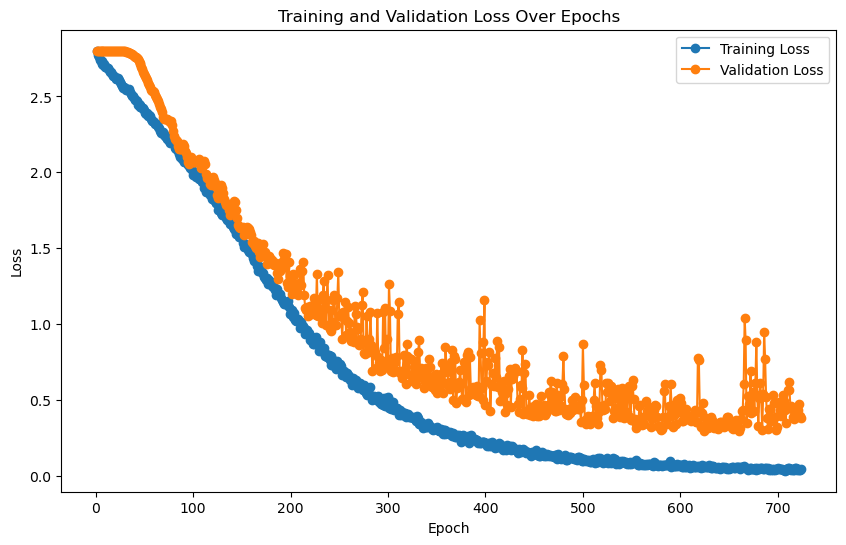

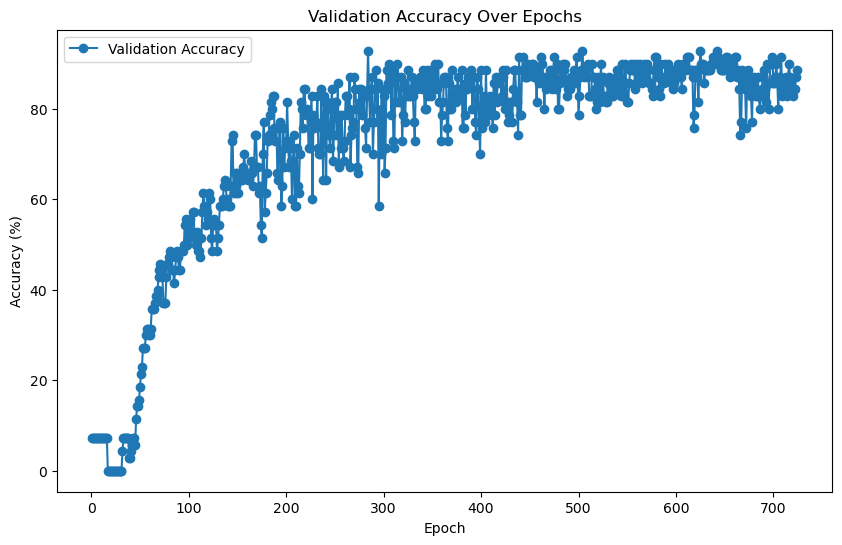


Evaluating on the test set...
    Test Batch [1/38], Loss: 0.5646



Final Test Loss: 0.7400, Test Accuracy: 78.00%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/38 for test dataset.
  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (9571, 64), Test labels shape: (9571,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.40      0.44         5
           2       0.17      0.20      0.18         5
           3       1.00      0.60      0.75         5
           4       0.40      0.40      0.40         5
           5       0.67      0.40      0.50         5
           7       1.00      1.00      1.00         5
           9       0.31      0.80      0.44         5
          10       0.75      0.60  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (9571, 64)
Test labels shape: (9571,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8466  |  Val Loss: 2.7645
Validation loss improved from inf to 2.7645.
[Epoch 2/1000] Train Loss: 2.7195  |  Val Loss: 2.6665
Validation loss improved from 2.7645 to 2.6665.
[Epoch 3/1000] Train Loss: 2.6546  |  Val Loss: 2.5952
Validation loss improved from 2.6665 to 2.5952.
[Epoch 4/1000] Train Loss: 2.5980  |  Val Loss: 2.5467
Validation loss improved from 2.5952 to 2.5467.
[Epoch 5/1000] Train Loss: 2.5407  |  Val Loss: 2.4873
Validation loss improved from 2.5467 to 2.4873.
[Epoch 6/1000] Train Loss: 2.4753  |  Val Loss: 2.4241
Validation loss improved from 2.4873 to 2.4241.
[Epoch 7/1000] Train Loss: 2.4024  |  Val Loss: 2.3617
Validation loss improved from 2.4241 to 2.3617.
[Epoch 8/1000] Train Loss: 2.3217  |  Val Loss: 2.3030
Validation loss improved from 2.3617 to 2.3030.
[Epoch 9/1000] Train Loss: 2.2390  |  Val Loss: 2.2152
Validation loss improved from 2.3030 to 2.2152.
[Epoch 10/1000] Train Loss: 2.1521  |  Val Loss: 2.1237
Validation loss impr

[Epoch 14/1000] Train Loss: 1.7956  |  Val Loss: 1.8117
Validation loss improved from 1.8700 to 1.8117.
[Epoch 15/1000] Train Loss: 1.7092  |  Val Loss: 1.7262
Validation loss improved from 1.8117 to 1.7262.
[Epoch 16/1000] Train Loss: 1.6341  |  Val Loss: 1.6724
Validation loss improved from 1.7262 to 1.6724.
[Epoch 17/1000] Train Loss: 1.5604  |  Val Loss: 1.6171
Validation loss improved from 1.6724 to 1.6171.
[Epoch 18/1000] Train Loss: 1.5256  |  Val Loss: 1.5809
Validation loss improved from 1.6171 to 1.5809.
[Epoch 19/1000] Train Loss: 1.4609  |  Val Loss: 1.5567
Validation loss improved from 1.5809 to 1.5567.


[Epoch 20/1000] Train Loss: 1.4098  |  Val Loss: 1.4902
Validation loss improved from 1.5567 to 1.4902.
[Epoch 21/1000] Train Loss: 1.3694  |  Val Loss: 1.4757
Validation loss improved from 1.4902 to 1.4757.
[Epoch 22/1000] Train Loss: 1.3435  |  Val Loss: 1.4558
Validation loss improved from 1.4757 to 1.4558.
[Epoch 23/1000] Train Loss: 1.3086  |  Val Loss: 1.4023
Validation loss improved from 1.4558 to 1.4023.
[Epoch 24/1000] Train Loss: 1.2551  |  Val Loss: 1.4238
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 25/1000] Train Loss: 1.2374  |  Val Loss: 1.3816
Validation loss improved from 1.4023 to 1.3816.
[Epoch 26/1000] Train Loss: 1.2015  |  Val Loss: 1.3445
Validation loss improved from 1.3816 to 1.3445.
[Epoch 27/1000] Train Loss: 1.1715  |  Val Loss: 1.3174
Validation loss improved from 1.3445 to 1.3174.
[Epoch 28/1000] Train Loss: 1.1588  |  Val Loss: 1.3255
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.1256  |  Val Loss: 1.2

[Epoch 33/1000] Train Loss: 1.0554  |  Val Loss: 1.2577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 1.0299  |  Val Loss: 1.2218
Validation loss improved from 1.2484 to 1.2218.
[Epoch 35/1000] Train Loss: 1.0245  |  Val Loss: 1.2164
Validation loss improved from 1.2218 to 1.2164.
[Epoch 36/1000] Train Loss: 1.0172  |  Val Loss: 1.2545
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.9991  |  Val Loss: 1.2006
Validation loss improved from 1.2164 to 1.2006.
[Epoch 38/1000] Train Loss: 0.9805  |  Val Loss: 1.2280
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.9665  |  Val Loss: 1.1563
Validation loss improved from 1.2006 to 1.1563.


[Epoch 40/1000] Train Loss: 0.9479  |  Val Loss: 1.1940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.9481  |  Val Loss: 1.1930
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 0.9348  |  Val Loss: 1.1241
Validation loss improved from 1.1563 to 1.1241.
[Epoch 43/1000] Train Loss: 0.9096  |  Val Loss: 1.1560
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.8995  |  Val Loss: 1.1622
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 0.8929  |  Val Loss: 1.1279
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 46/1000] Train Loss: 0.8755  |  Val Loss: 1.1445
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 47/1000] Train Loss: 0.8713  |  Val Loss: 1.1290
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 48/1000] Train Loss: 0.8611  |  Val Loss: 1.0902
Validation loss improved from 1.1241 to 1.0902.
[Epoch 49/1000] Train 

[Epoch 53/1000] Train Loss: 0.8256  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 54/1000] Train Loss: 0.8246  |  Val Loss: 1.1012
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 55/1000] Train Loss: 0.8097  |  Val Loss: 1.0982
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 56/1000] Train Loss: 0.7978  |  Val Loss: 1.0667
Validation loss improved from 1.0902 to 1.0667.
[Epoch 57/1000] Train Loss: 0.7821  |  Val Loss: 1.1026
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.7777  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 59/1000] Train Loss: 0.7764  |  Val Loss: 1.0758
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 60/1000] Train Loss: 0.7754  |  Val Loss: 1.0640
Validation loss improved from 1.0667 to 1.0640.
[Epoch 61/1000] Train Loss: 0.7760  |  Val Loss: 1.1195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.7523  |  Val Loss: 1.0621
Validation loss improved from 1.0640 to 1.0621.
[Epoch 63/1000] Train Loss: 0.7546  |  Val Loss: 1.0787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.7393  |  Val Loss: 1.0553
Validation loss improved from 1.0621 to 1.0553.
[Epoch 65/1000] Train Loss: 0.7262  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.7232  |  Val Loss: 1.0637
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.7179  |  Val Loss: 1.0636
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 68/1000] Train Loss: 

[Epoch 72/1000] Train Loss: 0.6872  |  Val Loss: 1.0745
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.7033  |  Val Loss: 1.0556
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.6806  |  Val Loss: 1.0433
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.6632  |  Val Loss: 1.0414
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 76/1000] Train Loss: 0.6589  |  Val Loss: 1.0401
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 0.6437  |  Val Loss: 1.0535
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 78/1000] Train Loss: 0.6550  |  Val Loss: 1.0382
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 79/1000] Train Loss: 0.6406  |  Val Loss: 1.0255
Validation loss improved from 1.0307 to 1.0255.
[Epoch 80/1000] Train Loss: 0.6368  |  Val Loss: 1.0410
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 0.6277  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 82/1000] Train Loss: 0.6246  |  Val Loss: 1.0372
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 83/1000] Train Loss: 0.6147  |  Val Loss: 1.0245
Validation loss improved from 1.0255 to 1.0245.
[Epoch 84/1000] Train Loss: 0.6181  |  Val Loss: 1.0164
Validation loss improved from 1.0245 to 1.0164.
[Epoch 85/1000] Train Loss: 

[Epoch 92/1000] Train Loss: 0.5835  |  Val Loss: 1.0193
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 93/1000] Train Loss: 0.5776  |  Val Loss: 1.0147
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 94/1000] Train Loss: 0.5791  |  Val Loss: 1.0567
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 95/1000] Train Loss: 0.5608  |  Val Loss: 0.9995
Validation loss improved from 1.0081 to 0.9995.
[Epoch 96/1000] Train Loss: 0.5640  |  Val Loss: 1.0486
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 0.5568  |  Val Loss: 0.9953
Validation loss improved from 0.9995 to 0.9953.
[Epoch 98/1000] Train Loss: 0.5473  |  Val Loss: 1.0337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 0.5495  |  Val Loss: 0.9951
Validation loss improved from 0.9953 to 0.9951.
[Epoch 100/1000] Train Loss: 0.5554  |  Val Loss: 1.0297
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss

[Epoch 110/1000] Train Loss: 0.5140  |  Val Loss: 0.9694
Validation loss improved from 0.9826 to 0.9694.
[Epoch 111/1000] Train Loss: 0.5045  |  Val Loss: 1.0792
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.5003  |  Val Loss: 1.0092
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 0.4933  |  Val Loss: 1.0104
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 0.4902  |  Val Loss: 0.9995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 0.4911  |  Val Loss: 1.0546
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 116/1000] Train Loss: 0.5003  |  Val Loss: 1.0028
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 117/1000] Train Loss: 0.4951  |  Val Loss: 0.9798
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 118/1000] Train Loss: 0.4841  |  Val Loss: 1.0842
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 129/1000] Train Loss: 0.4262  |  Val Loss: 1.0016
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 130/1000] Train Loss: 0.4237  |  Val Loss: 1.0137
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 131/1000] Train Loss: 0.4355  |  Val Loss: 1.0517
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 132/1000] Train Loss: 0.4267  |  Val Loss: 1.0018
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 133/1000] Train Loss: 0.4273  |  Val Loss: 1.0511
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 134/1000] Train Loss: 0.4238  |  Val Loss: 0.9912
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 135/1000] Train Loss: 0.4210  |  Val Loss: 1.0428
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 136/1000] Train Loss: 0.4161  |  Val Loss: 0.9949
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 137/1000] Train Loss: 0.4018  |  Val Loss: 1.0061
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 0.3717  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 148/1000] Train Loss: 0.3755  |  Val Loss: 1.0140
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 149/1000] Train Loss: 0.3705  |  Val Loss: 1.0233
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 150/1000] Train Loss: 0.3684  |  Val Loss: 0.9959
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 151/1000] Train Loss: 0.3608  |  Val Loss: 1.0505
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 152/1000] Train Loss: 0.3611  |  Val Loss: 1.0001
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 153/1000] Train Loss: 0.3725  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 154/1000] Train Loss: 0.3657  |  Val Loss: 1.0062
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 155/1000] Train Loss: 0.3780  |  Val Loss: 1.0526
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.3470  |  Val Loss: 1.0536
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 165/1000] Train Loss: 0.3294  |  Val Loss: 1.0621
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 166/1000] Train Loss: 0.3484  |  Val Loss: 1.0205
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 167/1000] Train Loss: 0.3924  |  Val Loss: 1.0817
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 168/1000] Train Loss: 0.3665  |  Val Loss: 1.0271
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 169/1000] Train Loss: 0.3647  |  Val Loss: 1.0967
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 170/1000] Train Loss: 0.3722  |  Val Loss: 1.1069
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 171/1000] Train Loss: 0.3590  |  Val Loss: 1.0152
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 172/1000] Train Loss: 0.3436  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience:

[Epoch 182/1000] Train Loss: 0.2966  |  Val Loss: 1.0456
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 183/1000] Train Loss: 0.3014  |  Val Loss: 1.0822
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 184/1000] Train Loss: 0.3078  |  Val Loss: 1.0598
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 185/1000] Train Loss: 0.3041  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 186/1000] Train Loss: 0.2918  |  Val Loss: 1.1110
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 187/1000] Train Loss: 0.2972  |  Val Loss: 1.0799
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 188/1000] Train Loss: 0.2872  |  Val Loss: 1.0644
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 189/1000] Train Loss: 0.2838  |  Val Loss: 1.0594
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 190/1000] Train Loss: 0.2935  |  Val Loss: 1.1197
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.2575  |  Val Loss: 1.1174
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 202/1000] Train Loss: 0.2700  |  Val Loss: 1.0693
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 203/1000] Train Loss: 0.2652  |  Val Loss: 1.0957
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 204/1000] Train Loss: 0.2588  |  Val Loss: 1.0831
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 205/1000] Train Loss: 0.2451  |  Val Loss: 1.1151
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 206/1000] Train Loss: 0.2542  |  Val Loss: 1.0780
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 207/1000] Train Loss: 0.2473  |  Val Loss: 1.1147
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 208/1000] Train Loss: 0.2440  |  Val Loss: 1.0604
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 209/1000] Train Loss: 0.2424  |  Val Loss: 1.1105
!! Validation loss did NOT improve !! Patience:

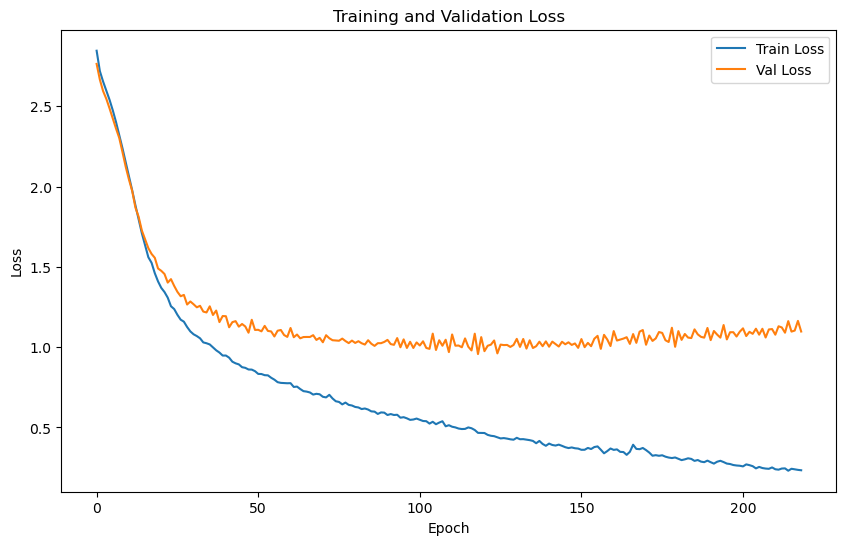

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9405 | Test Accuracy: 53.68%


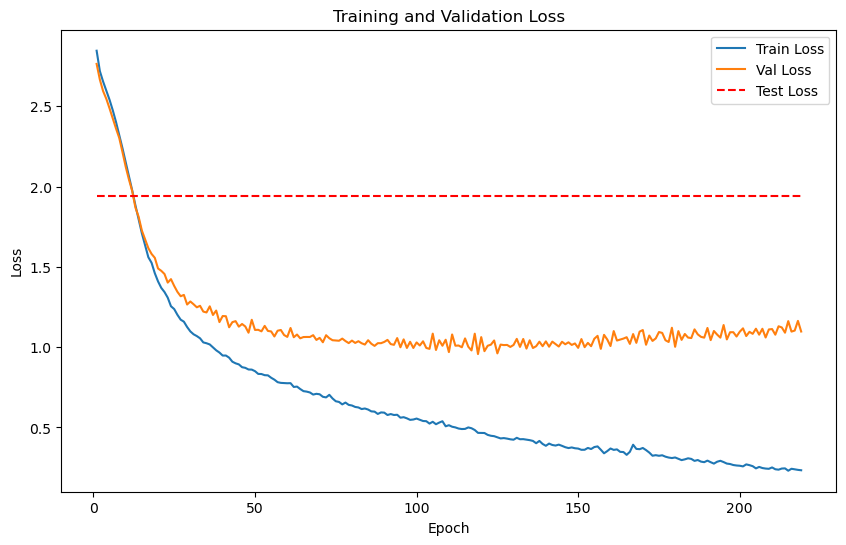

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.9279
Epoch [1/2000], Avg Train Loss: 8.9279
Epoch [1/2000], Avg Val Loss: 4.5600
Validation loss improved from inf to 4.5600. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 8.8780
Epoch [2/2000], Avg Train Loss: 8.8780
Epoch [2/2000], Avg Val Loss: 4.5147
Validation loss improved from 4.5600 to 4.5147. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7641
Epoch [3/2000], Avg Train Loss: 8.7641
Epoch [3/2000], Avg Val Loss: 4.4706
Validation loss improved from 4.5147 to 4.4706. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7352
Epoch [4/2000], Avg Train Loss: 8.7352
Epoch [4/2000], Avg Val Loss: 4.4279
Validation loss improved from 4.4706 to 4.4279. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6693
Epoch [5/2000], Avg Train Loss: 8.6693
Epoch [5/2000], Avg Val Loss: 4.3864
Validation loss improved from 4.4279 to 4.3864. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.6051
Epoch [6/2000], Avg Train Loss: 8.6051
Epoch [6/2000], Avg Val Loss: 4.3460
Validation loss improved from 4.3864 to 4.3460. Saving m

Epoch [15/2000], Avg Val Loss: 4.0309
Validation loss improved from 4.0615 to 4.0309. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.9040
Epoch [16/2000], Avg Train Loss: 7.9040
Epoch [16/2000], Avg Val Loss: 4.0013
Validation loss improved from 4.0309 to 4.0013. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.8584
Epoch [17/2000], Avg Train Loss: 7.8584
Epoch [17/2000], Avg Val Loss: 3.9728
Validation loss improved from 4.0013 to 3.9728. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.7689
Epoch [18/2000], Avg Train Loss: 7.7689
Epoch [18/2000], Avg Val Loss: 3.9451
Validation loss improved from 3.9728 to 3.9451. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.6884
Epoch [19/2000], Avg Train Loss: 7.6884
Epoch [19/2000], Avg Val Loss: 3.9183
Validation loss improved from 3.9451 to 3.9183. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.4706
Epoch [23/2000], Avg Train Loss: 7.4706
Epoch [23/2000], Avg Val Loss: 3.8206
Validation loss improved from 3.8437 to 3.8206. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.4397
Epoch [24/2000], Avg Train Loss: 7.4397
Epoch [24/2000], Avg Val Loss: 3.7983
Validation loss improved from 3.8206 to 3.7983. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.3311
Epoch [25/2000], Avg Train Loss: 7.3311
Epoch [25/2000], Avg Val Loss: 3.7769
Validation loss improved from 3.7983 to 3.7769. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.2001
Epoch [26/2000], Avg Train Loss: 7.2001
Epoch [26/2000], Avg Val Loss: 3.7562
Validation loss improved from 3.7769 to 3.7562. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.1903
Epoch [27/2000], Avg Train Loss: 7.1903
Epoch [27/2000], Avg Val Loss: 3.7363
Validation loss improved from 3.7562 to 3.

    Batch [1/1], Train Loss: 6.5531
Epoch [40/2000], Avg Train Loss: 6.5531
Epoch [40/2000], Avg Val Loss: 3.5393
Validation loss improved from 3.5508 to 3.5393. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.5128
Epoch [41/2000], Avg Train Loss: 6.5128
Epoch [41/2000], Avg Val Loss: 3.5283
Validation loss improved from 3.5393 to 3.5283. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 6.5149
Epoch [42/2000], Avg Train Loss: 6.5149
Epoch [42/2000], Avg Val Loss: 3.5178
Validation loss improved from 3.5283 to 3.5178. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.4520
Epoch [43/2000], Avg Train Loss: 6.4520
Epoch [43/2000], Avg Val Loss: 3.5078
Validation loss improved from 3.5178 to 3.5078. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.4787
Epoch [44/2000], Avg Train Loss: 6.4787
Epoch [44/2000], Avg Val Loss: 3.4980
Validation loss improved from 3.5078 to 3.

    Batch [1/1], Train Loss: 6.1370
Epoch [53/2000], Avg Train Loss: 6.1370
Epoch [53/2000], Avg Val Loss: 3.4279
Validation loss improved from 3.4342 to 3.4279. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.0592
Epoch [54/2000], Avg Train Loss: 6.0592
Epoch [54/2000], Avg Val Loss: 3.4218
Validation loss improved from 3.4279 to 3.4218. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 6.0732
Epoch [55/2000], Avg Train Loss: 6.0732
Epoch [55/2000], Avg Val Loss: 3.4160
Validation loss improved from 3.4218 to 3.4160. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0707
Epoch [56/2000], Avg Train Loss: 6.0707
Epoch [56/2000], Avg Val Loss: 3.4104
Validation loss improved from 3.4160 to 3.4104. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 6.0516
Epoch [57/2000], Avg Train Loss: 6.0516
Epoch [57/2000], Avg Val Loss: 3.4051
Validation loss improved from 3.4104 to 3.

    Batch [1/1], Train Loss: 5.6980
Epoch [76/2000], Avg Train Loss: 5.6980
Epoch [76/2000], Avg Val Loss: 3.3413
Validation loss improved from 3.3434 to 3.3413. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.6444
Epoch [77/2000], Avg Train Loss: 5.6444
Epoch [77/2000], Avg Val Loss: 3.3393
Validation loss improved from 3.3413 to 3.3393. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.6926
Epoch [78/2000], Avg Train Loss: 5.6926
Epoch [78/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3393 to 3.3373. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.6029
Epoch [79/2000], Avg Train Loss: 5.6029
Epoch [79/2000], Avg Val Loss: 3.3355
Validation loss improved from 3.3373 to 3.3355. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.6426
Epoch [80/2000], Avg Train Loss: 5.6426
Epoch [80/2000], Avg Val Loss: 3.3337
Validation loss improved from 3.3355 to 3.

    Batch [1/1], Train Loss: 5.4612
Epoch [92/2000], Avg Train Loss: 5.4612
Epoch [92/2000], Avg Val Loss: 3.3159
Validation loss improved from 3.3172 to 3.3159. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.5038
Epoch [93/2000], Avg Train Loss: 5.5038
Epoch [93/2000], Avg Val Loss: 3.3147
Validation loss improved from 3.3159 to 3.3147. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.4743
Epoch [94/2000], Avg Train Loss: 5.4743
Epoch [94/2000], Avg Val Loss: 3.3135
Validation loss improved from 3.3147 to 3.3135. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.4570
Epoch [95/2000], Avg Train Loss: 5.4570
Epoch [95/2000], Avg Val Loss: 3.3124
Validation loss improved from 3.3135 to 3.3124. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.4759
Epoch [96/2000], Avg Train Loss: 5.4759
Epoch [96/2000], Avg Val Loss: 3.3112
Validation loss improved from 3.3124 to 3.

Epoch [111/2000], Avg Val Loss: 3.2965
Validation loss improved from 3.2974 to 3.2965. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.3469
Epoch [112/2000], Avg Train Loss: 5.3469
Epoch [112/2000], Avg Val Loss: 3.2957
Validation loss improved from 3.2965 to 3.2957. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.3978
Epoch [113/2000], Avg Train Loss: 5.3978
Epoch [113/2000], Avg Val Loss: 3.2949
Validation loss improved from 3.2957 to 3.2949. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 5.3459
Epoch [114/2000], Avg Train Loss: 5.3459
Epoch [114/2000], Avg Val Loss: 3.2941
Validation loss improved from 3.2949 to 3.2941. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 5.3480
Epoch [115/2000], Avg Train Loss: 5.3480
Epoch [115/2000], Avg Val Loss: 3.2932
Validation loss improved from 3.2941 to 3.2932. Saving model...

LOG: Epoch [116/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3043
Epoch [126/2000], Avg Train Loss: 5.3043
Epoch [126/2000], Avg Val Loss: 3.2843
Validation loss improved from 3.2851 to 3.2843. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.2989
Epoch [127/2000], Avg Train Loss: 5.2989
Epoch [127/2000], Avg Val Loss: 3.2835
Validation loss improved from 3.2843 to 3.2835. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.2837
Epoch [128/2000], Avg Train Loss: 5.2837
Epoch [128/2000], Avg Val Loss: 3.2827
Validation loss improved from 3.2835 to 3.2827. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.2635
Epoch [129/2000], Avg Train Loss: 5.2635
Epoch [129/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.2827 to 3.2819. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.2508
Epoch [130/2000], Avg Train Loss: 5.2508
Epoch [130/2000], Avg Val Loss: 3.2811
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2056
Epoch [146/2000], Avg Train Loss: 5.2056
Epoch [146/2000], Avg Val Loss: 3.2689
Validation loss improved from 3.2696 to 3.2689. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2228
Epoch [147/2000], Avg Train Loss: 5.2228
Epoch [147/2000], Avg Val Loss: 3.2682
Validation loss improved from 3.2689 to 3.2682. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 5.2266
Epoch [148/2000], Avg Train Loss: 5.2266
Epoch [148/2000], Avg Val Loss: 3.2675
Validation loss improved from 3.2682 to 3.2675. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 5.2173
Epoch [149/2000], Avg Train Loss: 5.2173
Epoch [149/2000], Avg Val Loss: 3.2669
Validation loss improved from 3.2675 to 3.2669. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 5.1797
Epoch [150/2000], Avg Train Loss: 5.1797
Epoch [150/2000], Avg Val Loss: 3.2662
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1475
Epoch [164/2000], Avg Train Loss: 5.1475
Epoch [164/2000], Avg Val Loss: 3.2576
Validation loss improved from 3.2582 to 3.2576. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 5.1071
Epoch [165/2000], Avg Train Loss: 5.1071
Epoch [165/2000], Avg Val Loss: 3.2570
Validation loss improved from 3.2576 to 3.2570. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.1016
Epoch [166/2000], Avg Train Loss: 5.1016
Epoch [166/2000], Avg Val Loss: 3.2563
Validation loss improved from 3.2570 to 3.2563. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.1243
Epoch [167/2000], Avg Train Loss: 5.1243
Epoch [167/2000], Avg Val Loss: 3.2557
Validation loss improved from 3.2563 to 3.2557. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.1290
Epoch [168/2000], Avg Train Loss: 5.1290
Epoch [168/2000], Avg Val Loss: 3.2551
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0862
Epoch [182/2000], Avg Train Loss: 5.0862
Epoch [182/2000], Avg Val Loss: 3.2467
Validation loss improved from 3.2472 to 3.2467. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.0858
Epoch [183/2000], Avg Train Loss: 5.0858
Epoch [183/2000], Avg Val Loss: 3.2461
Validation loss improved from 3.2467 to 3.2461. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.1132
Epoch [184/2000], Avg Train Loss: 5.1132
Epoch [184/2000], Avg Val Loss: 3.2456
Validation loss improved from 3.2461 to 3.2456. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 5.0501
Epoch [185/2000], Avg Train Loss: 5.0501
Epoch [185/2000], Avg Val Loss: 3.2450
Validation loss improved from 3.2456 to 3.2450. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 5.0467
Epoch [186/2000], Avg Train Loss: 5.0467
Epoch [186/2000], Avg Val Loss: 3.2445
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0544
Epoch [198/2000], Avg Train Loss: 5.0544
Epoch [198/2000], Avg Val Loss: 3.2385
Validation loss improved from 3.2390 to 3.2385. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.0331
Epoch [199/2000], Avg Train Loss: 5.0331
Epoch [199/2000], Avg Val Loss: 3.2380
Validation loss improved from 3.2385 to 3.2380. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.0268
Epoch [200/2000], Avg Train Loss: 5.0268
Epoch [200/2000], Avg Val Loss: 3.2374
Validation loss improved from 3.2380 to 3.2374. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.0528
Epoch [201/2000], Avg Train Loss: 5.0528
Epoch [201/2000], Avg Val Loss: 3.2369
Validation loss improved from 3.2374 to 3.2369. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.0184
Epoch [202/2000], Avg Train Loss: 5.0184
Epoch [202/2000], Avg Val Loss: 3.2364
Validation loss improved fro

Epoch [218/2000], Avg Val Loss: 3.2296
Validation loss improved from 3.2300 to 3.2296. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.9700
Epoch [219/2000], Avg Train Loss: 4.9700
Epoch [219/2000], Avg Val Loss: 3.2292
Validation loss improved from 3.2296 to 3.2292. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.9695
Epoch [220/2000], Avg Train Loss: 4.9695
Epoch [220/2000], Avg Val Loss: 3.2288
Validation loss improved from 3.2292 to 3.2288. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.9858
Epoch [221/2000], Avg Train Loss: 4.9858
Epoch [221/2000], Avg Val Loss: 3.2284
Validation loss improved from 3.2288 to 3.2284. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.9777
Epoch [222/2000], Avg Train Loss: 4.9777
Epoch [222/2000], Avg Val Loss: 3.2281
Validation loss improved from 3.2284 to 3.2281. Saving model...

LOG: Epoch [223/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9681
Epoch [233/2000], Avg Train Loss: 4.9681
Epoch [233/2000], Avg Val Loss: 3.2245
Validation loss improved from 3.2248 to 3.2245. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.9408
Epoch [234/2000], Avg Train Loss: 4.9408
Epoch [234/2000], Avg Val Loss: 3.2241
Validation loss improved from 3.2245 to 3.2241. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.9634
Epoch [235/2000], Avg Train Loss: 4.9634
Epoch [235/2000], Avg Val Loss: 3.2237
Validation loss improved from 3.2241 to 3.2237. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.9687
Epoch [236/2000], Avg Train Loss: 4.9687
Epoch [236/2000], Avg Val Loss: 3.2234
Validation loss improved from 3.2237 to 3.2234. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.9396
Epoch [237/2000], Avg Train Loss: 4.9396
Epoch [237/2000], Avg Val Loss: 3.2230
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9518
Epoch [253/2000], Avg Train Loss: 4.9518
Epoch [253/2000], Avg Val Loss: 3.2176
Validation loss improved from 3.2179 to 3.2176. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.8778
Epoch [254/2000], Avg Train Loss: 4.8778
Epoch [254/2000], Avg Val Loss: 3.2173
Validation loss improved from 3.2176 to 3.2173. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.8853
Epoch [255/2000], Avg Train Loss: 4.8853
Epoch [255/2000], Avg Val Loss: 3.2170
Validation loss improved from 3.2173 to 3.2170. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.9203
Epoch [256/2000], Avg Train Loss: 4.9203
Epoch [256/2000], Avg Val Loss: 3.2167
Validation loss improved from 3.2170 to 3.2167. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.9049
Epoch [257/2000], Avg Train Loss: 4.9049
Epoch [257/2000], Avg Val Loss: 3.2163
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9080
Epoch [269/2000], Avg Train Loss: 4.9080
Epoch [269/2000], Avg Val Loss: 3.2128
Validation loss improved from 3.2131 to 3.2128. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.8854
Epoch [270/2000], Avg Train Loss: 4.8854
Epoch [270/2000], Avg Val Loss: 3.2125
Validation loss improved from 3.2128 to 3.2125. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.9409
Epoch [271/2000], Avg Train Loss: 4.9409
Epoch [271/2000], Avg Val Loss: 3.2122
Validation loss improved from 3.2125 to 3.2122. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.8817
Epoch [272/2000], Avg Train Loss: 4.8817
Epoch [272/2000], Avg Val Loss: 3.2119
Validation loss improved from 3.2122 to 3.2119. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.8597
Epoch [273/2000], Avg Train Loss: 4.8597
Epoch [273/2000], Avg Val Loss: 3.2116
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8751
Epoch [293/2000], Avg Train Loss: 4.8751
Epoch [293/2000], Avg Val Loss: 3.2064
Validation loss improved from 3.2067 to 3.2064. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.8685
Epoch [294/2000], Avg Train Loss: 4.8685
Epoch [294/2000], Avg Val Loss: 3.2062
Validation loss improved from 3.2064 to 3.2062. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.8480
Epoch [295/2000], Avg Train Loss: 4.8480
Epoch [295/2000], Avg Val Loss: 3.2059
Validation loss improved from 3.2062 to 3.2059. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.8888
Epoch [296/2000], Avg Train Loss: 4.8888
Epoch [296/2000], Avg Val Loss: 3.2056
Validation loss improved from 3.2059 to 3.2056. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.8464
Epoch [297/2000], Avg Train Loss: 4.8464
Epoch [297/2000], Avg Val Loss: 3.2054
Validation loss improved fro

Epoch [305/2000], Avg Val Loss: 3.2035
Validation loss improved from 3.2037 to 3.2035. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.8332
Epoch [306/2000], Avg Train Loss: 4.8332
Epoch [306/2000], Avg Val Loss: 3.2032
Validation loss improved from 3.2035 to 3.2032. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.8471
Epoch [307/2000], Avg Train Loss: 4.8471
Epoch [307/2000], Avg Val Loss: 3.2029
Validation loss improved from 3.2032 to 3.2029. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.8611
Epoch [308/2000], Avg Train Loss: 4.8611
Epoch [308/2000], Avg Val Loss: 3.2027
Validation loss improved from 3.2029 to 3.2027. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.8410
Epoch [309/2000], Avg Train Loss: 4.8410
Epoch [309/2000], Avg Val Loss: 3.2024
Validation loss improved from 3.2027 to 3.2024. Saving model...

LOG: Epoch [310/2000] - Training
    Bat

Epoch [327/2000], Avg Val Loss: 3.1980
Validation loss improved from 3.1982 to 3.1980. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8181
Epoch [328/2000], Avg Train Loss: 4.8181
Epoch [328/2000], Avg Val Loss: 3.1978
Validation loss improved from 3.1980 to 3.1978. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.7793
Epoch [329/2000], Avg Train Loss: 4.7793
Epoch [329/2000], Avg Val Loss: 3.1975
Validation loss improved from 3.1978 to 3.1975. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.8042
Epoch [330/2000], Avg Train Loss: 4.8042
Epoch [330/2000], Avg Val Loss: 3.1973
Validation loss improved from 3.1975 to 3.1973. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.7849
Epoch [331/2000], Avg Train Loss: 4.7849
Epoch [331/2000], Avg Val Loss: 3.1971
Validation loss improved from 3.1973 to 3.1971. Saving model...

LOG: Epoch [332/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7793
Epoch [343/2000], Avg Train Loss: 4.7793
Epoch [343/2000], Avg Val Loss: 3.1943
Validation loss improved from 3.1945 to 3.1943. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.8016
Epoch [344/2000], Avg Train Loss: 4.8016
Epoch [344/2000], Avg Val Loss: 3.1941
Validation loss improved from 3.1943 to 3.1941. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.7935
Epoch [345/2000], Avg Train Loss: 4.7935
Epoch [345/2000], Avg Val Loss: 3.1939
Validation loss improved from 3.1941 to 3.1939. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.8015
Epoch [346/2000], Avg Train Loss: 4.8015
Epoch [346/2000], Avg Val Loss: 3.1938
Validation loss improved from 3.1939 to 3.1938. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.7390
Epoch [347/2000], Avg Train Loss: 4.7390
Epoch [347/2000], Avg Val Loss: 3.1936
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7612
Epoch [365/2000], Avg Train Loss: 4.7612
Epoch [365/2000], Avg Val Loss: 3.1904
Validation loss improved from 3.1906 to 3.1904. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.7574
Epoch [366/2000], Avg Train Loss: 4.7574
Epoch [366/2000], Avg Val Loss: 3.1903
Validation loss improved from 3.1904 to 3.1903. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.7519
Epoch [367/2000], Avg Train Loss: 4.7519
Epoch [367/2000], Avg Val Loss: 3.1901
Validation loss improved from 3.1903 to 3.1901. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.7282
Epoch [368/2000], Avg Train Loss: 4.7282
Epoch [368/2000], Avg Val Loss: 3.1900
Validation loss improved from 3.1901 to 3.1900. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.7205
Epoch [369/2000], Avg Train Loss: 4.7205
Epoch [369/2000], Avg Val Loss: 3.1898
Validation loss improved fro

Epoch [380/2000], Avg Val Loss: 3.1881
Validation loss improved from 3.1883 to 3.1881. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.7369
Epoch [381/2000], Avg Train Loss: 4.7369
Epoch [381/2000], Avg Val Loss: 3.1879
Validation loss improved from 3.1881 to 3.1879. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.7355
Epoch [382/2000], Avg Train Loss: 4.7355
Epoch [382/2000], Avg Val Loss: 3.1877
Validation loss improved from 3.1879 to 3.1877. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.7659
Epoch [383/2000], Avg Train Loss: 4.7659
Epoch [383/2000], Avg Val Loss: 3.1875
Validation loss improved from 3.1877 to 3.1875. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.7264
Epoch [384/2000], Avg Train Loss: 4.7264
Epoch [384/2000], Avg Val Loss: 3.1874
Validation loss improved from 3.1875 to 3.1874. Saving model...

LOG: Epoch [385/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7106
Epoch [401/2000], Avg Train Loss: 4.7106
Epoch [401/2000], Avg Val Loss: 3.1830
Validation loss improved from 3.1832 to 3.1830. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.7232
Epoch [402/2000], Avg Train Loss: 4.7232
Epoch [402/2000], Avg Val Loss: 3.1827
Validation loss improved from 3.1830 to 3.1827. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.7369
Epoch [403/2000], Avg Train Loss: 4.7369
Epoch [403/2000], Avg Val Loss: 3.1824
Validation loss improved from 3.1827 to 3.1824. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.7426
Epoch [404/2000], Avg Train Loss: 4.7426
Epoch [404/2000], Avg Val Loss: 3.1822
Validation loss improved from 3.1824 to 3.1822. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.7245
Epoch [405/2000], Avg Train Loss: 4.7245
Epoch [405/2000], Avg Val Loss: 3.1819
Validation loss improved fro

Epoch [419/2000], Avg Val Loss: 3.1787
Validation loss improved from 3.1789 to 3.1787. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.6883
Epoch [420/2000], Avg Train Loss: 4.6883
Epoch [420/2000], Avg Val Loss: 3.1785
Validation loss improved from 3.1787 to 3.1785. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.6908
Epoch [421/2000], Avg Train Loss: 4.6908
Epoch [421/2000], Avg Val Loss: 3.1783
Validation loss improved from 3.1785 to 3.1783. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.6964
Epoch [422/2000], Avg Train Loss: 4.6964
Epoch [422/2000], Avg Val Loss: 3.1781
Validation loss improved from 3.1783 to 3.1781. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.6745
Epoch [423/2000], Avg Train Loss: 4.6745
Epoch [423/2000], Avg Val Loss: 3.1779
Validation loss improved from 3.1781 to 3.1779. Saving model...

LOG: Epoch [424/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6685
Epoch [438/2000], Avg Train Loss: 4.6685
Epoch [438/2000], Avg Val Loss: 3.1750
Validation loss improved from 3.1752 to 3.1750. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.6935
Epoch [439/2000], Avg Train Loss: 4.6935
Epoch [439/2000], Avg Val Loss: 3.1748
Validation loss improved from 3.1750 to 3.1748. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.6591
Epoch [440/2000], Avg Train Loss: 4.6591
Epoch [440/2000], Avg Val Loss: 3.1746
Validation loss improved from 3.1748 to 3.1746. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.6549
Epoch [441/2000], Avg Train Loss: 4.6549
Epoch [441/2000], Avg Val Loss: 3.1744
Validation loss improved from 3.1746 to 3.1744. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.6676
Epoch [442/2000], Avg Train Loss: 4.6676
Epoch [442/2000], Avg Val Loss: 3.1743
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6451
Epoch [456/2000], Avg Train Loss: 4.6451
Epoch [456/2000], Avg Val Loss: 3.1720
Validation loss improved from 3.1722 to 3.1720. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.6648
Epoch [457/2000], Avg Train Loss: 4.6648
Epoch [457/2000], Avg Val Loss: 3.1718
Validation loss improved from 3.1720 to 3.1718. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.6704
Epoch [458/2000], Avg Train Loss: 4.6704
Epoch [458/2000], Avg Val Loss: 3.1716
Validation loss improved from 3.1718 to 3.1716. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.6663
Epoch [459/2000], Avg Train Loss: 4.6663
Epoch [459/2000], Avg Val Loss: 3.1714
Validation loss improved from 3.1716 to 3.1714. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.6643
Epoch [460/2000], Avg Train Loss: 4.6643
Epoch [460/2000], Avg Val Loss: 3.1713
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6284
Epoch [477/2000], Avg Train Loss: 4.6284
Epoch [477/2000], Avg Val Loss: 3.1680
Validation loss improved from 3.1682 to 3.1680. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.6160
Epoch [478/2000], Avg Train Loss: 4.6160
Epoch [478/2000], Avg Val Loss: 3.1677
Validation loss improved from 3.1680 to 3.1677. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.6551
Epoch [479/2000], Avg Train Loss: 4.6551
Epoch [479/2000], Avg Val Loss: 3.1675
Validation loss improved from 3.1677 to 3.1675. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.5932
Epoch [480/2000], Avg Train Loss: 4.5932
Epoch [480/2000], Avg Val Loss: 3.1673
Validation loss improved from 3.1675 to 3.1673. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.6601
Epoch [481/2000], Avg Train Loss: 4.6601
Epoch [481/2000], Avg Val Loss: 3.1671
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6524
Epoch [492/2000], Avg Train Loss: 4.6524
Epoch [492/2000], Avg Val Loss: 3.1645
Validation loss improved from 3.1648 to 3.1645. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.6347
Epoch [493/2000], Avg Train Loss: 4.6347
Epoch [493/2000], Avg Val Loss: 3.1642
Validation loss improved from 3.1645 to 3.1642. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.6135
Epoch [494/2000], Avg Train Loss: 4.6135
Epoch [494/2000], Avg Val Loss: 3.1640
Validation loss improved from 3.1642 to 3.1640. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.6211
Epoch [495/2000], Avg Train Loss: 4.6211
Epoch [495/2000], Avg Val Loss: 3.1638
Validation loss improved from 3.1640 to 3.1638. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.6242
Epoch [496/2000], Avg Train Loss: 4.6242
Epoch [496/2000], Avg Val Loss: 3.1636
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6200
Epoch [511/2000], Avg Train Loss: 4.6200
Epoch [511/2000], Avg Val Loss: 3.1608
Validation loss improved from 3.1609 to 3.1608. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.6229
Epoch [512/2000], Avg Train Loss: 4.6229
Epoch [512/2000], Avg Val Loss: 3.1607
Validation loss improved from 3.1608 to 3.1607. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.6039
Epoch [513/2000], Avg Train Loss: 4.6039
Epoch [513/2000], Avg Val Loss: 3.1605
Validation loss improved from 3.1607 to 3.1605. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.6536
Epoch [514/2000], Avg Train Loss: 4.6536
Epoch [514/2000], Avg Val Loss: 3.1604
Validation loss improved from 3.1605 to 3.1604. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.6240
Epoch [515/2000], Avg Train Loss: 4.6240
Epoch [515/2000], Avg Val Loss: 3.1603
Validation loss improved fro

Epoch [525/2000], Avg Val Loss: 3.1589
Validation loss improved from 3.1590 to 3.1589. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.6112
Epoch [526/2000], Avg Train Loss: 4.6112
Epoch [526/2000], Avg Val Loss: 3.1587
Validation loss improved from 3.1589 to 3.1587. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.6130
Epoch [527/2000], Avg Train Loss: 4.6130
Epoch [527/2000], Avg Val Loss: 3.1586
Validation loss improved from 3.1587 to 3.1586. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.5869
Epoch [528/2000], Avg Train Loss: 4.5869
Epoch [528/2000], Avg Val Loss: 3.1584
Validation loss improved from 3.1586 to 3.1584. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.6108
Epoch [529/2000], Avg Train Loss: 4.6108
Epoch [529/2000], Avg Val Loss: 3.1583
Validation loss improved from 3.1584 to 3.1583. Saving model...

LOG: Epoch [530/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6171
Epoch [549/2000], Avg Train Loss: 4.6171
Epoch [549/2000], Avg Val Loss: 3.1544
Validation loss improved from 3.1545 to 3.1544. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.6125
Epoch [550/2000], Avg Train Loss: 4.6125
Epoch [550/2000], Avg Val Loss: 3.1542
Validation loss improved from 3.1544 to 3.1542. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.6068
Epoch [551/2000], Avg Train Loss: 4.6068
Epoch [551/2000], Avg Val Loss: 3.1541
Validation loss improved from 3.1542 to 3.1541. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.6049
Epoch [552/2000], Avg Train Loss: 4.6049
Epoch [552/2000], Avg Val Loss: 3.1540
Validation loss improved from 3.1541 to 3.1540. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.5515
Epoch [553/2000], Avg Train Loss: 4.5515
Epoch [553/2000], Avg Val Loss: 3.1538
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6066
Epoch [562/2000], Avg Train Loss: 4.6066
Epoch [562/2000], Avg Val Loss: 3.1526
Validation loss improved from 3.1527 to 3.1526. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.5645
Epoch [563/2000], Avg Train Loss: 4.5645
Epoch [563/2000], Avg Val Loss: 3.1524
Validation loss improved from 3.1526 to 3.1524. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.6107
Epoch [564/2000], Avg Train Loss: 4.6107
Epoch [564/2000], Avg Val Loss: 3.1522
Validation loss improved from 3.1524 to 3.1522. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.6117
Epoch [565/2000], Avg Train Loss: 4.6117
Epoch [565/2000], Avg Val Loss: 3.1521
Validation loss improved from 3.1522 to 3.1521. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.5873
Epoch [566/2000], Avg Train Loss: 4.5873
Epoch [566/2000], Avg Val Loss: 3.1519
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5843
Epoch [585/2000], Avg Train Loss: 4.5843
Epoch [585/2000], Avg Val Loss: 3.1479
Validation loss improved from 3.1481 to 3.1479. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.5586
Epoch [586/2000], Avg Train Loss: 4.5586
Epoch [586/2000], Avg Val Loss: 3.1476
Validation loss improved from 3.1479 to 3.1476. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.5549
Epoch [587/2000], Avg Train Loss: 4.5549
Epoch [587/2000], Avg Val Loss: 3.1474
Validation loss improved from 3.1476 to 3.1474. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.5520
Epoch [588/2000], Avg Train Loss: 4.5520
Epoch [588/2000], Avg Val Loss: 3.1472
Validation loss improved from 3.1474 to 3.1472. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.5732
Epoch [589/2000], Avg Train Loss: 4.5732
Epoch [589/2000], Avg Val Loss: 3.1470
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5674
Epoch [597/2000], Avg Train Loss: 4.5674
Epoch [597/2000], Avg Val Loss: 3.1458
Validation loss improved from 3.1459 to 3.1458. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.5674
Epoch [598/2000], Avg Train Loss: 4.5674
Epoch [598/2000], Avg Val Loss: 3.1457
Validation loss improved from 3.1458 to 3.1457. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.5340
Epoch [599/2000], Avg Train Loss: 4.5340
Epoch [599/2000], Avg Val Loss: 3.1456
Validation loss improved from 3.1457 to 3.1456. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.5179
Epoch [600/2000], Avg Train Loss: 4.5179
Epoch [600/2000], Avg Val Loss: 3.1455
Validation loss improved from 3.1456 to 3.1455. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.5868
Epoch [601/2000], Avg Train Loss: 4.5868
Epoch [601/2000], Avg Val Loss: 3.1454
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5548
Epoch [623/2000], Avg Train Loss: 4.5548
Epoch [623/2000], Avg Val Loss: 3.1436
Validation loss improved from 3.1437 to 3.1436. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.5634
Epoch [624/2000], Avg Train Loss: 4.5634
Epoch [624/2000], Avg Val Loss: 3.1435
Validation loss improved from 3.1436 to 3.1435. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.5207
Epoch [625/2000], Avg Train Loss: 4.5207
Epoch [625/2000], Avg Val Loss: 3.1434
Validation loss improved from 3.1435 to 3.1434. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.5725
Epoch [626/2000], Avg Train Loss: 4.5725
Epoch [626/2000], Avg Val Loss: 3.1432
Validation loss improved from 3.1434 to 3.1432. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.5329
Epoch [627/2000], Avg Train Loss: 4.5329
Epoch [627/2000], Avg Val Loss: 3.1430
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5383
Epoch [634/2000], Avg Train Loss: 4.5383
Epoch [634/2000], Avg Val Loss: 3.1416
Validation loss improved from 3.1419 to 3.1416. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.5724
Epoch [635/2000], Avg Train Loss: 4.5724
Epoch [635/2000], Avg Val Loss: 3.1414
Validation loss improved from 3.1416 to 3.1414. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.5198
Epoch [636/2000], Avg Train Loss: 4.5198
Epoch [636/2000], Avg Val Loss: 3.1412
Validation loss improved from 3.1414 to 3.1412. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 4.5307
Epoch [637/2000], Avg Train Loss: 4.5307
Epoch [637/2000], Avg Val Loss: 3.1410
Validation loss improved from 3.1412 to 3.1410. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 4.5511
Epoch [638/2000], Avg Train Loss: 4.5511
Epoch [638/2000], Avg Val Loss: 3.1408
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5299
Epoch [656/2000], Avg Train Loss: 4.5299
Epoch [656/2000], Avg Val Loss: 3.1366
Validation loss improved from 3.1369 to 3.1366. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.5414
Epoch [657/2000], Avg Train Loss: 4.5414
Epoch [657/2000], Avg Val Loss: 3.1363
Validation loss improved from 3.1366 to 3.1363. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.5086
Epoch [658/2000], Avg Train Loss: 4.5086
Epoch [658/2000], Avg Val Loss: 3.1361
Validation loss improved from 3.1363 to 3.1361. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.5103
Epoch [659/2000], Avg Train Loss: 4.5103
Epoch [659/2000], Avg Val Loss: 3.1358
Validation loss improved from 3.1361 to 3.1358. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 4.5197
Epoch [660/2000], Avg Train Loss: 4.5197
Epoch [660/2000], Avg Val Loss: 3.1355
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4971
Epoch [695/2000], Avg Train Loss: 4.4971
Epoch [695/2000], Avg Val Loss: 3.1290
Validation loss improved from 3.1292 to 3.1290. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.4912
Epoch [696/2000], Avg Train Loss: 4.4912
Epoch [696/2000], Avg Val Loss: 3.1288
Validation loss improved from 3.1290 to 3.1288. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.4920
Epoch [697/2000], Avg Train Loss: 4.4920
Epoch [697/2000], Avg Val Loss: 3.1285
Validation loss improved from 3.1288 to 3.1285. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.4926
Epoch [698/2000], Avg Train Loss: 4.4926
Epoch [698/2000], Avg Val Loss: 3.1283
Validation loss improved from 3.1285 to 3.1283. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.5309
Epoch [699/2000], Avg Train Loss: 4.5309
Epoch [699/2000], Avg Val Loss: 3.1281
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4656
Epoch [731/2000], Avg Train Loss: 4.4656
Epoch [731/2000], Avg Val Loss: 3.1222
Validation loss improved from 3.1222 to 3.1222. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.4809
Epoch [732/2000], Avg Train Loss: 4.4809
Epoch [732/2000], Avg Val Loss: 3.1221
Validation loss improved from 3.1222 to 3.1221. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.5087
Epoch [733/2000], Avg Train Loss: 4.5087
Epoch [733/2000], Avg Val Loss: 3.1221
Validation loss improved from 3.1221 to 3.1221. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.4866
Epoch [734/2000], Avg Train Loss: 4.4866
Epoch [734/2000], Avg Val Loss: 3.1220
Validation loss improved from 3.1221 to 3.1220. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 4.4655
Epoch [735/2000], Avg Train Loss: 4.4655
Epoch [735/2000], Avg Val Loss: 3.1219
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4715
Epoch [768/2000], Avg Train Loss: 4.4715
Epoch [768/2000], Avg Val Loss: 3.1180
Validation loss improved from 3.1182 to 3.1180. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [769/2000], Avg Train Loss: 4.4458
Epoch [769/2000], Avg Val Loss: 3.1178
Validation loss improved from 3.1180 to 3.1178. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.4946
Epoch [770/2000], Avg Train Loss: 4.4946
Epoch [770/2000], Avg Val Loss: 3.1176
Validation loss improved from 3.1178 to 3.1176. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 4.4703
Epoch [771/2000], Avg Train Loss: 4.4703
Epoch [771/2000], Avg Val Loss: 3.1174
Validation loss improved from 3.1176 to 3.1174. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 4.4714
Epoch [772/2000], Avg Train Loss: 4.4714
Epoch [772/2000], Avg Val Loss: 3.1172
Validation loss improved fro

Epoch [803/2000], Avg Val Loss: 3.1130
Validation loss improved from 3.1132 to 3.1130. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 4.4420
Epoch [804/2000], Avg Train Loss: 4.4420
Epoch [804/2000], Avg Val Loss: 3.1128
Validation loss improved from 3.1130 to 3.1128. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.4190
Epoch [805/2000], Avg Train Loss: 4.4190
Epoch [805/2000], Avg Val Loss: 3.1125
Validation loss improved from 3.1128 to 3.1125. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.4304
Epoch [806/2000], Avg Train Loss: 4.4304
Epoch [806/2000], Avg Val Loss: 3.1123
Validation loss improved from 3.1125 to 3.1123. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.4342
Epoch [807/2000], Avg Train Loss: 4.4342
Epoch [807/2000], Avg Val Loss: 3.1121
Validation loss improved from 3.1123 to 3.1121. Saving model...

LOG: Epoch [808/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4278
Epoch [839/2000], Avg Train Loss: 4.4278
Epoch [839/2000], Avg Val Loss: 3.1057
Validation loss improved from 3.1060 to 3.1057. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 4.4079
Epoch [840/2000], Avg Train Loss: 4.4079
Epoch [840/2000], Avg Val Loss: 3.1055
Validation loss improved from 3.1057 to 3.1055. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 4.4421
Epoch [841/2000], Avg Train Loss: 4.4421
Epoch [841/2000], Avg Val Loss: 3.1052
Validation loss improved from 3.1055 to 3.1052. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 4.4450
Epoch [842/2000], Avg Train Loss: 4.4450
Epoch [842/2000], Avg Val Loss: 3.1050
Validation loss improved from 3.1052 to 3.1050. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 4.4262
Epoch [843/2000], Avg Train Loss: 4.4262
Epoch [843/2000], Avg Val Loss: 3.1048
Validation loss improved fro

Epoch [875/2000], Avg Val Loss: 3.1019
Validation loss improved from 3.1020 to 3.1019. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.4192
Epoch [876/2000], Avg Train Loss: 4.4192
Epoch [876/2000], Avg Val Loss: 3.1018
Validation loss improved from 3.1019 to 3.1018. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.4285
Epoch [877/2000], Avg Train Loss: 4.4285
Epoch [877/2000], Avg Val Loss: 3.1017
Validation loss improved from 3.1018 to 3.1017. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.4016
Epoch [878/2000], Avg Train Loss: 4.4016
Epoch [878/2000], Avg Val Loss: 3.1016
Validation loss improved from 3.1017 to 3.1016. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 4.3950
Epoch [879/2000], Avg Train Loss: 4.3950
Epoch [879/2000], Avg Val Loss: 3.1015
Validation loss improved from 3.1016 to 3.1015. Saving model...

LOG: Epoch [880/2000] - Training
    Bat

Epoch [911/2000], Avg Val Loss: 3.0969
Validation loss improved from 3.0971 to 3.0969. Saving model...

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 4.4045
Epoch [912/2000], Avg Train Loss: 4.4045
Epoch [912/2000], Avg Val Loss: 3.0967
Validation loss improved from 3.0969 to 3.0967. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.4048
Epoch [913/2000], Avg Train Loss: 4.4048
Epoch [913/2000], Avg Val Loss: 3.0964
Validation loss improved from 3.0967 to 3.0964. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.3876
Epoch [914/2000], Avg Train Loss: 4.3876
Epoch [914/2000], Avg Val Loss: 3.0963
Validation loss improved from 3.0964 to 3.0963. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.4031
Epoch [915/2000], Avg Train Loss: 4.4031
Epoch [915/2000], Avg Val Loss: 3.0962
Validation loss improved from 3.0963 to 3.0962. Saving model...

LOG: Epoch [916/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3850
Epoch [946/2000], Avg Train Loss: 4.3850
Epoch [946/2000], Avg Val Loss: 3.0921
Validation loss improved from 3.0923 to 3.0921. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 4.3898
Epoch [947/2000], Avg Train Loss: 4.3898
Epoch [947/2000], Avg Val Loss: 3.0920
Validation loss improved from 3.0921 to 3.0920. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 4.3961
Epoch [948/2000], Avg Train Loss: 4.3961
Epoch [948/2000], Avg Val Loss: 3.0918
Validation loss improved from 3.0920 to 3.0918. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 4.3947
Epoch [949/2000], Avg Train Loss: 4.3947
Epoch [949/2000], Avg Val Loss: 3.0916
Validation loss improved from 3.0918 to 3.0916. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 4.3632
Epoch [950/2000], Avg Train Loss: 4.3632
Epoch [950/2000], Avg Val Loss: 3.0915
Validation loss improved fro

Epoch [985/2000], Avg Val Loss: 3.0885
Validation loss improved from 3.0886 to 3.0885. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 4.4055
Epoch [986/2000], Avg Train Loss: 4.4055
Epoch [986/2000], Avg Val Loss: 3.0884
Validation loss improved from 3.0885 to 3.0884. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 4.3624
Epoch [987/2000], Avg Train Loss: 4.3624
Epoch [987/2000], Avg Val Loss: 3.0884
Validation loss improved from 3.0884 to 3.0884. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 4.3869
Epoch [988/2000], Avg Train Loss: 4.3869
Epoch [988/2000], Avg Val Loss: 3.0883
Validation loss improved from 3.0884 to 3.0883. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.3343
Epoch [989/2000], Avg Train Loss: 4.3343
Epoch [989/2000], Avg Val Loss: 3.0882
Validation loss improved from 3.0883 to 3.0882. Saving model...

LOG: Epoch [990/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3439
Epoch [1022/2000], Avg Train Loss: 4.3439
Epoch [1022/2000], Avg Val Loss: 3.0867
Validation loss improved from 3.0867 to 3.0867. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 4.3352
Epoch [1023/2000], Avg Train Loss: 4.3352
Epoch [1023/2000], Avg Val Loss: 3.0866
Validation loss improved from 3.0867 to 3.0866. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 4.3810
Epoch [1024/2000], Avg Train Loss: 4.3810
Epoch [1024/2000], Avg Val Loss: 3.0866
Validation loss improved from 3.0866 to 3.0866. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 4.3805
Epoch [1025/2000], Avg Train Loss: 4.3805
Epoch [1025/2000], Avg Val Loss: 3.0865
Validation loss improved from 3.0866 to 3.0865. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 4.3324
Epoch [1026/2000], Avg Train Loss: 4.3324
Epoch [1026/2000], Avg Val Loss: 3.0864
Validation los

    Batch [1/1], Train Loss: 4.3285
Epoch [1056/2000], Avg Train Loss: 4.3285
Epoch [1056/2000], Avg Val Loss: 3.0837
Validation loss improved from 3.0837 to 3.0837. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 4.3448
Epoch [1057/2000], Avg Train Loss: 4.3448
Epoch [1057/2000], Avg Val Loss: 3.0838
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 4.3277
Epoch [1058/2000], Avg Train Loss: 4.3277
Epoch [1058/2000], Avg Val Loss: 3.0838
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 4.3173
Epoch [1059/2000], Avg Train Loss: 4.3173
Epoch [1059/2000], Avg Val Loss: 3.0837
Validation loss improved from 3.0837 to 3.0837. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 4.3347
Epoch [1060/2000], Avg Train Loss: 4.3347
Epoch [1060/2000], Avg Val Loss: 3.0836
Validation loss improved from 3.0837 to 3.08

    Batch [1/1], Train Loss: 4.3510
Epoch [1095/2000], Avg Train Loss: 4.3510
Epoch [1095/2000], Avg Val Loss: 3.0827
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 4.3225
Epoch [1096/2000], Avg Train Loss: 4.3225
Epoch [1096/2000], Avg Val Loss: 3.0824
Validation loss improved from 3.0824 to 3.0824. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 4.3167
Epoch [1097/2000], Avg Train Loss: 4.3167
Epoch [1097/2000], Avg Val Loss: 3.0822
Validation loss improved from 3.0824 to 3.0822. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 4.3222
Epoch [1098/2000], Avg Train Loss: 4.3222
Epoch [1098/2000], Avg Val Loss: 3.0820
Validation loss improved from 3.0822 to 3.0820. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 4.3100
Epoch [1099/2000], Avg Train Loss: 4.3100
Epoch [1099/2000], Avg Val Loss: 3.0819
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3300
Epoch [1128/2000], Avg Train Loss: 4.3300
Epoch [1128/2000], Avg Val Loss: 3.0800
Validation loss improved from 3.0802 to 3.0800. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 4.3044
Epoch [1129/2000], Avg Train Loss: 4.3044
Epoch [1129/2000], Avg Val Loss: 3.0798
Validation loss improved from 3.0800 to 3.0798. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 4.2985
Epoch [1130/2000], Avg Train Loss: 4.2985
Epoch [1130/2000], Avg Val Loss: 3.0796
Validation loss improved from 3.0798 to 3.0796. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 4.3098
Epoch [1131/2000], Avg Train Loss: 4.3098
Epoch [1131/2000], Avg Val Loss: 3.0795
Validation loss improved from 3.0796 to 3.0795. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 4.3213
Epoch [1132/2000], Avg Train Loss: 4.3213
Epoch [1132/2000], Avg Val Loss: 3.0793
Validation los

    Batch [1/1], Train Loss: 4.3059
Epoch [1164/2000], Avg Train Loss: 4.3059
Epoch [1164/2000], Avg Val Loss: 3.0754
Validation loss improved from 3.0756 to 3.0754. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 4.2401
Epoch [1165/2000], Avg Train Loss: 4.2401
Epoch [1165/2000], Avg Val Loss: 3.0753
Validation loss improved from 3.0754 to 3.0753. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 4.3169
Epoch [1166/2000], Avg Train Loss: 4.3169
Epoch [1166/2000], Avg Val Loss: 3.0752
Validation loss improved from 3.0753 to 3.0752. Saving model...

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 4.3083
Epoch [1167/2000], Avg Train Loss: 4.3083
Epoch [1167/2000], Avg Val Loss: 3.0750
Validation loss improved from 3.0752 to 3.0750. Saving model...

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 4.2875
Epoch [1168/2000], Avg Train Loss: 4.2875
Epoch [1168/2000], Avg Val Loss: 3.0749
Validation los

Epoch [1198/2000], Avg Val Loss: 3.0715
Validation loss improved from 3.0716 to 3.0715. Saving model...

LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 4.2624
Epoch [1199/2000], Avg Train Loss: 4.2624
Epoch [1199/2000], Avg Val Loss: 3.0714
Validation loss improved from 3.0715 to 3.0714. Saving model...

LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 4.2963
Epoch [1200/2000], Avg Train Loss: 4.2963
Epoch [1200/2000], Avg Val Loss: 3.0713
Validation loss improved from 3.0714 to 3.0713. Saving model...

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 4.2763
Epoch [1201/2000], Avg Train Loss: 4.2763
Epoch [1201/2000], Avg Val Loss: 3.0712
Validation loss improved from 3.0713 to 3.0712. Saving model...

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 4.2815
Epoch [1202/2000], Avg Train Loss: 4.2815
Epoch [1202/2000], Avg Val Loss: 3.0710
Validation loss improved from 3.0712 to 3.0710. Saving model...

LOG: Epoch [1203/2000] - Tr

Epoch [1235/2000], Avg Val Loss: 3.0750
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 4.2576
Epoch [1236/2000], Avg Train Loss: 4.2576
Epoch [1236/2000], Avg Val Loss: 3.0751
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 4.2794
Epoch [1237/2000], Avg Train Loss: 4.2794
Epoch [1237/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 4.2397
Epoch [1238/2000], Avg Train Loss: 4.2397
Epoch [1238/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 4.2478
Epoch [1239/2000], Avg Train Loss: 4.2478
Epoch [1239/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 4.2455
Epoch [1240/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2429
Epoch [1273/2000], Avg Train Loss: 4.2429
Epoch [1273/2000], Avg Val Loss: 3.0750
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 4.2570
Epoch [1274/2000], Avg Train Loss: 4.2570
Epoch [1274/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.2541
Epoch [1275/2000], Avg Train Loss: 4.2541
Epoch [1275/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 4.2556
Epoch [1276/2000], Avg Train Loss: 4.2556
Epoch [1276/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 4.2471
Epoch [1277/2000], Avg Train Loss: 4.2471
Epoch [1277/2000], Avg Val Loss: 3.0752
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1278/20

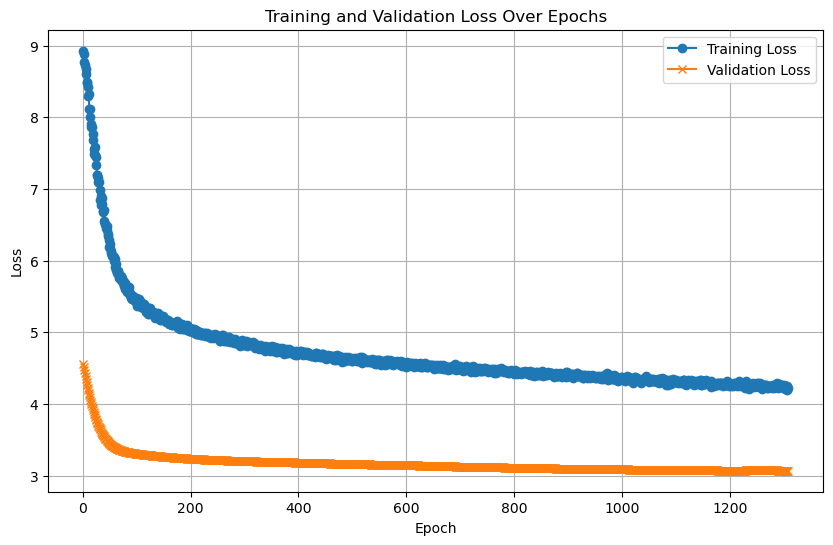

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/38], Loss: 4.6835
Test Batch [20/38], Loss: 4.6562
Test Batch [30/38], Loss: 5.2184

Test Loss: 4.8851


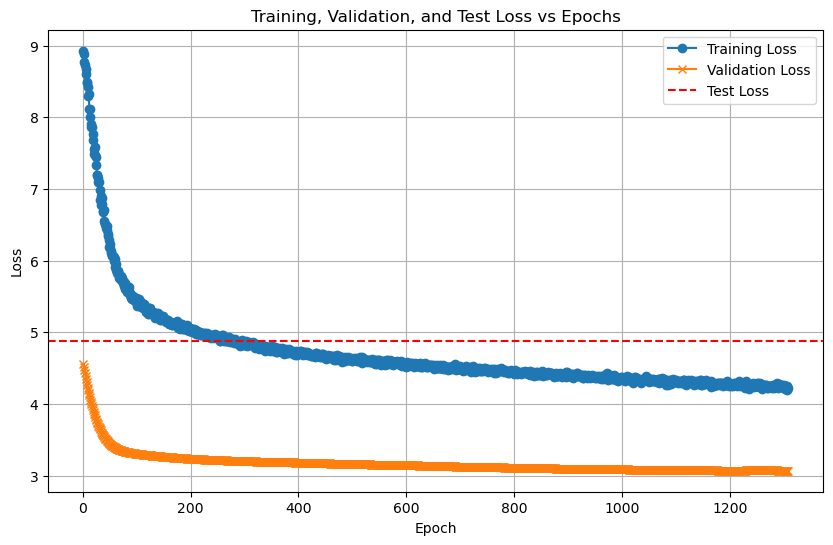

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.


  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 62.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.60      0.60      0.60         5
           2       0.50      0.80      0.62         5
           3       0.80      0.80      0.80         5
           4       0.25      0.20      0.22         5
           5       0.50      0.40      0.44         5
           6       0.00      0.00      0.00         0
           7       0.80      0.80      0.80         5
           9       0.50      0.60      0.55         5
          10       0.67      0.80      0.73         5
          11       1.00      0.20      0.33         5
          12       0.71      1.00      0.83         5
          13       0.50      0.20      0.29         5
          14       0.4

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8140  |  Val Loss: 2.8105
Validation loss improved from inf to 2.8105.
[Epoch 2/1000] Train Loss: 2.7839  |  Val Loss: 2.7764
Validation loss improved from 2.8105 to 2.7764.
[Epoch 3/1000] Train Loss: 2.7575  |  Val Loss: 2.7454
Validation loss improved from 2.7764 to 2.7454.
[Epoch 4/1000] Train Loss: 2.7335  |  Val Loss: 2.7151
Validation loss improved from 2.7454 to 2.7151.


[Epoch 5/1000] Train Loss: 2.7078  |  Val Loss: 2.6877
Validation loss improved from 2.7151 to 2.6877.
[Epoch 6/1000] Train Loss: 2.6855  |  Val Loss: 2.6628
Validation loss improved from 2.6877 to 2.6628.
[Epoch 7/1000] Train Loss: 2.6644  |  Val Loss: 2.6400
Validation loss improved from 2.6628 to 2.6400.
[Epoch 8/1000] Train Loss: 2.6452  |  Val Loss: 2.6195
Validation loss improved from 2.6400 to 2.6195.
[Epoch 9/1000] Train Loss: 2.6268  |  Val Loss: 2.5998
Validation loss improved from 2.6195 to 2.5998.
[Epoch 10/1000] Train Loss: 2.6087  |  Val Loss: 2.5783
Validation loss improved from 2.5998 to 2.5783.
[Epoch 11/1000] Train Loss: 2.5910  |  Val Loss: 2.5567
Validation loss improved from 2.5783 to 2.5567.
[Epoch 12/1000] Train Loss: 2.5732  |  Val Loss: 2.5344
Validation loss improved from 2.5567 to 2.5344.
[Epoch 13/1000] Train Loss: 2.5548  |  Val Loss: 2.5121
Validation loss improved from 2.5344 to 2.5121.
[Epoch 14/1000] Train Loss: 2.5360  |  Val Loss: 2.4904
Validation lo

[Epoch 19/1000] Train Loss: 2.4507  |  Val Loss: 2.3850
Validation loss improved from 2.4057 to 2.3850.
[Epoch 20/1000] Train Loss: 2.4340  |  Val Loss: 2.3654
Validation loss improved from 2.3850 to 2.3654.
[Epoch 21/1000] Train Loss: 2.4167  |  Val Loss: 2.3467
Validation loss improved from 2.3654 to 2.3467.
[Epoch 22/1000] Train Loss: 2.4005  |  Val Loss: 2.3278
Validation loss improved from 2.3467 to 2.3278.
[Epoch 23/1000] Train Loss: 2.3831  |  Val Loss: 2.3095
Validation loss improved from 2.3278 to 2.3095.
[Epoch 24/1000] Train Loss: 2.3661  |  Val Loss: 2.2913
Validation loss improved from 2.3095 to 2.2913.
[Epoch 25/1000] Train Loss: 2.3494  |  Val Loss: 2.2729
Validation loss improved from 2.2913 to 2.2729.
[Epoch 26/1000] Train Loss: 2.3320  |  Val Loss: 2.2544
Validation loss improved from 2.2729 to 2.2544.


[Epoch 27/1000] Train Loss: 2.3146  |  Val Loss: 2.2360
Validation loss improved from 2.2544 to 2.2360.
[Epoch 28/1000] Train Loss: 2.2973  |  Val Loss: 2.2177
Validation loss improved from 2.2360 to 2.2177.
[Epoch 29/1000] Train Loss: 2.2797  |  Val Loss: 2.1996
Validation loss improved from 2.2177 to 2.1996.
[Epoch 30/1000] Train Loss: 2.2621  |  Val Loss: 2.1812
Validation loss improved from 2.1996 to 2.1812.
[Epoch 31/1000] Train Loss: 2.2438  |  Val Loss: 2.1627
Validation loss improved from 2.1812 to 2.1627.
[Epoch 32/1000] Train Loss: 2.2255  |  Val Loss: 2.1445
Validation loss improved from 2.1627 to 2.1445.
[Epoch 33/1000] Train Loss: 2.2078  |  Val Loss: 2.1255
Validation loss improved from 2.1445 to 2.1255.
[Epoch 34/1000] Train Loss: 2.1891  |  Val Loss: 2.1068
Validation loss improved from 2.1255 to 2.1068.
[Epoch 35/1000] Train Loss: 2.1711  |  Val Loss: 2.0880
Validation loss improved from 2.1068 to 2.0880.
[Epoch 36/1000] Train Loss: 2.1522  |  Val Loss: 2.0693
Validati

[Epoch 39/1000] Train Loss: 2.0952  |  Val Loss: 2.0138
Validation loss improved from 2.0325 to 2.0138.
[Epoch 40/1000] Train Loss: 2.0776  |  Val Loss: 1.9946
Validation loss improved from 2.0138 to 1.9946.
[Epoch 41/1000] Train Loss: 2.0592  |  Val Loss: 1.9753
Validation loss improved from 1.9946 to 1.9753.
[Epoch 42/1000] Train Loss: 2.0405  |  Val Loss: 1.9566
Validation loss improved from 1.9753 to 1.9566.
[Epoch 43/1000] Train Loss: 2.0225  |  Val Loss: 1.9381
Validation loss improved from 1.9566 to 1.9381.


[Epoch 44/1000] Train Loss: 2.0046  |  Val Loss: 1.9197
Validation loss improved from 1.9381 to 1.9197.
[Epoch 45/1000] Train Loss: 1.9866  |  Val Loss: 1.9014
Validation loss improved from 1.9197 to 1.9014.
[Epoch 46/1000] Train Loss: 1.9690  |  Val Loss: 1.8829
Validation loss improved from 1.9014 to 1.8829.
[Epoch 47/1000] Train Loss: 1.9508  |  Val Loss: 1.8645
Validation loss improved from 1.8829 to 1.8645.
[Epoch 48/1000] Train Loss: 1.9329  |  Val Loss: 1.8460
Validation loss improved from 1.8645 to 1.8460.
[Epoch 49/1000] Train Loss: 1.9158  |  Val Loss: 1.8280
Validation loss improved from 1.8460 to 1.8280.
[Epoch 50/1000] Train Loss: 1.8980  |  Val Loss: 1.8107
Validation loss improved from 1.8280 to 1.8107.
[Epoch 51/1000] Train Loss: 1.8814  |  Val Loss: 1.7932
Validation loss improved from 1.8107 to 1.7932.
[Epoch 52/1000] Train Loss: 1.8639  |  Val Loss: 1.7770
Validation loss improved from 1.7932 to 1.7770.
[Epoch 53/1000] Train Loss: 1.8470  |  Val Loss: 1.7606
Validati

[Epoch 58/1000] Train Loss: 1.7651  |  Val Loss: 1.6831
Validation loss improved from 1.6980 to 1.6831.
[Epoch 59/1000] Train Loss: 1.7500  |  Val Loss: 1.6682
Validation loss improved from 1.6831 to 1.6682.
[Epoch 60/1000] Train Loss: 1.7340  |  Val Loss: 1.6536
Validation loss improved from 1.6682 to 1.6536.


[Epoch 61/1000] Train Loss: 1.7194  |  Val Loss: 1.6393
Validation loss improved from 1.6536 to 1.6393.
[Epoch 62/1000] Train Loss: 1.7039  |  Val Loss: 1.6247
Validation loss improved from 1.6393 to 1.6247.
[Epoch 63/1000] Train Loss: 1.6889  |  Val Loss: 1.6118
Validation loss improved from 1.6247 to 1.6118.
[Epoch 64/1000] Train Loss: 1.6751  |  Val Loss: 1.5988
Validation loss improved from 1.6118 to 1.5988.
[Epoch 65/1000] Train Loss: 1.6606  |  Val Loss: 1.5861
Validation loss improved from 1.5988 to 1.5861.
[Epoch 66/1000] Train Loss: 1.6470  |  Val Loss: 1.5730
Validation loss improved from 1.5861 to 1.5730.
[Epoch 67/1000] Train Loss: 1.6329  |  Val Loss: 1.5602
Validation loss improved from 1.5730 to 1.5602.
[Epoch 68/1000] Train Loss: 1.6202  |  Val Loss: 1.5484
Validation loss improved from 1.5602 to 1.5484.
[Epoch 69/1000] Train Loss: 1.6076  |  Val Loss: 1.5371
Validation loss improved from 1.5484 to 1.5371.
[Epoch 70/1000] Train Loss: 1.5948  |  Val Loss: 1.5254
Validati

[Epoch 77/1000] Train Loss: 1.5122  |  Val Loss: 1.4562
Validation loss improved from 1.4656 to 1.4562.
[Epoch 78/1000] Train Loss: 1.5019  |  Val Loss: 1.4478
Validation loss improved from 1.4562 to 1.4478.
[Epoch 79/1000] Train Loss: 1.4918  |  Val Loss: 1.4405
Validation loss improved from 1.4478 to 1.4405.
[Epoch 80/1000] Train Loss: 1.4810  |  Val Loss: 1.4324
Validation loss improved from 1.4405 to 1.4324.
[Epoch 81/1000] Train Loss: 1.4728  |  Val Loss: 1.4235
Validation loss improved from 1.4324 to 1.4235.
[Epoch 82/1000] Train Loss: 1.4618  |  Val Loss: 1.4163
Validation loss improved from 1.4235 to 1.4163.
[Epoch 83/1000] Train Loss: 1.4517  |  Val Loss: 1.4075
Validation loss improved from 1.4163 to 1.4075.
[Epoch 84/1000] Train Loss: 1.4426  |  Val Loss: 1.4004
Validation loss improved from 1.4075 to 1.4004.
[Epoch 85/1000] Train Loss: 1.4324  |  Val Loss: 1.3930
Validation loss improved from 1.4004 to 1.3930.
[Epoch 86/1000] Train Loss: 1.4235  |  Val Loss: 1.3868
Validati

[Epoch 98/1000] Train Loss: 1.3238  |  Val Loss: 1.3179
Validation loss improved from 1.3241 to 1.3179.
[Epoch 99/1000] Train Loss: 1.3160  |  Val Loss: 1.3126
Validation loss improved from 1.3179 to 1.3126.
[Epoch 100/1000] Train Loss: 1.3078  |  Val Loss: 1.3076
Validation loss improved from 1.3126 to 1.3076.
[Epoch 101/1000] Train Loss: 1.3011  |  Val Loss: 1.3030
Validation loss improved from 1.3076 to 1.3030.
[Epoch 102/1000] Train Loss: 1.2933  |  Val Loss: 1.2973
Validation loss improved from 1.3030 to 1.2973.
[Epoch 103/1000] Train Loss: 1.2857  |  Val Loss: 1.2931
Validation loss improved from 1.2973 to 1.2931.
[Epoch 104/1000] Train Loss: 1.2792  |  Val Loss: 1.2888
Validation loss improved from 1.2931 to 1.2888.
[Epoch 105/1000] Train Loss: 1.2718  |  Val Loss: 1.2858
Validation loss improved from 1.2888 to 1.2858.
[Epoch 106/1000] Train Loss: 1.2650  |  Val Loss: 1.2812
Validation loss improved from 1.2858 to 1.2812.
[Epoch 107/1000] Train Loss: 1.2582  |  Val Loss: 1.2786


[Epoch 117/1000] Train Loss: 1.1961  |  Val Loss: 1.2446
Validation loss improved from 1.2453 to 1.2446.
[Epoch 118/1000] Train Loss: 1.1906  |  Val Loss: 1.2429
Validation loss improved from 1.2446 to 1.2429.
[Epoch 119/1000] Train Loss: 1.1853  |  Val Loss: 1.2399
Validation loss improved from 1.2429 to 1.2399.
[Epoch 120/1000] Train Loss: 1.1789  |  Val Loss: 1.2355
Validation loss improved from 1.2399 to 1.2355.
[Epoch 121/1000] Train Loss: 1.1742  |  Val Loss: 1.2326
Validation loss improved from 1.2355 to 1.2326.
[Epoch 122/1000] Train Loss: 1.1682  |  Val Loss: 1.2282
Validation loss improved from 1.2326 to 1.2282.
[Epoch 123/1000] Train Loss: 1.1627  |  Val Loss: 1.2259
Validation loss improved from 1.2282 to 1.2259.
[Epoch 124/1000] Train Loss: 1.1571  |  Val Loss: 1.2241
Validation loss improved from 1.2259 to 1.2241.
[Epoch 125/1000] Train Loss: 1.1521  |  Val Loss: 1.2231
Validation loss improved from 1.2241 to 1.2231.
[Epoch 126/1000] Train Loss: 1.1469  |  Val Loss: 1.219

[Epoch 135/1000] Train Loss: 1.1012  |  Val Loss: 1.1999
Validation loss improved from 1.2000 to 1.1999.
[Epoch 136/1000] Train Loss: 1.0969  |  Val Loss: 1.1960
Validation loss improved from 1.1999 to 1.1960.
[Epoch 137/1000] Train Loss: 1.0925  |  Val Loss: 1.1952
Validation loss improved from 1.1960 to 1.1952.
[Epoch 138/1000] Train Loss: 1.0872  |  Val Loss: 1.1945
Validation loss improved from 1.1952 to 1.1945.
[Epoch 139/1000] Train Loss: 1.0825  |  Val Loss: 1.1914
Validation loss improved from 1.1945 to 1.1914.
[Epoch 140/1000] Train Loss: 1.0778  |  Val Loss: 1.1891
Validation loss improved from 1.1914 to 1.1891.
[Epoch 141/1000] Train Loss: 1.0734  |  Val Loss: 1.1895
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.0689  |  Val Loss: 1.1882
Validation loss improved from 1.1891 to 1.1882.
[Epoch 143/1000] Train Loss: 1.0651  |  Val Loss: 1.1859
Validation loss improved from 1.1882 to 1.1859.
[Epoch 144/1000] Train Loss: 1.0601  |  Val Loss:

[Epoch 155/1000] Train Loss: 1.0164  |  Val Loss: 1.1688
Validation loss improved from 1.1705 to 1.1688.
[Epoch 156/1000] Train Loss: 1.0119  |  Val Loss: 1.1681
Validation loss improved from 1.1688 to 1.1681.
[Epoch 157/1000] Train Loss: 1.0089  |  Val Loss: 1.1666
Validation loss improved from 1.1681 to 1.1666.
[Epoch 158/1000] Train Loss: 1.0049  |  Val Loss: 1.1660
Validation loss improved from 1.1666 to 1.1660.
[Epoch 159/1000] Train Loss: 1.0016  |  Val Loss: 1.1639
Validation loss improved from 1.1660 to 1.1639.
[Epoch 160/1000] Train Loss: 0.9975  |  Val Loss: 1.1644
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 0.9935  |  Val Loss: 1.1619
Validation loss improved from 1.1639 to 1.1619.
[Epoch 162/1000] Train Loss: 0.9910  |  Val Loss: 1.1626
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 0.9870  |  Val Loss: 1.1601
Validation loss improved from 1.1619 to 1.1601.
[Epoch 164/1000] Train Loss: 0.9844  |  Val

[Epoch 174/1000] Train Loss: 0.9509  |  Val Loss: 1.1494
Validation loss improved from 1.1502 to 1.1494.
[Epoch 175/1000] Train Loss: 0.9476  |  Val Loss: 1.1491
Validation loss improved from 1.1494 to 1.1491.
[Epoch 176/1000] Train Loss: 0.9457  |  Val Loss: 1.1476
Validation loss improved from 1.1491 to 1.1476.
[Epoch 177/1000] Train Loss: 0.9420  |  Val Loss: 1.1473
Validation loss improved from 1.1476 to 1.1473.
[Epoch 178/1000] Train Loss: 0.9384  |  Val Loss: 1.1464
Validation loss improved from 1.1473 to 1.1464.
[Epoch 179/1000] Train Loss: 0.9357  |  Val Loss: 1.1461
Validation loss improved from 1.1464 to 1.1461.
[Epoch 180/1000] Train Loss: 0.9324  |  Val Loss: 1.1453
Validation loss improved from 1.1461 to 1.1453.
[Epoch 181/1000] Train Loss: 0.9295  |  Val Loss: 1.1457
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 182/1000] Train Loss: 0.9266  |  Val Loss: 1.1463
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 183/1000] Train Loss: 0.9238  |  Val

[Epoch 193/1000] Train Loss: 0.8974  |  Val Loss: 1.1368
Validation loss improved from 1.1379 to 1.1368.
[Epoch 194/1000] Train Loss: 0.8949  |  Val Loss: 1.1351
Validation loss improved from 1.1368 to 1.1351.
[Epoch 195/1000] Train Loss: 0.8921  |  Val Loss: 1.1354
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 0.8904  |  Val Loss: 1.1353
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 197/1000] Train Loss: 0.8866  |  Val Loss: 1.1337
Validation loss improved from 1.1351 to 1.1337.
[Epoch 198/1000] Train Loss: 0.8841  |  Val Loss: 1.1337
Validation loss improved from 1.1337 to 1.1337.
[Epoch 199/1000] Train Loss: 0.8827  |  Val Loss: 1.1309
Validation loss improved from 1.1337 to 1.1309.
[Epoch 200/1000] Train Loss: 0.8797  |  Val Loss: 1.1314
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 0.8771  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 0.

[Epoch 212/1000] Train Loss: 0.8525  |  Val Loss: 1.1239
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 0.8504  |  Val Loss: 1.1230
Validation loss improved from 1.1237 to 1.1230.
[Epoch 214/1000] Train Loss: 0.8479  |  Val Loss: 1.1228
Validation loss improved from 1.1230 to 1.1228.
[Epoch 215/1000] Train Loss: 0.8472  |  Val Loss: 1.1243
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.8438  |  Val Loss: 1.1218
Validation loss improved from 1.1228 to 1.1218.
[Epoch 217/1000] Train Loss: 0.8421  |  Val Loss: 1.1198
Validation loss improved from 1.1218 to 1.1198.
[Epoch 218/1000] Train Loss: 0.8401  |  Val Loss: 1.1188
Validation loss improved from 1.1198 to 1.1188.
[Epoch 219/1000] Train Loss: 0.8380  |  Val Loss: 1.1196
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 220/1000] Train Loss: 0.8370  |  Val Loss: 1.1200
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 221/1000] Train Loss: 0.

[Epoch 230/1000] Train Loss: 0.8177  |  Val Loss: 1.1182
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 231/1000] Train Loss: 0.8161  |  Val Loss: 1.1120
Validation loss improved from 1.1125 to 1.1120.
[Epoch 232/1000] Train Loss: 0.8138  |  Val Loss: 1.1118
Validation loss improved from 1.1120 to 1.1118.
[Epoch 233/1000] Train Loss: 0.8126  |  Val Loss: 1.1117
Validation loss improved from 1.1118 to 1.1117.
[Epoch 234/1000] Train Loss: 0.8106  |  Val Loss: 1.1146
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.8087  |  Val Loss: 1.1167
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 0.8072  |  Val Loss: 1.1142
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 237/1000] Train Loss: 0.8053  |  Val Loss: 1.1113
Validation loss improved from 1.1117 to 1.1113.
[Epoch 238/1000] Train Loss: 0.8048  |  Val Loss: 1.1094
Validation loss improved from 1.1113 to 1.1094.
[Epoch 239/1000] Train Loss: 0.

[Epoch 250/1000] Train Loss: 0.7850  |  Val Loss: 1.1052
Validation loss improved from 1.1073 to 1.1052.
[Epoch 251/1000] Train Loss: 0.7834  |  Val Loss: 1.1055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.7814  |  Val Loss: 1.1065
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.7806  |  Val Loss: 1.1092
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.7795  |  Val Loss: 1.1039
Validation loss improved from 1.1052 to 1.1039.
[Epoch 255/1000] Train Loss: 0.7776  |  Val Loss: 1.1065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 0.7767  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 0.7753  |  Val Loss: 1.1064
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 0.7734  |  Val Loss: 1.1071
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/10

[Epoch 269/1000] Train Loss: 0.7585  |  Val Loss: 1.1018
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 270/1000] Train Loss: 0.7563  |  Val Loss: 1.1004
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 271/1000] Train Loss: 0.7553  |  Val Loss: 1.0991
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 272/1000] Train Loss: 0.7539  |  Val Loss: 1.0984
Validation loss improved from 1.0987 to 1.0984.
[Epoch 273/1000] Train Loss: 0.7530  |  Val Loss: 1.0989
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.7510  |  Val Loss: 1.1000
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 0.7499  |  Val Loss: 1.1007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 0.7490  |  Val Loss: 1.0999
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 0.7474  |  Val Loss: 1.0981
Validation loss improved from 1.0984 to 1.0981.
[Epoch 278/10

[Epoch 287/1000] Train Loss: 0.7347  |  Val Loss: 1.0943
Validation loss improved from 1.0945 to 1.0943.
[Epoch 288/1000] Train Loss: 0.7334  |  Val Loss: 1.0960
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 0.7322  |  Val Loss: 1.0947
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 290/1000] Train Loss: 0.7314  |  Val Loss: 1.0927
Validation loss improved from 1.0943 to 1.0927.
[Epoch 291/1000] Train Loss: 0.7300  |  Val Loss: 1.0956
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 0.7294  |  Val Loss: 1.0937
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 293/1000] Train Loss: 0.7269  |  Val Loss: 1.0935
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Train Loss: 0.7261  |  Val Loss: 1.0948
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 295/1000] Train Loss: 0.7256  |  Val Loss: 1.0932
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 296/10

[Epoch 307/1000] Train Loss: 0.7131  |  Val Loss: 1.0900
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 308/1000] Train Loss: 0.7125  |  Val Loss: 1.0908
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 309/1000] Train Loss: 0.7102  |  Val Loss: 1.0879
Validation loss improved from 1.0887 to 1.0879.
[Epoch 310/1000] Train Loss: 0.7099  |  Val Loss: 1.0900
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 311/1000] Train Loss: 0.7097  |  Val Loss: 1.0920
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 312/1000] Train Loss: 0.7079  |  Val Loss: 1.0887
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 313/1000] Train Loss: 0.7059  |  Val Loss: 1.0880
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 314/1000] Train Loss: 0.7059  |  Val Loss: 1.0854
Validation loss improved from 1.0879 to 1.0854.
[Epoch 315/1000] Train Loss: 0.7039  |  Val Loss: 1.0861
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 316/

[Epoch 324/1000] Train Loss: 0.6954  |  Val Loss: 1.0855
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 0.6943  |  Val Loss: 1.0836
Validation loss improved from 1.0836 to 1.0836.
[Epoch 326/1000] Train Loss: 0.6932  |  Val Loss: 1.0858
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 327/1000] Train Loss: 0.6929  |  Val Loss: 1.0858
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 328/1000] Train Loss: 0.6919  |  Val Loss: 1.0846
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 329/1000] Train Loss: 0.6923  |  Val Loss: 1.0825
Validation loss improved from 1.0836 to 1.0825.
[Epoch 330/1000] Train Loss: 0.6910  |  Val Loss: 1.0796
Validation loss improved from 1.0825 to 1.0796.
[Epoch 331/1000] Train Loss: 0.6889  |  Val Loss: 1.0819
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 332/1000] Train Loss: 0.6881  |  Val Loss: 1.0814
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 333/1000] Tr

[Epoch 343/1000] Train Loss: 0.6800  |  Val Loss: 1.0779
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/1000] Train Loss: 0.6789  |  Val Loss: 1.0796
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 345/1000] Train Loss: 0.6781  |  Val Loss: 1.0791
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 346/1000] Train Loss: 0.6768  |  Val Loss: 1.0776
Validation loss improved from 1.0776 to 1.0776.
[Epoch 347/1000] Train Loss: 0.6762  |  Val Loss: 1.0787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 0.6751  |  Val Loss: 1.0780
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Train Loss: 0.6755  |  Val Loss: 1.0817
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 350/1000] Train Loss: 0.6732  |  Val Loss: 1.0778
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 351/1000] Train Loss: 0.6734  |  Val Loss: 1.0790
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 361/1000] Train Loss: 0.6648  |  Val Loss: 1.0724
Validation loss improved from 1.0739 to 1.0724.
[Epoch 362/1000] Train Loss: 0.6645  |  Val Loss: 1.0755
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 363/1000] Train Loss: 0.6639  |  Val Loss: 1.0750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 364/1000] Train Loss: 0.6630  |  Val Loss: 1.0746
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 365/1000] Train Loss: 0.6625  |  Val Loss: 1.0764
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 366/1000] Train Loss: 0.6632  |  Val Loss: 1.0747
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 367/1000] Train Loss: 0.6605  |  Val Loss: 1.0716
Validation loss improved from 1.0724 to 1.0716.
[Epoch 368/1000] Train Loss: 0.6601  |  Val Loss: 1.0709
Validation loss improved from 1.0716 to 1.0709.
[Epoch 369/1000] Train Loss: 0.6591  |  Val Loss: 1.0713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Tr

[Epoch 380/1000] Train Loss: 0.6529  |  Val Loss: 1.0747
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 381/1000] Train Loss: 0.6510  |  Val Loss: 1.0698
Validation loss improved from 1.0709 to 1.0698.
[Epoch 382/1000] Train Loss: 0.6502  |  Val Loss: 1.0687
Validation loss improved from 1.0698 to 1.0687.
[Epoch 383/1000] Train Loss: 0.6507  |  Val Loss: 1.0664
Validation loss improved from 1.0687 to 1.0664.
[Epoch 384/1000] Train Loss: 0.6494  |  Val Loss: 1.0696
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 385/1000] Train Loss: 0.6488  |  Val Loss: 1.0710
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 386/1000] Train Loss: 0.6474  |  Val Loss: 1.0726
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 387/1000] Train Loss: 0.6472  |  Val Loss: 1.0708
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 388/1000] Train Loss: 0.6458  |  Val Loss: 1.0705
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 389/1000] T

[Epoch 399/1000] Train Loss: 0.6398  |  Val Loss: 1.0716
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 400/1000] Train Loss: 0.6397  |  Val Loss: 1.0714
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 401/1000] Train Loss: 0.6386  |  Val Loss: 1.0681
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 402/1000] Train Loss: 0.6382  |  Val Loss: 1.0664
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 403/1000] Train Loss: 0.6381  |  Val Loss: 1.0690
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 404/1000] Train Loss: 0.6364  |  Val Loss: 1.0703
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 405/1000] Train Loss: 0.6366  |  Val Loss: 1.0718
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 406/1000] Train Loss: 0.6362  |  Val Loss: 1.0714
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 407/1000] Train Loss: 0.6353  |  Val Loss: 1.0681
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 415/1000] Train Loss: 0.6303  |  Val Loss: 1.0707
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 416/1000] Train Loss: 0.6290  |  Val Loss: 1.0693
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 417/1000] Train Loss: 0.6300  |  Val Loss: 1.0680
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 418/1000] Train Loss: 0.6284  |  Val Loss: 1.0665
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 419/1000] Train Loss: 0.6282  |  Val Loss: 1.0649
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 420/1000] Train Loss: 0.6274  |  Val Loss: 1.0648
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 421/1000] Train Loss: 0.6263  |  Val Loss: 1.0669
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 422/1000] Train Loss: 0.6263  |  Val Loss: 1.0653
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 423/1000] Train Loss: 0.6265  |  Val Loss: 1.0660
!! Validation loss did NOT improve !! Patience: 15

[Epoch 437/1000] Train Loss: 0.6176  |  Val Loss: 1.0673
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 438/1000] Train Loss: 0.6176  |  Val Loss: 1.0695
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 439/1000] Train Loss: 0.6172  |  Val Loss: 1.0681
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 440/1000] Train Loss: 0.6177  |  Val Loss: 1.0643
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 441/1000] Train Loss: 0.6159  |  Val Loss: 1.0624
Validation loss improved from 1.0637 to 1.0624.
[Epoch 442/1000] Train Loss: 0.6151  |  Val Loss: 1.0675
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 443/1000] Train Loss: 0.6152  |  Val Loss: 1.0664
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 444/1000] Train Loss: 0.6145  |  Val Loss: 1.0639
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 445/1000] Train Loss: 0.6143  |  Val Loss: 1.0643
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 455/1000] Train Loss: 0.6093  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 456/1000] Train Loss: 0.6086  |  Val Loss: 1.0665
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 457/1000] Train Loss: 0.6087  |  Val Loss: 1.0640
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 458/1000] Train Loss: 0.6074  |  Val Loss: 1.0627
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 459/1000] Train Loss: 0.6067  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 460/1000] Train Loss: 0.6066  |  Val Loss: 1.0646
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 461/1000] Train Loss: 0.6058  |  Val Loss: 1.0634
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 462/1000] Train Loss: 0.6054  |  Val Loss: 1.0675
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 463/1000] Train Loss: 0.6062  |  Val Loss: 1.0662
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 475/1000] Train Loss: 0.5988  |  Val Loss: 1.0609
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 476/1000] Train Loss: 0.5992  |  Val Loss: 1.0630
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 477/1000] Train Loss: 0.5996  |  Val Loss: 1.0631
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 478/1000] Train Loss: 0.5983  |  Val Loss: 1.0601
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 479/1000] Train Loss: 0.5968  |  Val Loss: 1.0608
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 480/1000] Train Loss: 0.5967  |  Val Loss: 1.0615
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 481/1000] Train Loss: 0.5971  |  Val Loss: 1.0575
Validation loss improved from 1.0583 to 1.0575.
[Epoch 482/1000] Train Loss: 0.5960  |  Val Loss: 1.0577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 483/1000] Train Loss: 0.5957  |  Val Loss: 1.0596
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 495/1000] Train Loss: 0.5898  |  Val Loss: 1.0592
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 496/1000] Train Loss: 0.5906  |  Val Loss: 1.0601
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 497/1000] Train Loss: 0.5892  |  Val Loss: 1.0605
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 498/1000] Train Loss: 0.5883  |  Val Loss: 1.0589
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 499/1000] Train Loss: 0.5892  |  Val Loss: 1.0571
Validation loss improved from 1.0575 to 1.0571.
[Epoch 500/1000] Train Loss: 0.5896  |  Val Loss: 1.0578
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 501/1000] Train Loss: 0.5872  |  Val Loss: 1.0581
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 502/1000] Train Loss: 0.5868  |  Val Loss: 1.0605
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 503/1000] Train Loss: 0.5868  |  Val Loss: 1.0596
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 514/1000] Train Loss: 0.5820  |  Val Loss: 1.0557
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 515/1000] Train Loss: 0.5817  |  Val Loss: 1.0580
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 516/1000] Train Loss: 0.5819  |  Val Loss: 1.0609
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 517/1000] Train Loss: 0.5807  |  Val Loss: 1.0611
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 518/1000] Train Loss: 0.5822  |  Val Loss: 1.0574
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 519/1000] Train Loss: 0.5802  |  Val Loss: 1.0572
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 520/1000] Train Loss: 0.5802  |  Val Loss: 1.0582
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 521/1000] Train Loss: 0.5800  |  Val Loss: 1.0562
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 522/1000] Train Loss: 0.5789  |  Val Loss: 1.0572
!! Validation loss did NOT improve !! Patience: 

[Epoch 533/1000] Train Loss: 0.5746  |  Val Loss: 1.0555
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 534/1000] Train Loss: 0.5745  |  Val Loss: 1.0565
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 535/1000] Train Loss: 0.5745  |  Val Loss: 1.0541
Validation loss improved from 1.0544 to 1.0541.
[Epoch 536/1000] Train Loss: 0.5745  |  Val Loss: 1.0528
Validation loss improved from 1.0541 to 1.0528.
[Epoch 537/1000] Train Loss: 0.5750  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 538/1000] Train Loss: 0.5743  |  Val Loss: 1.0530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 539/1000] Train Loss: 0.5742  |  Val Loss: 1.0562
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 540/1000] Train Loss: 0.5719  |  Val Loss: 1.0563
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 541/1000] Train Loss: 0.5720  |  Val Loss: 1.0558
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 542/

[Epoch 552/1000] Train Loss: 0.5677  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 553/1000] Train Loss: 0.5678  |  Val Loss: 1.0533
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 554/1000] Train Loss: 0.5663  |  Val Loss: 1.0554
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 555/1000] Train Loss: 0.5664  |  Val Loss: 1.0526
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 556/1000] Train Loss: 0.5661  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 557/1000] Train Loss: 0.5657  |  Val Loss: 1.0591
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 558/1000] Train Loss: 0.5654  |  Val Loss: 1.0588
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 559/1000] Train Loss: 0.5648  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 560/1000] Train Loss: 0.5655  |  Val Loss: 1.0562
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 571/1000] Train Loss: 0.5607  |  Val Loss: 1.0549
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 572/1000] Train Loss: 0.5624  |  Val Loss: 1.0551
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 573/1000] Train Loss: 0.5607  |  Val Loss: 1.0543
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 574/1000] Train Loss: 0.5600  |  Val Loss: 1.0519
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 575/1000] Train Loss: 0.5600  |  Val Loss: 1.0548
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 576/1000] Train Loss: 0.5598  |  Val Loss: 1.0529
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 577/1000] Train Loss: 0.5585  |  Val Loss: 1.0560
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 578/1000] Train Loss: 0.5590  |  Val Loss: 1.0541
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 579/1000] Train Loss: 0.5603  |  Val Loss: 1.0523
!! Validation loss did NOT improve !! Patience: 15

[Epoch 590/1000] Train Loss: 0.5551  |  Val Loss: 1.0548
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 591/1000] Train Loss: 0.5553  |  Val Loss: 1.0532
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 592/1000] Train Loss: 0.5540  |  Val Loss: 1.0538
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 593/1000] Train Loss: 0.5532  |  Val Loss: 1.0566
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 594/1000] Train Loss: 0.5537  |  Val Loss: 1.0518
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 595/1000] Train Loss: 0.5525  |  Val Loss: 1.0537
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 596/1000] Train Loss: 0.5520  |  Val Loss: 1.0518
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 597/1000] Train Loss: 0.5516  |  Val Loss: 1.0538
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 598/1000] Train Loss: 0.5511  |  Val Loss: 1.0524
!! Validation loss did NOT improve !! Patience: 1

[Epoch 610/1000] Train Loss: 0.5480  |  Val Loss: 1.0533
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 611/1000] Train Loss: 0.5479  |  Val Loss: 1.0524
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 612/1000] Train Loss: 0.5469  |  Val Loss: 1.0513
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 613/1000] Train Loss: 0.5467  |  Val Loss: 1.0541
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 614/1000] Train Loss: 0.5466  |  Val Loss: 1.0550
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 615/1000] Train Loss: 0.5459  |  Val Loss: 1.0525
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 616/1000] Train Loss: 0.5456  |  Val Loss: 1.0513
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 617/1000] Train Loss: 0.5461  |  Val Loss: 1.0505
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 618/1000] Train Loss: 0.5457  |  Val Loss: 1.0531
!! Validation loss did NOT improve !! Patience:

[Epoch 628/1000] Train Loss: 0.5426  |  Val Loss: 1.0526
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 629/1000] Train Loss: 0.5424  |  Val Loss: 1.0504
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 630/1000] Train Loss: 0.5420  |  Val Loss: 1.0538
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 631/1000] Train Loss: 0.5415  |  Val Loss: 1.0524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 632/1000] Train Loss: 0.5414  |  Val Loss: 1.0497
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 633/1000] Train Loss: 0.5415  |  Val Loss: 1.0545
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 634/1000] Train Loss: 0.5409  |  Val Loss: 1.0525
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 635/1000] Train Loss: 0.5401  |  Val Loss: 1.0550
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 636/1000] Train Loss: 0.5401  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 648/1000] Train Loss: 0.5363  |  Val Loss: 1.0520
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 649/1000] Train Loss: 0.5356  |  Val Loss: 1.0567
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 650/1000] Train Loss: 0.5356  |  Val Loss: 1.0570
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 651/1000] Train Loss: 0.5361  |  Val Loss: 1.0546
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 652/1000] Train Loss: 0.5348  |  Val Loss: 1.0545
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 653/1000] Train Loss: 0.5346  |  Val Loss: 1.0537
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 654/1000] Train Loss: 0.5352  |  Val Loss: 1.0547
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 655/1000] Train Loss: 0.5343  |  Val Loss: 1.0542
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 656/1000] Train Loss: 0.5336  |  Val Loss: 1.0536
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 666/1000] Train Loss: 0.5312  |  Val Loss: 1.0580
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 667/1000] Train Loss: 0.5305  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 668/1000] Train Loss: 0.5313  |  Val Loss: 1.0522
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 669/1000] Train Loss: 0.5298  |  Val Loss: 1.0564
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 670/1000] Train Loss: 0.5306  |  Val Loss: 1.0548
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 671/1000] Train Loss: 0.5293  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 672/1000] Train Loss: 0.5292  |  Val Loss: 1.0535
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 673/1000] Train Loss: 0.5288  |  Val Loss: 1.0549
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 674/1000] Train Loss: 0.5285  |  Val Loss: 1.0543
!! Validation loss did NOT improve !! Patience:

[Epoch 686/1000] Train Loss: 0.5260  |  Val Loss: 1.0596
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 687/1000] Train Loss: 0.5249  |  Val Loss: 1.0585
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 688/1000] Train Loss: 0.5243  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 689/1000] Train Loss: 0.5245  |  Val Loss: 1.0542
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 690/1000] Train Loss: 0.5244  |  Val Loss: 1.0527
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 691/1000] Train Loss: 0.5239  |  Val Loss: 1.0535
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 692/1000] Train Loss: 0.5246  |  Val Loss: 1.0570
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 693/1000] Train Loss: 0.5237  |  Val Loss: 1.0550
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 694/1000] Train Loss: 0.5229  |  Val Loss: 1.0528
!! Validation loss did NOT improve !! Patience:

[Epoch 705/1000] Train Loss: 0.5208  |  Val Loss: 1.0549
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 706/1000] Train Loss: 0.5204  |  Val Loss: 1.0547
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 707/1000] Train Loss: 0.5193  |  Val Loss: 1.0564
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 708/1000] Train Loss: 0.5193  |  Val Loss: 1.0559
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 709/1000] Train Loss: 0.5190  |  Val Loss: 1.0565
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 710/1000] Train Loss: 0.5184  |  Val Loss: 1.0563
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 711/1000] Train Loss: 0.5182  |  Val Loss: 1.0562
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 712/1000] Train Loss: 0.5186  |  Val Loss: 1.0580
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 713/1000] Train Loss: 0.5185  |  Val Loss: 1.0591
!! Validation loss did NOT improve !! Patience:

[Epoch 724/1000] Train Loss: 0.5159  |  Val Loss: 1.0575
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 725/1000] Train Loss: 0.5144  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 726/1000] Train Loss: 0.5156  |  Val Loss: 1.0577
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 727/1000] Train Loss: 0.5158  |  Val Loss: 1.0586
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 728/1000] Train Loss: 0.5131  |  Val Loss: 1.0554
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 729/1000] Train Loss: 0.5133  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 730/1000] Train Loss: 0.5139  |  Val Loss: 1.0574
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 731/1000] Train Loss: 0.5129  |  Val Loss: 1.0573
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 732/1000] Train Loss: 0.5123  |  Val Loss: 1.0592
!! Validation loss did NOT improve !! Patience:

[Epoch 743/1000] Train Loss: 0.5099  |  Val Loss: 1.0587
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 744/1000] Train Loss: 0.5091  |  Val Loss: 1.0576
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 745/1000] Train Loss: 0.5105  |  Val Loss: 1.0614
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 746/1000] Train Loss: 0.5087  |  Val Loss: 1.0587
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 747/1000] Train Loss: 0.5079  |  Val Loss: 1.0583
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 747 !!
No improvement for 100 epochs.


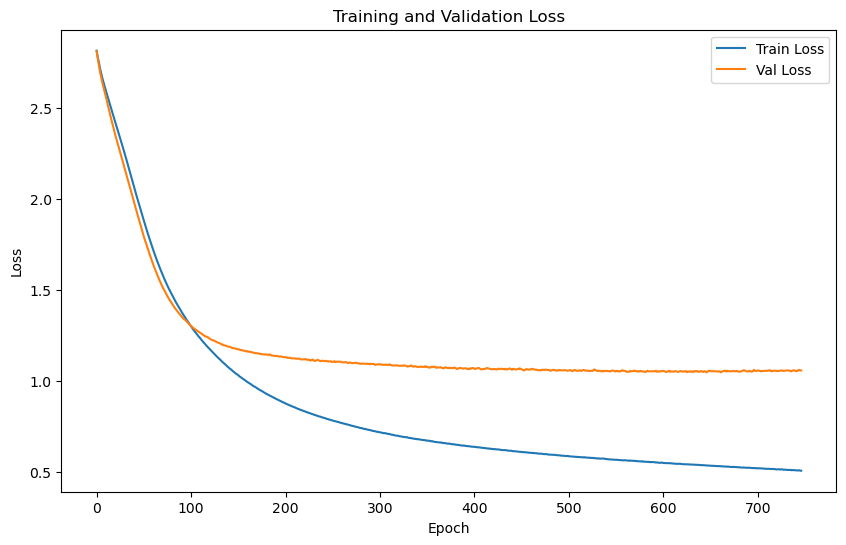

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.5907 | Test Accuracy: 53.11%


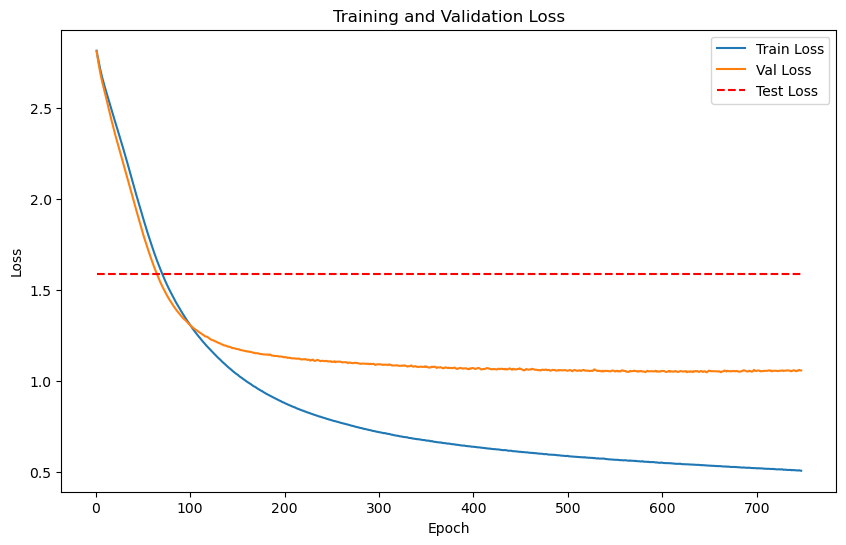

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.2009
Epoch [1/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.3487

Validation loss improved from inf to 0.3487. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.2022
Epoch [2/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.3495

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.2025
Epoch [3/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.3497

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.2020
Epoch [4/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.3493

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.2020
Epoch [5/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.3491

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.2018
Epoch [6/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.3488

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.2012
Epoch [7/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.3482

Validation loss improved from 0.3487 to 0.3482. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.2005
Epoch [8/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.3475

Validation loss improved from 0.3482 to 0.3475. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.1994
Epoch [9/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.3466

Validation loss improved from 0.3475 to 0.3466. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.1985
Epoch [10/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.3458

Validation loss improved from 0.3466 to 0.3458. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.1972
Epoch [11/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.3447

Validation loss improved from 0.3458 to 0.3447. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.1958
Epoch [12/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.3436

Validation loss improved from 0.3447 to 0.3436. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.1948
Epoch [13/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.3428

Validation loss improved from 0.3436 to 0.3428. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.1937
Epoch [14/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.3420

Validation loss improved from 0.3428 to 0.3420. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.1927
Epoch [15/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.3413

Validation loss improved from 0.3420 to 0.3413. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.1919
Epoch [16/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.3405

Validation loss improved from 0.3413 to 0.3405. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.1911
Epoch [17/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.3396

Validation loss improved from 0.3405 to 0.3396. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.1902
Epoch [18/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.3388

Validation loss improved from 0.3396 to 0.3388. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.1895
Epoch [19/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.3380

Validation loss improved from 0.3388 to 0.3380. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.1887
Epoch [20/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.3372

Validation loss improved from 0.3380 to 0.3372. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.1881
Epoch [21/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.3364

Validation loss improved from 0.3372 to 0.3364. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.1876
Epoch [22/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.3357

Validation loss improved from 0.3364 to 0.3357. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.1872
Epoch [23/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.3350

Validation loss improved from 0.3357 to 0.3350. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.1868
Epoch [24/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.3344

Validation loss improved from 0.3350 to 0.3344. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.1864
Epoch [25/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.3338

Validation loss improved from 0.3344 to 0.3338. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.1860
Epoch [26/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.3332

Validation loss improved from 0.3338 to 0.3332. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.1856
Epoch [27/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.3326

Validation loss improved from 0.3332 to 0.3326. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.1851
Epoch [28/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.3319

Validation loss improved from 0.3326 to 0.3319. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.1846
Epoch [29/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3314

Validation loss improved from 0.3319 to 0.3314. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.1842
Epoch [30/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.3308

Validation loss improved from 0.3314 to 0.3308. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.1837
Epoch [31/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3303

Validation loss improved from 0.3308 to 0.3303. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.1832
Epoch [32/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.3298

Validation loss improved from 0.3303 to 0.3298. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.1827
Epoch [33/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.3293

Validation loss improved from 0.3298 to 0.3293. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.1822
Epoch [34/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.3288

Validation loss improved from 0.3293 to 0.3288. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.1815
Epoch [35/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.3283

Validation loss improved from 0.3288 to 0.3283. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.1808
Epoch [36/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.3277

Validation loss improved from 0.3283 to 0.3277. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.1801
Epoch [37/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.3271

Validation loss improved from 0.3277 to 0.3271. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.1794
Epoch [38/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.3266

Validation loss improved from 0.3271 to 0.3266. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.1787
Epoch [39/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.3261

Validation loss improved from 0.3266 to 0.3261. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.1780
Epoch [40/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.3255

Validation loss improved from 0.3261 to 0.3255. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.1772
Epoch [41/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3250

Validation loss improved from 0.3255 to 0.3250. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.1764
Epoch [42/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.3244

Validation loss improved from 0.3250 to 0.3244. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.1755
Epoch [43/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.1747
Epoch [44/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.3232

Validation loss improved from 0.3238 to 0.3232. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.1738
Epoch [45/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.3227

Validation loss improved from 0.3232 to 0.3227. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.1730
Epoch [46/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.3221

Validation loss improved from 0.3227 to 0.3221. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.1721
Epoch [47/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.3215

Validation loss improved from 0.3221 to 0.3215. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.1713
Epoch [48/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.3209

Validation loss improved from 0.3215 to 0.3209. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.1704
Epoch [49/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.3203

Validation loss improved from 0.3209 to 0.3203. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.1696
Epoch [50/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.3198

Validation loss improved from 0.3203 to 0.3198. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.1688
Epoch [51/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.3192

Validation loss improved from 0.3198 to 0.3192. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.1679
Epoch [52/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.3186

Validation loss improved from 0.3192 to 0.3186. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.1670
Epoch [53/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.3180

Validation loss improved from 0.3186 to 0.3180. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.1661
Epoch [54/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.3174

Validation loss improved from 0.3180 to 0.3174. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.1653
Epoch [55/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.3168

Validation loss improved from 0.3174 to 0.3168. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4801
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.1643
Epoch [56/2000], Avg Train Loss: 0.4801, Avg Val Loss: 0.3162

Validation loss improved from 0.3168 to 0.3162. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.1634
Epoch [57/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.3156

Validation loss improved from 0.3162 to 0.3156. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.1624
Epoch [58/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.3150

Validation loss improved from 0.3156 to 0.3150. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.1615
Epoch [59/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.3144

Validation loss improved from 0.3150 to 0.3144. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.1606
Epoch [60/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.3138

Validation loss improved from 0.3144 to 0.3138. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.1596
Epoch [61/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.3132

Validation loss improved from 0.3138 to 0.3132. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.1587
Epoch [62/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.3126

Validation loss improved from 0.3132 to 0.3126. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.1578
Epoch [63/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.3120

Validation loss improved from 0.3126 to 0.3120. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.1569
Epoch [64/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.3114

Validation loss improved from 0.3120 to 0.3114. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.1560
Epoch [65/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.3109

Validation loss improved from 0.3114 to 0.3109. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.1551
Epoch [66/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.3103

Validation loss improved from 0.3109 to 0.3103. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.1541
Epoch [67/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.3097

Validation loss improved from 0.3103 to 0.3097. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.1532
Epoch [68/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3092

Validation loss improved from 0.3097 to 0.3092. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.1523
Epoch [69/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.3086

Validation loss improved from 0.3092 to 0.3086. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.1514
Epoch [70/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.3080

Validation loss improved from 0.3086 to 0.3080. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.1505
Epoch [71/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3074

Validation loss improved from 0.3080 to 0.3074. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.1496
Epoch [72/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3069

Validation loss improved from 0.3074 to 0.3069. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.1487
Epoch [73/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.3063

Validation loss improved from 0.3069 to 0.3063. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.1479
Epoch [74/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.3058

Validation loss improved from 0.3063 to 0.3058. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.1471
Epoch [75/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3053

Validation loss improved from 0.3058 to 0.3053. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.1463
Epoch [76/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.3048

Validation loss improved from 0.3053 to 0.3048. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.1454
Epoch [77/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.3043

Validation loss improved from 0.3048 to 0.3043. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.1446
Epoch [78/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.3038

Validation loss improved from 0.3043 to 0.3038. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.1439
Epoch [79/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.3033

Validation loss improved from 0.3038 to 0.3033. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.1431
Epoch [80/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3028

Validation loss improved from 0.3033 to 0.3028. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.1423
Epoch [81/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.3023

Validation loss improved from 0.3028 to 0.3023. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.1415
Epoch [82/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.3018

Validation loss improved from 0.3023 to 0.3018. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.1407
Epoch [83/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.3013

Validation loss improved from 0.3018 to 0.3013. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.1399
Epoch [84/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.3008

Validation loss improved from 0.3013 to 0.3008. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.1391
Epoch [85/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3004

Validation loss improved from 0.3008 to 0.3004. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.1383
Epoch [86/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.2998

Validation loss improved from 0.3004 to 0.2998. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.1375
Epoch [87/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.2993

Validation loss improved from 0.2998 to 0.2993. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.1366
Epoch [88/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.2988

Validation loss improved from 0.2993 to 0.2988. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.1358
Epoch [89/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.2983

Validation loss improved from 0.2988 to 0.2983. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.1350
Epoch [90/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.2979

Validation loss improved from 0.2983 to 0.2979. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.1343
Epoch [91/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.2974

Validation loss improved from 0.2979 to 0.2974. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.1335
Epoch [92/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.2970

Validation loss improved from 0.2974 to 0.2970. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.1326
Epoch [93/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.2965

Validation loss improved from 0.2970 to 0.2965. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.1318
Epoch [94/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.2960

Validation loss improved from 0.2965 to 0.2960. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.1310
Epoch [95/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.2956

Validation loss improved from 0.2960 to 0.2956. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.1303
Epoch [96/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.2951

Validation loss improved from 0.2956 to 0.2951. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.1295
Epoch [97/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.2947

Validation loss improved from 0.2951 to 0.2947. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.1288
Epoch [98/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.2942

Validation loss improved from 0.2947 to 0.2942. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.1280
Epoch [99/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.2938

Validation loss improved from 0.2942 to 0.2938. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.1273
Epoch [100/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.2933

Validation loss improved from 0.2938 to 0.2933. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.1266
Epoch [101/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.2929

Validation loss improved from 0.2933 to 0.2929. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.1259
Epoch [102/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.2924

Validation loss improved from 0.2929 to 0.2924. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.1252
Epoch [103/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.2921

Validation loss improved from 0.2924 to 0.2921. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.1246
Epoch [104/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.2917

Validation loss improved from 0.2921 to 0.2917. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.1240
Epoch [105/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.2914

Validation loss improved from 0.2917 to 0.2914. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.1235
Epoch [106/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.2911

Validation loss improved from 0.2914 to 0.2911. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.1229
Epoch [107/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.2908

Validation loss improved from 0.2911 to 0.2908. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.1224
Epoch [108/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.2905

Validation loss improved from 0.2908 to 0.2905. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.1220
Epoch [109/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.2903

Validation loss improved from 0.2905 to 0.2903. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.1215
Epoch [110/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.2900

Validation loss improved from 0.2903 to 0.2900. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.1210
Epoch [111/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.2897

Validation loss improved from 0.2900 to 0.2897. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.1206
Epoch [112/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.2894

Validation loss improved from 0.2897 to 0.2894. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.1202
Epoch [113/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.2891

Validation loss improved from 0.2894 to 0.2891. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.1197
Epoch [114/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.1193
Epoch [115/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.1189
Epoch [116/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.2883

Validation loss improved from 0.2886 to 0.2883. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.1185
Epoch [117/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.1180
Epoch [118/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.2878

Validation loss improved from 0.2881 to 0.2878. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.1176
Epoch [119/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.2876

Validation loss improved from 0.2878 to 0.2876. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.1172
Epoch [120/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.2873

Validation loss improved from 0.2876 to 0.2873. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.1168
Epoch [121/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.1164
Epoch [122/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.2868

Validation loss improved from 0.2870 to 0.2868. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.1161
Epoch [123/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.2865

Validation loss improved from 0.2868 to 0.2865. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.1157
Epoch [124/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.2863

Validation loss improved from 0.2865 to 0.2863. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.1153
Epoch [125/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.2860

Validation loss improved from 0.2863 to 0.2860. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.1150
Epoch [126/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.2858

Validation loss improved from 0.2860 to 0.2858. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.1147
Epoch [127/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.2856

Validation loss improved from 0.2858 to 0.2856. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.1143
Epoch [128/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.2854

Validation loss improved from 0.2856 to 0.2854. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.1140
Epoch [129/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.2852

Validation loss improved from 0.2854 to 0.2852. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.1136
Epoch [130/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.2849

Validation loss improved from 0.2852 to 0.2849. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.1133
Epoch [131/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.2846

Validation loss improved from 0.2849 to 0.2846. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.1129
Epoch [132/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.1125
Epoch [133/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.2840

Validation loss improved from 0.2843 to 0.2840. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.1121
Epoch [134/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.2837

Validation loss improved from 0.2840 to 0.2837. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.1117
Epoch [135/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.2834

Validation loss improved from 0.2837 to 0.2834. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.1113
Epoch [136/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.2830

Validation loss improved from 0.2834 to 0.2830. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.1110
Epoch [137/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.1106
Epoch [138/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.2825

Validation loss improved from 0.2828 to 0.2825. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.1102
Epoch [139/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.2822

Validation loss improved from 0.2825 to 0.2822. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.1098
Epoch [140/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.2818

Validation loss improved from 0.2822 to 0.2818. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.1093
Epoch [141/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.2815

Validation loss improved from 0.2818 to 0.2815. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.1089
Epoch [142/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.2812

Validation loss improved from 0.2815 to 0.2812. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.1085
Epoch [143/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.1081
Epoch [144/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.2806

Validation loss improved from 0.2809 to 0.2806. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.1077
Epoch [145/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.2803

Validation loss improved from 0.2806 to 0.2803. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.1074
Epoch [146/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.2800

Validation loss improved from 0.2803 to 0.2800. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.1070
Epoch [147/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2798

Validation loss improved from 0.2800 to 0.2798. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.1067
Epoch [148/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.2795

Validation loss improved from 0.2798 to 0.2795. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.1063
Epoch [149/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.2792

Validation loss improved from 0.2795 to 0.2792. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.1059
Epoch [150/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.2789

Validation loss improved from 0.2792 to 0.2789. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.1055
Epoch [151/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.1051
Epoch [152/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.2784

Validation loss improved from 0.2786 to 0.2784. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.1048
Epoch [153/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2781

Validation loss improved from 0.2784 to 0.2781. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.1045
Epoch [154/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.1041
Epoch [155/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.1037
Epoch [156/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2773

Validation loss improved from 0.2776 to 0.2773. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.1033
Epoch [157/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.1028
Epoch [158/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.2767

Validation loss improved from 0.2770 to 0.2767. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.1024
Epoch [159/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2764

Validation loss improved from 0.2767 to 0.2764. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.1019
Epoch [160/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.2761

Validation loss improved from 0.2764 to 0.2761. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.1016
Epoch [161/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.1012
Epoch [162/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2756

Validation loss improved from 0.2759 to 0.2756. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.1008
Epoch [163/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.2753

Validation loss improved from 0.2756 to 0.2753. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.1005
Epoch [164/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.2750

Validation loss improved from 0.2753 to 0.2750. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.1002
Epoch [165/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2747

Validation loss improved from 0.2750 to 0.2747. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.0998
Epoch [166/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2744

Validation loss improved from 0.2747 to 0.2744. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.0995
Epoch [167/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2742

Validation loss improved from 0.2744 to 0.2742. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.0991
Epoch [168/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.2739

Validation loss improved from 0.2742 to 0.2739. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.0988
Epoch [169/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.2736

Validation loss improved from 0.2739 to 0.2736. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.0985
Epoch [170/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.2733

Validation loss improved from 0.2736 to 0.2733. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.0981
Epoch [171/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.2731

Validation loss improved from 0.2733 to 0.2731. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.0978
Epoch [172/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.2728

Validation loss improved from 0.2731 to 0.2728. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.0976
Epoch [173/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.0974
Epoch [174/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.0972
Epoch [175/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.0970
Epoch [176/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.2720

Validation loss improved from 0.2722 to 0.2720. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.0968
Epoch [177/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.0966
Epoch [178/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.0965
Epoch [179/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.2715

Validation loss improved from 0.2717 to 0.2715. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4465
    Batch [2/2], Val Loss: 0.0963
Epoch [180/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.0961
Epoch [181/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.0958
Epoch [182/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.0956
Epoch [183/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2709

Validation loss improved from 0.2711 to 0.2709. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.0953
Epoch [184/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2707

Validation loss improved from 0.2709 to 0.2707. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.0949
Epoch [185/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2705

Validation loss improved from 0.2707 to 0.2705. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.0946
Epoch [186/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.2702

Validation loss improved from 0.2705 to 0.2702. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.0943
Epoch [187/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.2700

Validation loss improved from 0.2702 to 0.2700. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.0939
Epoch [188/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2698

Validation loss improved from 0.2700 to 0.2698. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.0936
Epoch [189/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.0933
Epoch [190/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.2693

Validation loss improved from 0.2695 to 0.2693. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.0929
Epoch [191/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.2691

Validation loss improved from 0.2693 to 0.2691. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.0926
Epoch [192/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.2689

Validation loss improved from 0.2691 to 0.2689. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.0923
Epoch [193/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2687

Validation loss improved from 0.2689 to 0.2687. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.0920
Epoch [194/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.0916
Epoch [195/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.0913
Epoch [196/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2680

Validation loss improved from 0.2683 to 0.2680. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.0910
Epoch [197/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.2678

Validation loss improved from 0.2680 to 0.2678. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.0908
Epoch [198/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.0905
Epoch [199/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.0903
Epoch [200/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.0901
Epoch [201/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.0899
Epoch [202/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.2668

Validation loss improved from 0.2671 to 0.2668. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.0896
Epoch [203/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2666

Validation loss improved from 0.2668 to 0.2666. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4434
    Batch [2/2], Val Loss: 0.0894
Epoch [204/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.2664

Validation loss improved from 0.2666 to 0.2664. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.0893
Epoch [205/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2662

Validation loss improved from 0.2664 to 0.2662. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.0891
Epoch [206/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.0889
Epoch [207/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2659

Validation loss improved from 0.2661 to 0.2659. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.0888
Epoch [208/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.0887
Epoch [209/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.0886
Epoch [210/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2655

Validation loss improved from 0.2657 to 0.2655. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4423
    Batch [2/2], Val Loss: 0.0884
Epoch [211/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2653

Validation loss improved from 0.2655 to 0.2653. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.0882
Epoch [212/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.0881
Epoch [213/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.2650

Validation loss improved from 0.2652 to 0.2650. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.0880
Epoch [214/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.0878
Epoch [215/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.0877
Epoch [216/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.0876
Epoch [217/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2645

Validation loss improved from 0.2647 to 0.2645. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.0874
Epoch [218/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.0871
Epoch [219/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.0869
Epoch [220/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2640

Validation loss improved from 0.2642 to 0.2640. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.0866
Epoch [221/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2637

Validation loss improved from 0.2640 to 0.2637. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.0862
Epoch [222/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.0859
Epoch [223/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.0856
Epoch [224/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.2630

Validation loss improved from 0.2633 to 0.2630. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.0853
Epoch [225/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.0850
Epoch [226/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2625

Validation loss improved from 0.2628 to 0.2625. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.0847
Epoch [227/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2622

Validation loss improved from 0.2625 to 0.2622. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.0844
Epoch [228/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2619

Validation loss improved from 0.2622 to 0.2619. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.0841
Epoch [229/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2617

Validation loss improved from 0.2619 to 0.2617. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.0838
Epoch [230/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.0835
Epoch [231/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2613

Validation loss improved from 0.2615 to 0.2613. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.0832
Epoch [232/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2611

Validation loss improved from 0.2613 to 0.2611. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.0831
Epoch [233/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.0829
Epoch [234/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.0827
Epoch [235/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.0826
Epoch [236/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.0824
Epoch [237/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0823
Epoch [238/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0822
Epoch [239/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.0821
Epoch [240/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.0820
Epoch [241/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.0820
Epoch [242/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.0819
Epoch [243/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.0818
Epoch [244/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.0816
Epoch [245/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.0814
Epoch [246/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.0813
Epoch [247/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.0811
Epoch [248/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.0810
Epoch [249/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.0809
Epoch [250/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.0808
Epoch [251/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.0807
Epoch [252/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.0806
Epoch [253/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4370
    Batch [2/2], Val Loss: 0.0805
Epoch [254/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2587

Validation loss improved from 0.2589 to 0.2587. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.0803
Epoch [255/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.0802
Epoch [256/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.0800
Epoch [257/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.0797
Epoch [258/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2579

Validation loss improved from 0.2582 to 0.2579. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.0795
Epoch [259/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2577

Validation loss improved from 0.2579 to 0.2577. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.0792
Epoch [260/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2574

Validation loss improved from 0.2577 to 0.2574. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.0790
Epoch [261/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2572

Validation loss improved from 0.2574 to 0.2572. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.0787
Epoch [262/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2570

Validation loss improved from 0.2572 to 0.2570. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.0784
Epoch [263/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2568

Validation loss improved from 0.2570 to 0.2568. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.0782
Epoch [264/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2566

Validation loss improved from 0.2568 to 0.2566. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.0779
Epoch [265/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.0777
Epoch [266/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2563

Validation loss improved from 0.2565 to 0.2563. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.0774
Epoch [267/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2561

Validation loss improved from 0.2563 to 0.2561. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.0772
Epoch [268/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.0770
Epoch [269/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2558

Validation loss improved from 0.2560 to 0.2558. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.0767
Epoch [270/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.0765
Epoch [271/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2555

Validation loss improved from 0.2557 to 0.2555. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0762
Epoch [272/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2552

Validation loss improved from 0.2555 to 0.2552. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0760
Epoch [273/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0758
Epoch [274/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0757
Epoch [275/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0756
Epoch [276/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0754
Epoch [277/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0754
Epoch [278/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0753
Epoch [279/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0752
Epoch [280/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0751
Epoch [281/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0751
Epoch [282/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0750
Epoch [283/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0750
Epoch [284/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0749
Epoch [285/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0749
Epoch [286/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0748
Epoch [287/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.2544

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0747
Epoch [288/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0746
Epoch [289/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.0745
Epoch [290/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.0745
Epoch [291/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.0744
Epoch [292/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2540

Validation loss improved from 0.2540 to 0.2540. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0743
Epoch [293/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0742
Epoch [294/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.0741
Epoch [295/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.0740
Epoch [296/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.0738
Epoch [297/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.0738
Epoch [298/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.0736
Epoch [299/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2534

Validation loss improved from 0.2534 to 0.2534. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.0735
Epoch [300/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2534

Validation loss improved from 0.2534 to 0.2534. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.0734
Epoch [301/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2534

Validation loss improved from 0.2534 to 0.2534. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0733
Epoch [302/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0732
Epoch [303/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0731
Epoch [304/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.0730
Epoch [305/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0729
Epoch [306/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0728
Epoch [307/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0727
Epoch [308/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0726
Epoch [309/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0726
Epoch [310/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.0726
Epoch [311/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.0726
Epoch [312/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.0726
Epoch [313/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.0726
Epoch [314/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.0726
Epoch [315/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.0726
Epoch [316/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2523

Validation loss improved from 0.2525 to 0.2523. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0725
Epoch [317/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.0725
Epoch [318/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2520

Validation loss improved from 0.2522 to 0.2520. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.0725
Epoch [319/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2518

Validation loss improved from 0.2520 to 0.2518. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0725
Epoch [320/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.0724
Epoch [321/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0724
Epoch [322/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0723
Epoch [323/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0723
Epoch [324/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.0722
Epoch [325/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.0721
Epoch [326/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.0720
Epoch [327/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0719
Epoch [328/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0718
Epoch [329/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2510

Validation loss improved from 0.2510 to 0.2510. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0717
Epoch [330/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2510

Validation loss improved from 0.2510 to 0.2510. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4128
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0716
Epoch [331/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0715
Epoch [332/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.0714
Epoch [333/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4300
    Batch [2/2], Val Loss: 0.0713
Epoch [334/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.0712
Epoch [335/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2506

Validation loss improved from 0.2506 to 0.2506. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.0712
Epoch [336/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.0711
Epoch [337/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.0710
Epoch [338/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.0709
Epoch [339/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2501

Validation loss improved from 0.2503 to 0.2501. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.0707
Epoch [340/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.0706
Epoch [341/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0704
Epoch [342/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2498

Validation loss improved from 0.2500 to 0.2498. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0703
Epoch [343/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0701
Epoch [344/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.0700
Epoch [345/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.0698
Epoch [346/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.0697
Epoch [347/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.0695
Epoch [348/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.0694
Epoch [349/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.0692
Epoch [350/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.0690
Epoch [351/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.0689
Epoch [352/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0688
Epoch [353/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.0686
Epoch [354/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2485

Validation loss improved from 0.2487 to 0.2485. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.0685
Epoch [355/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0683
Epoch [356/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2481

Validation loss improved from 0.2484 to 0.2481. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.0681
Epoch [357/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2479

Validation loss improved from 0.2481 to 0.2479. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.0679
Epoch [358/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2477

Validation loss improved from 0.2479 to 0.2477. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0677
Epoch [359/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2475

Validation loss improved from 0.2477 to 0.2475. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0675
Epoch [360/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2473

Validation loss improved from 0.2475 to 0.2473. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.0674
Epoch [361/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0673
Epoch [362/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0672
Epoch [363/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0670
Epoch [364/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2470

Validation loss improved from 0.2470 to 0.2470. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0669
Epoch [365/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0668
Epoch [366/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0667
Epoch [367/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0666
Epoch [368/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.0665
Epoch [369/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0665
Epoch [370/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0665
Epoch [371/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0665
Epoch [372/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0665
Epoch [373/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0664
Epoch [374/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.0663
Epoch [375/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.0663
Epoch [376/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.0663
Epoch [377/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.0662
Epoch [378/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2463

Validation loss improved from 0.2463 to 0.2463. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.0662
Epoch [379/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.0662
Epoch [380/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.0661
Epoch [381/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.0661
Epoch [382/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.0660
Epoch [383/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.0659
Epoch [384/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.0658
Epoch [385/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.2458

Validation loss improved from 0.2460 to 0.2458. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.0657
Epoch [386/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.0656
Epoch [387/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.0655
Epoch [388/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.0653
Epoch [389/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2451

Validation loss improved from 0.2453 to 0.2451. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.0652
Epoch [390/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2449

Validation loss improved from 0.2451 to 0.2449. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.0651
Epoch [391/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2447

Validation loss improved from 0.2449 to 0.2447. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.0649
Epoch [392/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2445

Validation loss improved from 0.2447 to 0.2445. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.0648
Epoch [393/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0647
Epoch [394/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2441

Validation loss improved from 0.2443 to 0.2441. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0646
Epoch [395/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.0646
Epoch [396/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0645
Epoch [397/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0645
Epoch [398/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0644
Epoch [399/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0643
Epoch [400/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0642
Epoch [401/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0642
Epoch [402/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.0641
Epoch [403/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.0640
Epoch [404/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2432

Validation loss improved from 0.2434 to 0.2432. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0640
Epoch [405/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0639
Epoch [406/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.0638
Epoch [407/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.0637
Epoch [408/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0637
Epoch [409/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2429

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0636
Epoch [410/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2430

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0636
Epoch [411/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2430

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.0636
Epoch [412/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2431

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0636
Epoch [413/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2431

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0636
Epoch [414/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0635
Epoch [415/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0635
Epoch [416/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0635
Epoch [417/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.0634
Epoch [418/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.0634
Epoch [419/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2437

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.0633
Epoch [420/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.0633
Epoch [421/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2436

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.0632
Epoch [422/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.0632
Epoch [423/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2435

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.0631
Epoch [424/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0630
Epoch [425/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.0629
Epoch [426/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2432

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0628
Epoch [427/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2430

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.0627
Epoch [428/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2429

Validation loss improved from 0.2429 to 0.2429. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0626
Epoch [429/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0625
Epoch [430/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0624
Epoch [431/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0623
Epoch [432/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0622
Epoch [433/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2425

Validation loss improved from 0.2425 to 0.2425. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0621
Epoch [434/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2425

Validation loss improved from 0.2425 to 0.2425. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0621
Epoch [435/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0620
Epoch [436/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0619
Epoch [437/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0619
Epoch [438/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0618
Epoch [439/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.0617
Epoch [440/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0617
Epoch [441/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0616
Epoch [442/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0616
Epoch [443/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0615
Epoch [444/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0614
Epoch [445/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0612
Epoch [446/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0611
Epoch [447/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2420

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0610
Epoch [448/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0610
Epoch [449/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2417

Validation loss improved from 0.2419 to 0.2417. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.0609
Epoch [450/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2415

Validation loss improved from 0.2417 to 0.2415. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.0608
Epoch [451/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.0608
Epoch [452/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.0608
Epoch [453/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2411

Validation loss improved from 0.2413 to 0.2411. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.0608
Epoch [454/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.0608
Epoch [455/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2408

Validation loss improved from 0.2410 to 0.2408. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.0609
Epoch [456/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.0609
Epoch [457/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4202
    Batch [2/2], Val Loss: 0.0609
Epoch [458/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.0609
Epoch [459/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2405

Validation loss improved from 0.2405 to 0.2405. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.0608
Epoch [460/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0608
Epoch [461/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0608
Epoch [462/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0607
Epoch [463/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.0606
Epoch [464/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.0606
Epoch [465/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0606
Epoch [466/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0605
Epoch [467/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0604
Epoch [468/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.0604
Epoch [469/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.0603
Epoch [470/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.0602
Epoch [471/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0601
Epoch [472/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.0600
Epoch [473/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0599
Epoch [474/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0598
Epoch [475/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0598
Epoch [476/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0597
Epoch [477/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0597
Epoch [478/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0597
Epoch [479/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0597
Epoch [480/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0597
Epoch [481/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0596
Epoch [482/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4200
    Batch [2/2], Val Loss: 0.0596
Epoch [483/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0595
Epoch [484/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0595
Epoch [485/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0594
Epoch [486/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0593
Epoch [487/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0592
Epoch [488/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0592
Epoch [489/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2395

Validation loss improved from 0.2395 to 0.2395. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0591
Epoch [490/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0591
Epoch [491/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.0590
Epoch [492/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2393

Validation loss improved from 0.2393 to 0.2393. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0590
Epoch [493/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2393

Validation loss improved from 0.2393 to 0.2393. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0589
Epoch [494/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0589
Epoch [495/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0588
Epoch [496/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0588
Epoch [497/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0588
Epoch [498/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0587
Epoch [499/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0587
Epoch [500/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.0587
Epoch [501/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0586
Epoch [502/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0585
Epoch [503/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0585
Epoch [504/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.0584
Epoch [505/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.0584
Epoch [506/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0584
Epoch [507/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.0585
Epoch [508/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2387

Validation loss improved from 0.2389 to 0.2387. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0585
Epoch [509/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.0585
Epoch [510/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2384

Validation loss improved from 0.2386 to 0.2384. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0585
Epoch [511/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2382

Validation loss improved from 0.2384 to 0.2382. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0584
Epoch [512/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2379

Validation loss improved from 0.2382 to 0.2379. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0584
Epoch [513/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0583
Epoch [514/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2376

Validation loss improved from 0.2378 to 0.2376. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0583
Epoch [515/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2376

Validation loss improved from 0.2376 to 0.2376. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0582
Epoch [516/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0582
Epoch [517/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2375

Validation loss improved from 0.2375 to 0.2375. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0582
Epoch [518/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0581
Epoch [519/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2375

Validation loss improved from 0.2375 to 0.2375. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0581
Epoch [520/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2375

Validation loss improved from 0.2375 to 0.2375. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0580
Epoch [521/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0580
Epoch [522/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0579
Epoch [523/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0579
Epoch [524/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0579
Epoch [525/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0579
Epoch [526/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0578
Epoch [527/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.0577
Epoch [528/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0576
Epoch [529/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0575
Epoch [530/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0574
Epoch [531/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0573
Epoch [532/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.0572
Epoch [533/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.0571
Epoch [534/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0571
Epoch [535/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0570
Epoch [536/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0569
Epoch [537/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0569
Epoch [538/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0568
Epoch [539/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0568
Epoch [540/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2371

Validation loss improved from 0.2371 to 0.2371. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0567
Epoch [541/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0566
Epoch [542/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0566
Epoch [543/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0565
Epoch [544/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0565
Epoch [545/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0564
Epoch [546/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0563
Epoch [547/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0562
Epoch [548/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0561
Epoch [549/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0561
Epoch [550/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0560
Epoch [551/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.0559
Epoch [552/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0559
Epoch [553/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.0559
Epoch [554/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0559
Epoch [555/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2366

Validation loss improved from 0.2367 to 0.2366. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0559
Epoch [556/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0559
Epoch [557/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.0560
Epoch [558/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0561
Epoch [559/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0562
Epoch [560/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0563
Epoch [561/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0565
Epoch [562/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0566
Epoch [563/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0567
Epoch [564/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0568
Epoch [565/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0569
Epoch [566/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0570
Epoch [567/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0571
Epoch [568/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.0571
Epoch [569/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.0571
Epoch [570/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0571
Epoch [571/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0571
Epoch [572/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0570
Epoch [573/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0570
Epoch [574/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0569
Epoch [575/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0569
Epoch [576/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0568
Epoch [577/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0568
Epoch [578/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0568
Epoch [579/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0567
Epoch [580/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4166
    Batch [2/2], Val Loss: 0.0566
Epoch [581/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0566
Epoch [582/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0566
Epoch [583/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0565
Epoch [584/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0565
Epoch [585/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0565
Epoch [586/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0564
Epoch [587/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0564
Epoch [588/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0564
Epoch [589/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0564
Epoch [590/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0564
Epoch [591/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0564
Epoch [592/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0564
Epoch [593/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0563
Epoch [594/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0563
Epoch [595/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0563
Epoch [596/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0563
Epoch [597/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0563
Epoch [598/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0563
Epoch [599/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0563
Epoch [600/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [601/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [602/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [603/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [604/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [605/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [606/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [607/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [608/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [609/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [610/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [611/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0564
Epoch [612/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0565
Epoch [613/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.0565
Epoch [614/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.0565
Epoch [615/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.0565
Epoch [616/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0565
Epoch [617/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2362

Validation loss improved from 0.2362 to 0.2362. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0565
Epoch [618/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0565
Epoch [619/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.0565
Epoch [620/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.0565
Epoch [621/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0565
Epoch [622/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0565
Epoch [623/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0565
Epoch [624/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0565
Epoch [625/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0565
Epoch [626/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.0565
Epoch [627/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.0565
Epoch [628/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0565
Epoch [629/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0565
Epoch [630/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0565
Epoch [631/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.0565
Epoch [632/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.0565
Epoch [633/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0565
Epoch [634/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0565
Epoch [635/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0565
Epoch [636/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0565
Epoch [637/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [638/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [639/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [640/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [641/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [642/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [643/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [644/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0564
Epoch [645/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0564
Epoch [646/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0564
Epoch [647/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0564
Epoch [648/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0564
Epoch [649/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0564
Epoch [650/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0564
Epoch [651/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0564
Epoch [652/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0564
Epoch [653/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0564
Epoch [654/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [655/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [656/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [657/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [658/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [659/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [660/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [661/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [662/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [663/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [664/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [665/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [666/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [667/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.0565
Epoch [668/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [669/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [670/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [671/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [672/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [673/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [674/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [675/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [676/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [677/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [678/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [679/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [680/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [681/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [682/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [683/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [684/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [685/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [686/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [687/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [688/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [689/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [690/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [691/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [692/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [693/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [694/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [695/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [696/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [697/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [698/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [699/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [700/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [701/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [702/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [703/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [704/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [705/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [706/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [707/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [708/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [709/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [710/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [711/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [712/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [713/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [714/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [715/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [716/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [717/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [718/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [719/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [720/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [721/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [722/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [723/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [724/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [725/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [726/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [727/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [728/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [729/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [730/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [731/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [732/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [733/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [734/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [735/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [736/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [737/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [738/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [739/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [740/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [741/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [742/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [743/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [744/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [745/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [746/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [747/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [748/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [749/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [750/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [751/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [752/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [753/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [754/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [755/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [756/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [757/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [758/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [759/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [760/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [761/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [762/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [763/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [764/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [765/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [766/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [767/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [768/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [769/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [770/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [771/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [772/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [773/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [774/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [775/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [776/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [777/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [778/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [779/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [780/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [781/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [782/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [783/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [784/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [785/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [786/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [787/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [788/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [789/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [790/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [791/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [792/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [793/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [794/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [795/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [796/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [797/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [798/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [799/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [800/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [801/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [802/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [803/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [804/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [805/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [806/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [807/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [808/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [809/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [810/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [811/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [812/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [813/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [814/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [815/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [816/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [817/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [818/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [819/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [820/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [821/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [822/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [823/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [824/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [825/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [826/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [827/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [828/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [829/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [830/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [831/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [832/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [833/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [834/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [835/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [836/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [837/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [838/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [839/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [840/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [841/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [842/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [843/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [844/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [845/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [846/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [847/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [848/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [849/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [850/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [851/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [852/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [853/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [854/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [855/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [856/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [857/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [858/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [859/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [860/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [861/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [862/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [863/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [864/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [865/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [866/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [867/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [868/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [869/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [870/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [871/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [872/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [873/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [874/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [875/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [876/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [877/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [878/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [879/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [880/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [881/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [882/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [883/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [884/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [885/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [886/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [887/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [888/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [889/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [890/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [891/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [892/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [893/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [894/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [895/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [896/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [897/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [898/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [899/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [900/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [901/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [902/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [903/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [904/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [905/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [906/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [907/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [908/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [909/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [910/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [911/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [912/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [913/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [914/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [915/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [916/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [917/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [918/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [919/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [920/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [921/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [922/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [923/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [924/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [925/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [926/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [927/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [928/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [929/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [930/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [931/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [932/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [933/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [934/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [935/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [936/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [937/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [938/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [939/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [940/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [941/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [942/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [943/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [944/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [945/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.0565
Epoch [946/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 946!!
No improvement for 100 epochs


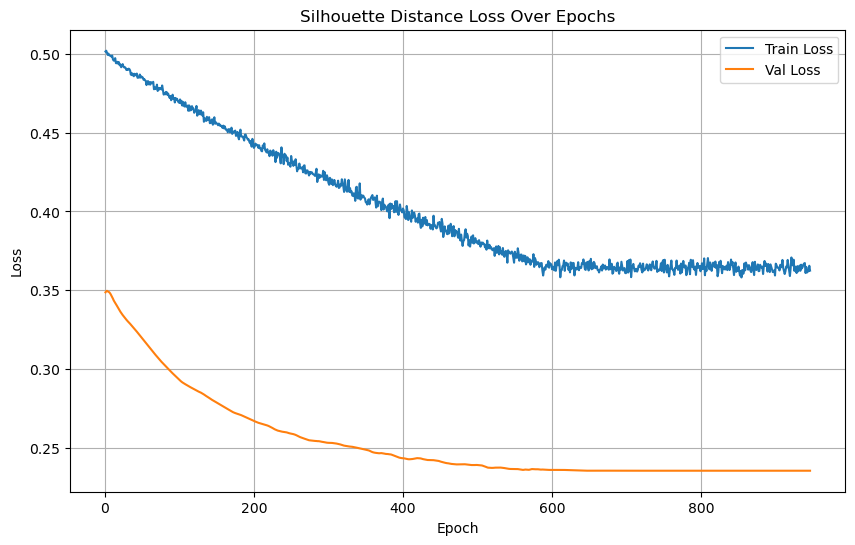

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/150], Loss: 0.2128
Test Batch [20/150], Loss: 0.2889
Test Batch [30/150], Loss: 0.3566


Test Batch [40/150], Loss: 0.4252
Test Batch [50/150], Loss: 0.4551
Test Batch [60/150], Loss: 0.2544
Test Batch [70/150], Loss: 0.3016


Test Batch [80/150], Loss: 0.3296
Test Batch [90/150], Loss: 0.2070
Test Batch [100/150], Loss: 0.1523
Test Batch [110/150], Loss: 0.2736
Test Batch [120/150], Loss: 0.1409


Test Batch [130/150], Loss: 0.3997
Test Batch [140/150], Loss: 0.3350
Test Batch [150/150], Loss: 0.1748

Test Loss: 0.3158


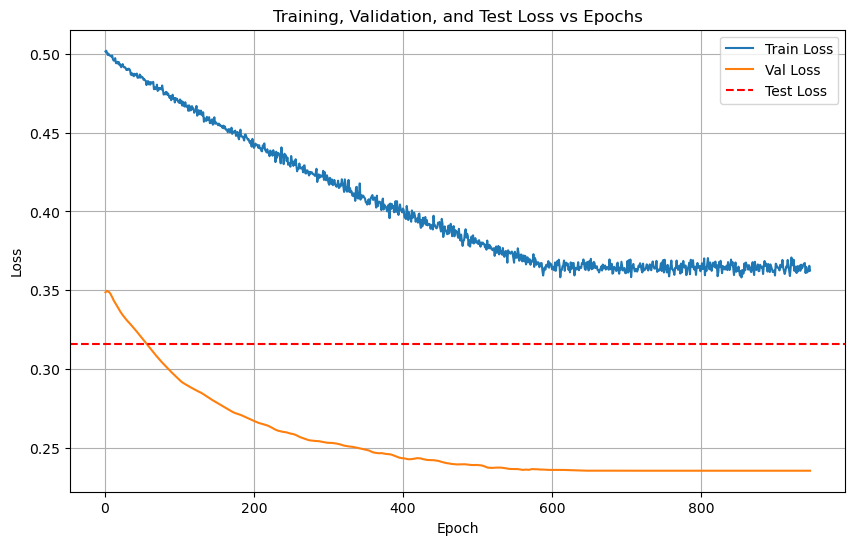

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/150 for test dataset.


  Processed batch 20/150 for test dataset.
  Processed batch 30/150 for test dataset.


  Processed batch 40/150 for test dataset.
  Processed batch 50/150 for test dataset.
  Processed batch 60/150 for test dataset.
  Processed batch 70/150 for test dataset.


  Processed batch 80/150 for test dataset.
  Processed batch 90/150 for test dataset.
  Processed batch 100/150 for test dataset.


  Processed batch 110/150 for test dataset.
  Processed batch 120/150 for test dataset.
  Processed batch 130/150 for test dataset.
  Processed batch 140/150 for test dataset.


  Processed batch 150/150 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.71%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.40      0.44         5
           2       0.40      0.40      0.40         5
           3       1.00      0.40      0.57         5
           4       0.50      0.40      0.44         5
           5       0.67      0.40      0.50         5
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         5
           9       0.40      0.80      0.53         5
          10       0.67      0.80      0.73         5
          11       0.50      0.40      0.44         5
          12       1.00      1.00      1.00         5
          13       0.67      0.40      0.50         5
          14       0.5

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7724  |  Val Loss: 2.7622
Validation loss improved from inf to 2.7622.
[Epoch 2/1000] Train Loss: 2.7466  |  Val Loss: 2.7350
Validation loss improved from 2.7622 to 2.7350.
[Epoch 3/1000] Train Loss: 2.7228  |  Val Loss: 2.7088
Validation loss improved from 2.7350 to 2.7088.


[Epoch 4/1000] Train Loss: 2.7019  |  Val Loss: 2.6821
Validation loss improved from 2.7088 to 2.6821.
[Epoch 5/1000] Train Loss: 2.6799  |  Val Loss: 2.6586
Validation loss improved from 2.6821 to 2.6586.
[Epoch 6/1000] Train Loss: 2.6590  |  Val Loss: 2.6356
Validation loss improved from 2.6586 to 2.6356.
[Epoch 7/1000] Train Loss: 2.6394  |  Val Loss: 2.6138
Validation loss improved from 2.6356 to 2.6138.
[Epoch 8/1000] Train Loss: 2.6212  |  Val Loss: 2.5919
Validation loss improved from 2.6138 to 2.5919.
[Epoch 9/1000] Train Loss: 2.6031  |  Val Loss: 2.5701
Validation loss improved from 2.5919 to 2.5701.
[Epoch 10/1000] Train Loss: 2.5852  |  Val Loss: 2.5499
Validation loss improved from 2.5701 to 2.5499.
[Epoch 11/1000] Train Loss: 2.5666  |  Val Loss: 2.5299
Validation loss improved from 2.5499 to 2.5299.
[Epoch 12/1000] Train Loss: 2.5490  |  Val Loss: 2.5063
Validation loss improved from 2.5299 to 2.5063.
[Epoch 13/1000] Train Loss: 2.5280  |  Val Loss: 2.4830
Validation los

[Epoch 16/1000] Train Loss: 2.4660  |  Val Loss: 2.4165
Validation loss improved from 2.4369 to 2.4165.
[Epoch 17/1000] Train Loss: 2.4468  |  Val Loss: 2.3965
Validation loss improved from 2.4165 to 2.3965.
[Epoch 18/1000] Train Loss: 2.4282  |  Val Loss: 2.3772
Validation loss improved from 2.3965 to 2.3772.
[Epoch 19/1000] Train Loss: 2.4102  |  Val Loss: 2.3589
Validation loss improved from 2.3772 to 2.3589.


[Epoch 20/1000] Train Loss: 2.3932  |  Val Loss: 2.3415
Validation loss improved from 2.3589 to 2.3415.
[Epoch 21/1000] Train Loss: 2.3761  |  Val Loss: 2.3245
Validation loss improved from 2.3415 to 2.3245.
[Epoch 22/1000] Train Loss: 2.3588  |  Val Loss: 2.3078
Validation loss improved from 2.3245 to 2.3078.
[Epoch 23/1000] Train Loss: 2.3416  |  Val Loss: 2.2919
Validation loss improved from 2.3078 to 2.2919.
[Epoch 24/1000] Train Loss: 2.3247  |  Val Loss: 2.2765
Validation loss improved from 2.2919 to 2.2765.
[Epoch 25/1000] Train Loss: 2.3082  |  Val Loss: 2.2607
Validation loss improved from 2.2765 to 2.2607.
[Epoch 26/1000] Train Loss: 2.2912  |  Val Loss: 2.2455
Validation loss improved from 2.2607 to 2.2455.
[Epoch 27/1000] Train Loss: 2.2750  |  Val Loss: 2.2299
Validation loss improved from 2.2455 to 2.2299.
[Epoch 28/1000] Train Loss: 2.2578  |  Val Loss: 2.2149
Validation loss improved from 2.2299 to 2.2149.
[Epoch 29/1000] Train Loss: 2.2410  |  Val Loss: 2.1997
Validati

[Epoch 34/1000] Train Loss: 2.1531  |  Val Loss: 2.1227
Validation loss improved from 2.1389 to 2.1227.
[Epoch 35/1000] Train Loss: 2.1351  |  Val Loss: 2.1064
Validation loss improved from 2.1227 to 2.1064.
[Epoch 36/1000] Train Loss: 2.1163  |  Val Loss: 2.0894
Validation loss improved from 2.1064 to 2.0894.
[Epoch 37/1000] Train Loss: 2.0971  |  Val Loss: 2.0723
Validation loss improved from 2.0894 to 2.0723.


[Epoch 38/1000] Train Loss: 2.0774  |  Val Loss: 2.0553
Validation loss improved from 2.0723 to 2.0553.
[Epoch 39/1000] Train Loss: 2.0577  |  Val Loss: 2.0382
Validation loss improved from 2.0553 to 2.0382.
[Epoch 40/1000] Train Loss: 2.0377  |  Val Loss: 2.0206
Validation loss improved from 2.0382 to 2.0206.
[Epoch 41/1000] Train Loss: 2.0169  |  Val Loss: 2.0029
Validation loss improved from 2.0206 to 2.0029.
[Epoch 42/1000] Train Loss: 1.9973  |  Val Loss: 1.9856
Validation loss improved from 2.0029 to 1.9856.
[Epoch 43/1000] Train Loss: 1.9763  |  Val Loss: 1.9681
Validation loss improved from 1.9856 to 1.9681.
[Epoch 44/1000] Train Loss: 1.9549  |  Val Loss: 1.9499
Validation loss improved from 1.9681 to 1.9499.
[Epoch 45/1000] Train Loss: 1.9337  |  Val Loss: 1.9318
Validation loss improved from 1.9499 to 1.9318.
[Epoch 46/1000] Train Loss: 1.9122  |  Val Loss: 1.9135
Validation loss improved from 1.9318 to 1.9135.
[Epoch 47/1000] Train Loss: 1.8901  |  Val Loss: 1.8954
Validati

[Epoch 54/1000] Train Loss: 1.7363  |  Val Loss: 1.7685
Validation loss improved from 1.7864 to 1.7685.
[Epoch 55/1000] Train Loss: 1.7145  |  Val Loss: 1.7506
Validation loss improved from 1.7685 to 1.7506.
[Epoch 56/1000] Train Loss: 1.6924  |  Val Loss: 1.7329
Validation loss improved from 1.7506 to 1.7329.
[Epoch 57/1000] Train Loss: 1.6700  |  Val Loss: 1.7154
Validation loss improved from 1.7329 to 1.7154.


[Epoch 58/1000] Train Loss: 1.6474  |  Val Loss: 1.6984
Validation loss improved from 1.7154 to 1.6984.
[Epoch 59/1000] Train Loss: 1.6253  |  Val Loss: 1.6809
Validation loss improved from 1.6984 to 1.6809.
[Epoch 60/1000] Train Loss: 1.6030  |  Val Loss: 1.6633
Validation loss improved from 1.6809 to 1.6633.
[Epoch 61/1000] Train Loss: 1.5811  |  Val Loss: 1.6457
Validation loss improved from 1.6633 to 1.6457.
[Epoch 62/1000] Train Loss: 1.5586  |  Val Loss: 1.6285
Validation loss improved from 1.6457 to 1.6285.
[Epoch 63/1000] Train Loss: 1.5367  |  Val Loss: 1.6115
Validation loss improved from 1.6285 to 1.6115.
[Epoch 64/1000] Train Loss: 1.5153  |  Val Loss: 1.5944
Validation loss improved from 1.6115 to 1.5944.
[Epoch 65/1000] Train Loss: 1.4933  |  Val Loss: 1.5780
Validation loss improved from 1.5944 to 1.5780.
[Epoch 66/1000] Train Loss: 1.4717  |  Val Loss: 1.5618
Validation loss improved from 1.5780 to 1.5618.
[Epoch 67/1000] Train Loss: 1.4511  |  Val Loss: 1.5457
Validati

[Epoch 73/1000] Train Loss: 1.3304  |  Val Loss: 1.4564
Validation loss improved from 1.4704 to 1.4564.
[Epoch 74/1000] Train Loss: 1.3114  |  Val Loss: 1.4424
Validation loss improved from 1.4564 to 1.4424.
[Epoch 75/1000] Train Loss: 1.2929  |  Val Loss: 1.4292
Validation loss improved from 1.4424 to 1.4292.
[Epoch 76/1000] Train Loss: 1.2739  |  Val Loss: 1.4161
Validation loss improved from 1.4292 to 1.4161.
[Epoch 77/1000] Train Loss: 1.2557  |  Val Loss: 1.4031
Validation loss improved from 1.4161 to 1.4031.
[Epoch 78/1000] Train Loss: 1.2375  |  Val Loss: 1.3903
Validation loss improved from 1.4031 to 1.3903.
[Epoch 79/1000] Train Loss: 1.2195  |  Val Loss: 1.3782
Validation loss improved from 1.3903 to 1.3782.
[Epoch 80/1000] Train Loss: 1.2025  |  Val Loss: 1.3669
Validation loss improved from 1.3782 to 1.3669.
[Epoch 81/1000] Train Loss: 1.1854  |  Val Loss: 1.3553
Validation loss improved from 1.3669 to 1.3553.
[Epoch 82/1000] Train Loss: 1.1692  |  Val Loss: 1.3444
Validati

[Epoch 93/1000] Train Loss: 1.0064  |  Val Loss: 1.2376
Validation loss improved from 1.2461 to 1.2376.
[Epoch 94/1000] Train Loss: 0.9937  |  Val Loss: 1.2296
Validation loss improved from 1.2376 to 1.2296.
[Epoch 95/1000] Train Loss: 0.9807  |  Val Loss: 1.2211
Validation loss improved from 1.2296 to 1.2211.
[Epoch 96/1000] Train Loss: 0.9681  |  Val Loss: 1.2135
Validation loss improved from 1.2211 to 1.2135.
[Epoch 97/1000] Train Loss: 0.9561  |  Val Loss: 1.2058
Validation loss improved from 1.2135 to 1.2058.
[Epoch 98/1000] Train Loss: 0.9443  |  Val Loss: 1.1994
Validation loss improved from 1.2058 to 1.1994.
[Epoch 99/1000] Train Loss: 0.9328  |  Val Loss: 1.1920
Validation loss improved from 1.1994 to 1.1920.
[Epoch 100/1000] Train Loss: 0.9215  |  Val Loss: 1.1846
Validation loss improved from 1.1920 to 1.1846.
[Epoch 101/1000] Train Loss: 0.9103  |  Val Loss: 1.1779
Validation loss improved from 1.1846 to 1.1779.
[Epoch 102/1000] Train Loss: 0.8994  |  Val Loss: 1.1719
Valid

[Epoch 111/1000] Train Loss: 0.8139  |  Val Loss: 1.1201
Validation loss improved from 1.1248 to 1.1201.
[Epoch 112/1000] Train Loss: 0.8060  |  Val Loss: 1.1147
Validation loss improved from 1.1201 to 1.1147.
[Epoch 113/1000] Train Loss: 0.7975  |  Val Loss: 1.1095
Validation loss improved from 1.1147 to 1.1095.
[Epoch 114/1000] Train Loss: 0.7899  |  Val Loss: 1.1039
Validation loss improved from 1.1095 to 1.1039.
[Epoch 115/1000] Train Loss: 0.7818  |  Val Loss: 1.1001
Validation loss improved from 1.1039 to 1.1001.
[Epoch 116/1000] Train Loss: 0.7747  |  Val Loss: 1.0959
Validation loss improved from 1.1001 to 1.0959.
[Epoch 117/1000] Train Loss: 0.7673  |  Val Loss: 1.0922
Validation loss improved from 1.0959 to 1.0922.
[Epoch 118/1000] Train Loss: 0.7600  |  Val Loss: 1.0883
Validation loss improved from 1.0922 to 1.0883.
[Epoch 119/1000] Train Loss: 0.7530  |  Val Loss: 1.0848
Validation loss improved from 1.0883 to 1.0848.
[Epoch 120/1000] Train Loss: 0.7459  |  Val Loss: 1.080

[Epoch 132/1000] Train Loss: 0.6750  |  Val Loss: 1.0435
Validation loss improved from 1.0445 to 1.0435.
[Epoch 133/1000] Train Loss: 0.6697  |  Val Loss: 1.0405
Validation loss improved from 1.0435 to 1.0405.
[Epoch 134/1000] Train Loss: 0.6648  |  Val Loss: 1.0391
Validation loss improved from 1.0405 to 1.0391.
[Epoch 135/1000] Train Loss: 0.6599  |  Val Loss: 1.0368
Validation loss improved from 1.0391 to 1.0368.
[Epoch 136/1000] Train Loss: 0.6547  |  Val Loss: 1.0341
Validation loss improved from 1.0368 to 1.0341.
[Epoch 137/1000] Train Loss: 0.6501  |  Val Loss: 1.0323
Validation loss improved from 1.0341 to 1.0323.
[Epoch 138/1000] Train Loss: 0.6454  |  Val Loss: 1.0281
Validation loss improved from 1.0323 to 1.0281.
[Epoch 139/1000] Train Loss: 0.6411  |  Val Loss: 1.0267
Validation loss improved from 1.0281 to 1.0267.
[Epoch 140/1000] Train Loss: 0.6361  |  Val Loss: 1.0249
Validation loss improved from 1.0267 to 1.0249.
[Epoch 141/1000] Train Loss: 0.6320  |  Val Loss: 1.023

[Epoch 150/1000] Train Loss: 0.5956  |  Val Loss: 1.0049
Validation loss improved from 1.0058 to 1.0049.
[Epoch 151/1000] Train Loss: 0.5917  |  Val Loss: 1.0039
Validation loss improved from 1.0049 to 1.0039.
[Epoch 152/1000] Train Loss: 0.5878  |  Val Loss: 1.0024
Validation loss improved from 1.0039 to 1.0024.
[Epoch 153/1000] Train Loss: 0.5846  |  Val Loss: 1.0021
Validation loss improved from 1.0024 to 1.0021.
[Epoch 154/1000] Train Loss: 0.5808  |  Val Loss: 0.9997
Validation loss improved from 1.0021 to 0.9997.
[Epoch 155/1000] Train Loss: 0.5775  |  Val Loss: 0.9987
Validation loss improved from 0.9997 to 0.9987.
[Epoch 156/1000] Train Loss: 0.5741  |  Val Loss: 0.9971
Validation loss improved from 0.9987 to 0.9971.
[Epoch 157/1000] Train Loss: 0.5705  |  Val Loss: 0.9962
Validation loss improved from 0.9971 to 0.9962.
[Epoch 158/1000] Train Loss: 0.5675  |  Val Loss: 0.9945
Validation loss improved from 0.9962 to 0.9945.
[Epoch 159/1000] Train Loss: 0.5641  |  Val Loss: 0.993

[Epoch 168/1000] Train Loss: 0.5377  |  Val Loss: 0.9847
Validation loss improved from 0.9858 to 0.9847.
[Epoch 169/1000] Train Loss: 0.5346  |  Val Loss: 0.9839
Validation loss improved from 0.9847 to 0.9839.
[Epoch 170/1000] Train Loss: 0.5322  |  Val Loss: 0.9823
Validation loss improved from 0.9839 to 0.9823.
[Epoch 171/1000] Train Loss: 0.5290  |  Val Loss: 0.9816
Validation loss improved from 0.9823 to 0.9816.
[Epoch 172/1000] Train Loss: 0.5266  |  Val Loss: 0.9818
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 0.5235  |  Val Loss: 0.9818
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 0.5210  |  Val Loss: 0.9803
Validation loss improved from 0.9816 to 0.9803.
[Epoch 175/1000] Train Loss: 0.5186  |  Val Loss: 0.9800
Validation loss improved from 0.9803 to 0.9800.
[Epoch 176/1000] Train Loss: 0.5168  |  Val Loss: 0.9797
Validation loss improved from 0.9800 to 0.9797.
[Epoch 177/1000] Train Loss: 0.5133  |  Val

[Epoch 186/1000] Train Loss: 0.4917  |  Val Loss: 0.9756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 187/1000] Train Loss: 0.4899  |  Val Loss: 0.9749
Validation loss improved from 0.9750 to 0.9749.
[Epoch 188/1000] Train Loss: 0.4872  |  Val Loss: 0.9733
Validation loss improved from 0.9749 to 0.9733.
[Epoch 189/1000] Train Loss: 0.4848  |  Val Loss: 0.9727
Validation loss improved from 0.9733 to 0.9727.
[Epoch 190/1000] Train Loss: 0.4827  |  Val Loss: 0.9731
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 0.4803  |  Val Loss: 0.9725
Validation loss improved from 0.9727 to 0.9725.
[Epoch 192/1000] Train Loss: 0.4781  |  Val Loss: 0.9720
Validation loss improved from 0.9725 to 0.9720.
[Epoch 193/1000] Train Loss: 0.4760  |  Val Loss: 0.9729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 0.4743  |  Val Loss: 0.9720
Validation loss improved from 0.9720 to 0.9720.
[Epoch 195/1000] Train Loss: 0.4721  

[Epoch 202/1000] Train Loss: 0.4583  |  Val Loss: 0.9719
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 0.4560  |  Val Loss: 0.9716
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 204/1000] Train Loss: 0.4545  |  Val Loss: 0.9691
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 205/1000] Train Loss: 0.4526  |  Val Loss: 0.9689
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 206/1000] Train Loss: 0.4509  |  Val Loss: 0.9675
Validation loss improved from 0.9684 to 0.9675.
[Epoch 207/1000] Train Loss: 0.4487  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 0.4473  |  Val Loss: 0.9692
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 0.4455  |  Val Loss: 0.9708
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 210/1000] Train Loss: 0.4434  |  Val Loss: 0.9697
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 222/1000] Train Loss: 0.4233  |  Val Loss: 0.9653
Validation loss improved from 0.9665 to 0.9653.
[Epoch 223/1000] Train Loss: 0.4220  |  Val Loss: 0.9649
Validation loss improved from 0.9653 to 0.9649.
[Epoch 224/1000] Train Loss: 0.4206  |  Val Loss: 0.9662
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.4188  |  Val Loss: 0.9650
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 226/1000] Train Loss: 0.4175  |  Val Loss: 0.9645
Validation loss improved from 0.9649 to 0.9645.
[Epoch 227/1000] Train Loss: 0.4159  |  Val Loss: 0.9648
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 0.4141  |  Val Loss: 0.9644
Validation loss improved from 0.9645 to 0.9644.
[Epoch 229/1000] Train Loss: 0.4132  |  Val Loss: 0.9653
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.4118  |  Val Loss: 0.9643
Validation loss improved from 0.9644 to 0.9643.
[Epoch 231/1000] Train Loss: 0.

[Epoch 241/1000] Train Loss: 0.3961  |  Val Loss: 0.9631
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 0.3947  |  Val Loss: 0.9651
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 243/1000] Train Loss: 0.3933  |  Val Loss: 0.9653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 244/1000] Train Loss: 0.3923  |  Val Loss: 0.9651
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 245/1000] Train Loss: 0.3909  |  Val Loss: 0.9652
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 246/1000] Train Loss: 0.3899  |  Val Loss: 0.9643
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 247/1000] Train Loss: 0.3889  |  Val Loss: 0.9630
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 248/1000] Train Loss: 0.3873  |  Val Loss: 0.9661
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 249/1000] Train Loss: 0.3857  |  Val Loss: 0.9665
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 261/1000] Train Loss: 0.3717  |  Val Loss: 0.9652
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 262/1000] Train Loss: 0.3706  |  Val Loss: 0.9650
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 263/1000] Train Loss: 0.3692  |  Val Loss: 0.9670
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 264/1000] Train Loss: 0.3684  |  Val Loss: 0.9668
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 265/1000] Train Loss: 0.3672  |  Val Loss: 0.9669
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 266/1000] Train Loss: 0.3658  |  Val Loss: 0.9668
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 267/1000] Train Loss: 0.3650  |  Val Loss: 0.9681
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 268/1000] Train Loss: 0.3642  |  Val Loss: 0.9671
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 269/1000] Train Loss: 0.3626  |  Val Loss: 0.9685
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 0.3514  |  Val Loss: 0.9687
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 281/1000] Train Loss: 0.3498  |  Val Loss: 0.9696
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 282/1000] Train Loss: 0.3494  |  Val Loss: 0.9723
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 283/1000] Train Loss: 0.3482  |  Val Loss: 0.9733
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 284/1000] Train Loss: 0.3471  |  Val Loss: 0.9730
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 285/1000] Train Loss: 0.3462  |  Val Loss: 0.9719
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 286/1000] Train Loss: 0.3450  |  Val Loss: 0.9716
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 287/1000] Train Loss: 0.3443  |  Val Loss: 0.9713
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 288/1000] Train Loss: 0.3431  |  Val Loss: 0.9720
!! Validation loss did NOT improve !! Patience:

[Epoch 297/1000] Train Loss: 0.3349  |  Val Loss: 0.9748
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 298/1000] Train Loss: 0.3335  |  Val Loss: 0.9743
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 299/1000] Train Loss: 0.3328  |  Val Loss: 0.9742
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 300/1000] Train Loss: 0.3320  |  Val Loss: 0.9765
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 301/1000] Train Loss: 0.3310  |  Val Loss: 0.9756
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 302/1000] Train Loss: 0.3303  |  Val Loss: 0.9759
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 303/1000] Train Loss: 0.3292  |  Val Loss: 0.9740
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 304/1000] Train Loss: 0.3284  |  Val Loss: 0.9751
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 305/1000] Train Loss: 0.3276  |  Val Loss: 0.9759
!! Validation loss did NOT improve !! Patience:

[Epoch 317/1000] Train Loss: 0.3168  |  Val Loss: 0.9744
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 318/1000] Train Loss: 0.3158  |  Val Loss: 0.9772
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 319/1000] Train Loss: 0.3148  |  Val Loss: 0.9790
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 320/1000] Train Loss: 0.3144  |  Val Loss: 0.9783
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 321/1000] Train Loss: 0.3135  |  Val Loss: 0.9786
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 322/1000] Train Loss: 0.3121  |  Val Loss: 0.9797
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 323/1000] Train Loss: 0.3113  |  Val Loss: 0.9798
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 324/1000] Train Loss: 0.3106  |  Val Loss: 0.9790
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 325/1000] Train Loss: 0.3098  |  Val Loss: 0.9782
!! Validation loss did NOT improve !! Patience:

[Epoch 336/1000] Train Loss: 0.3012  |  Val Loss: 0.9817
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 337/1000] Train Loss: 0.3010  |  Val Loss: 0.9848
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 338/1000] Train Loss: 0.2996  |  Val Loss: 0.9857
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 339/1000] Train Loss: 0.2992  |  Val Loss: 0.9839
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 339 !!
No improvement for 100 epochs.


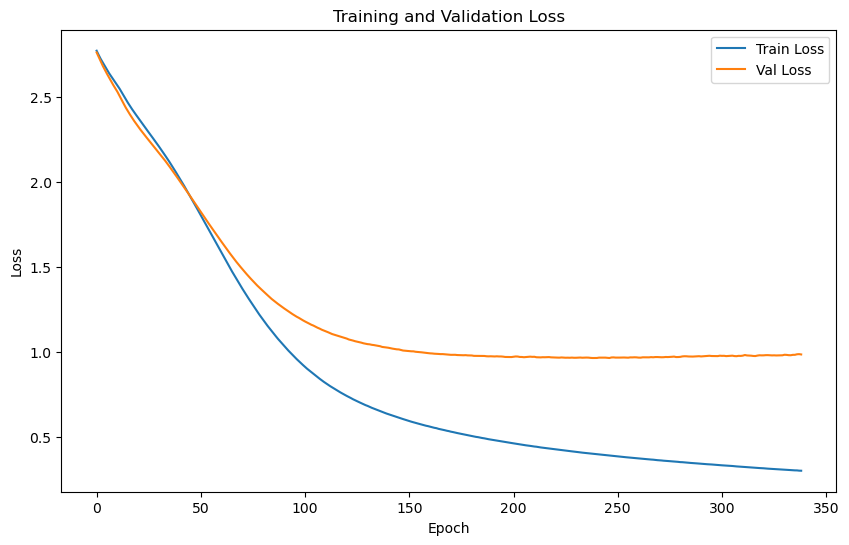

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.6147 | Test Accuracy: 55.32%


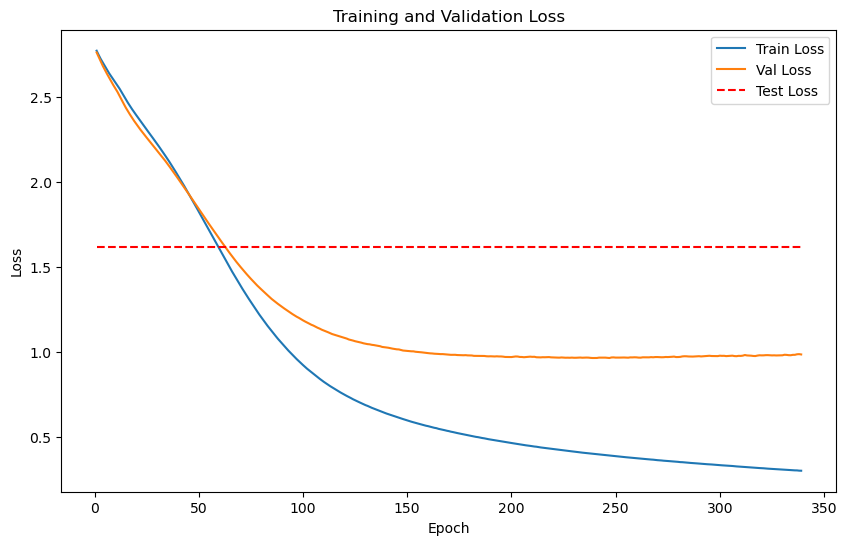

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


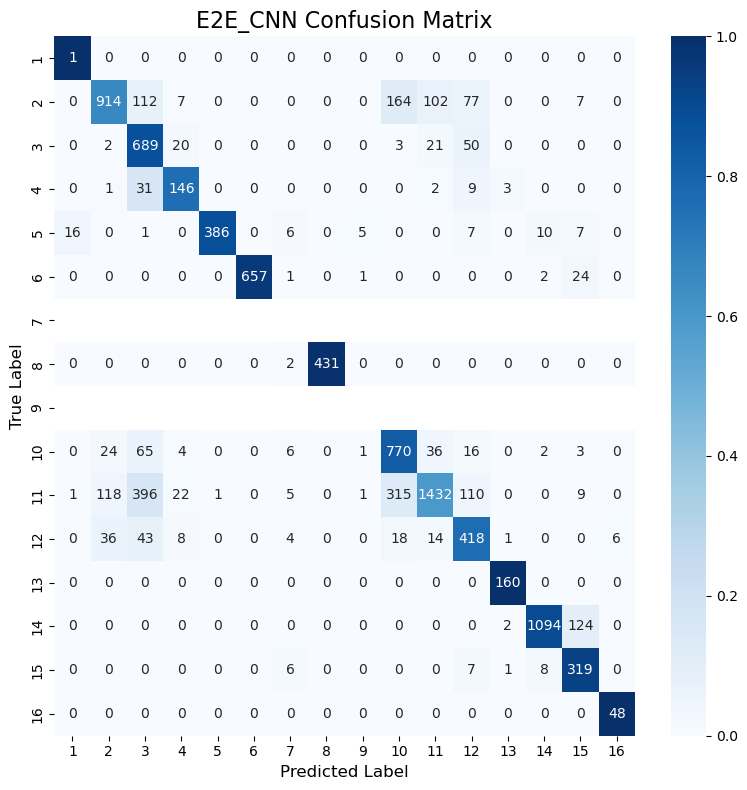

Classification Accuracy: 78.00%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


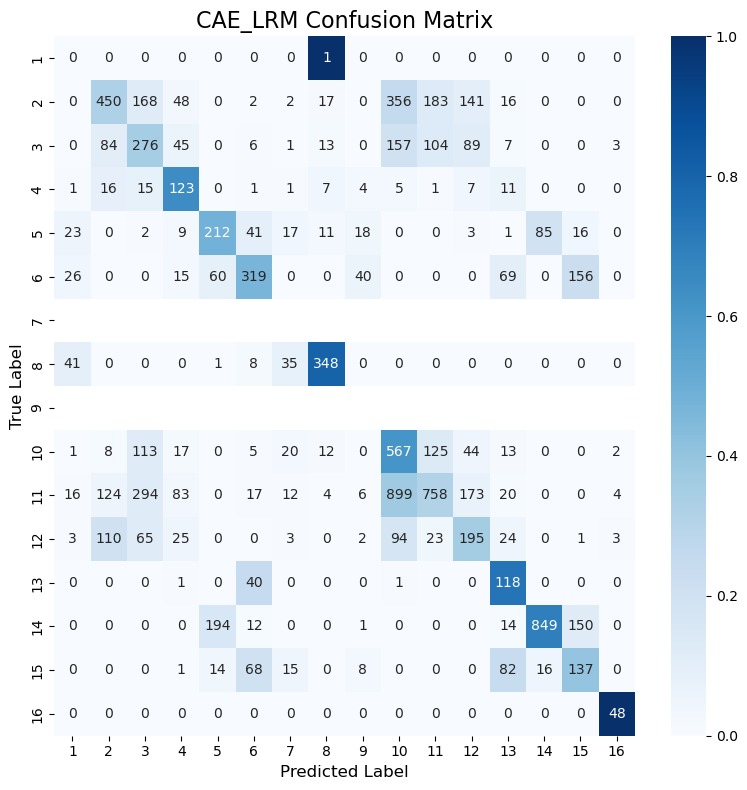

Classification Accuracy: 45.97%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


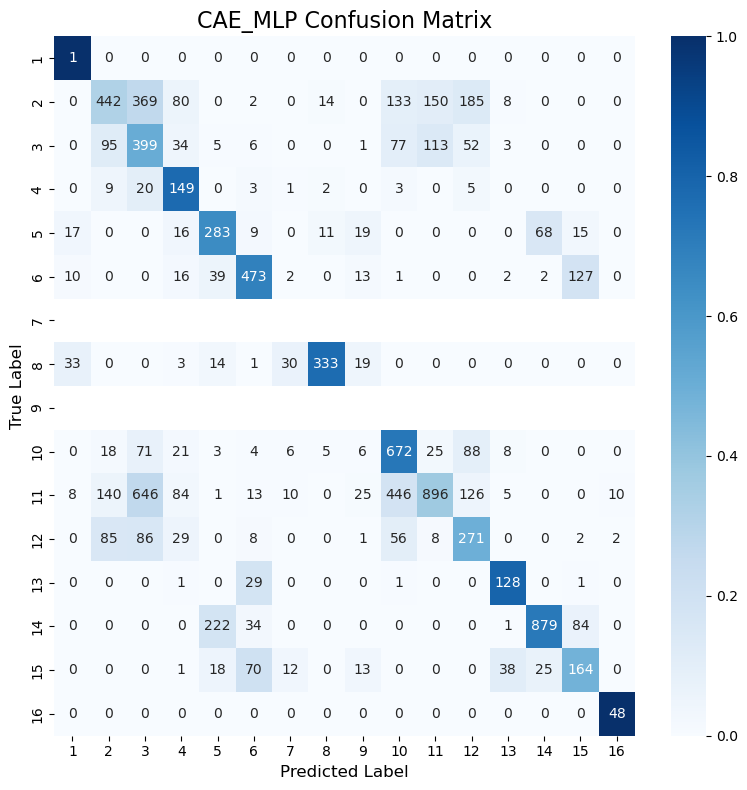

Classification Accuracy: 53.68%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


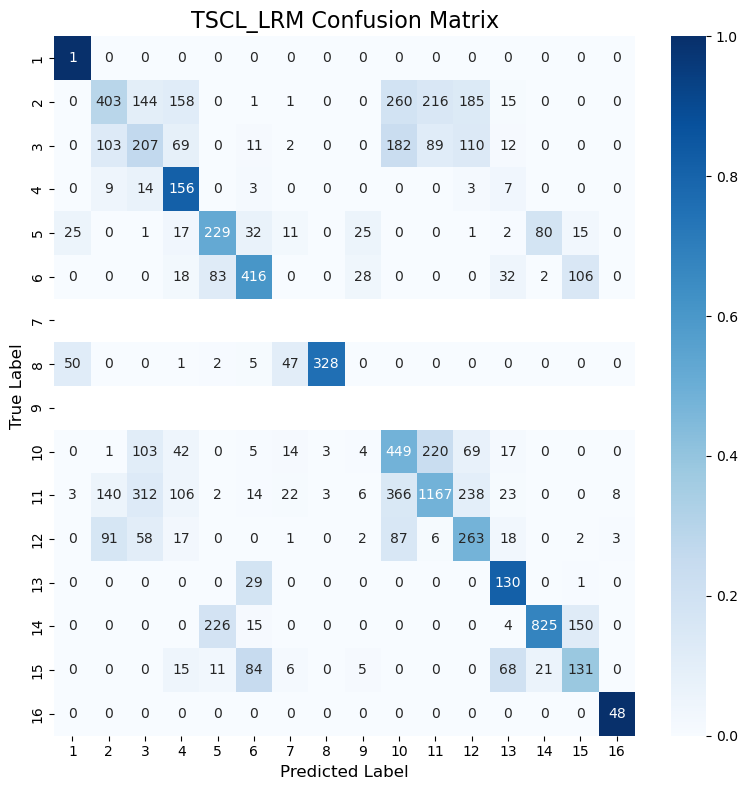

Classification Accuracy: 49.66%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


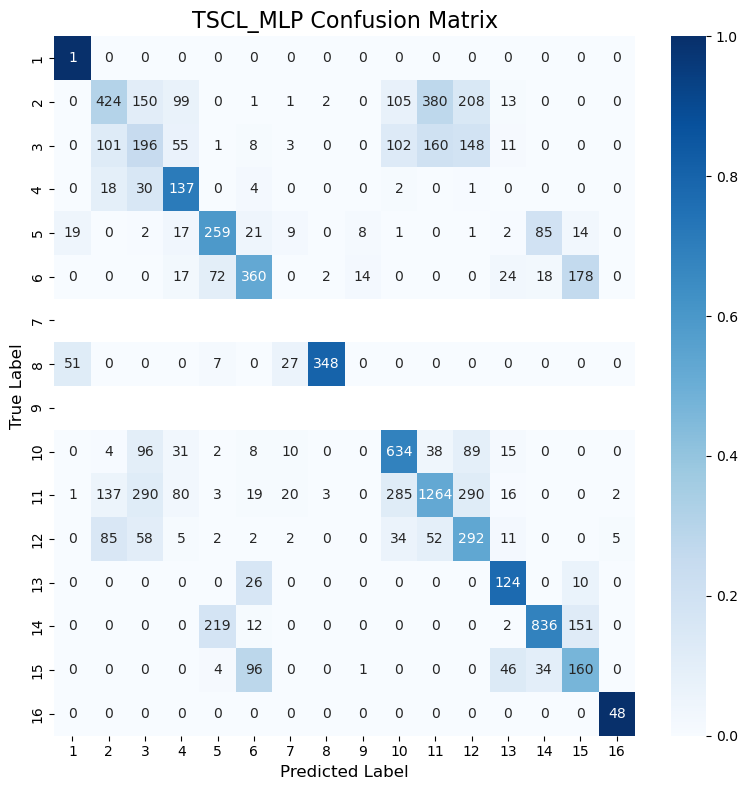

Classification Accuracy: 53.11%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


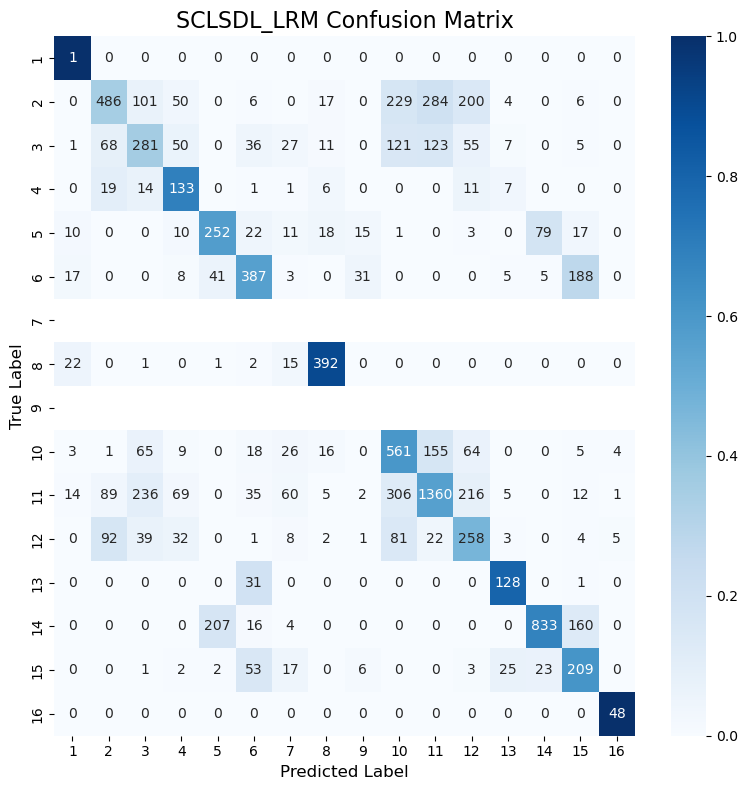

Classification Accuracy: 55.68%


C:\Users\vella\AppData\Local\Temp\ipykernel_22464\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


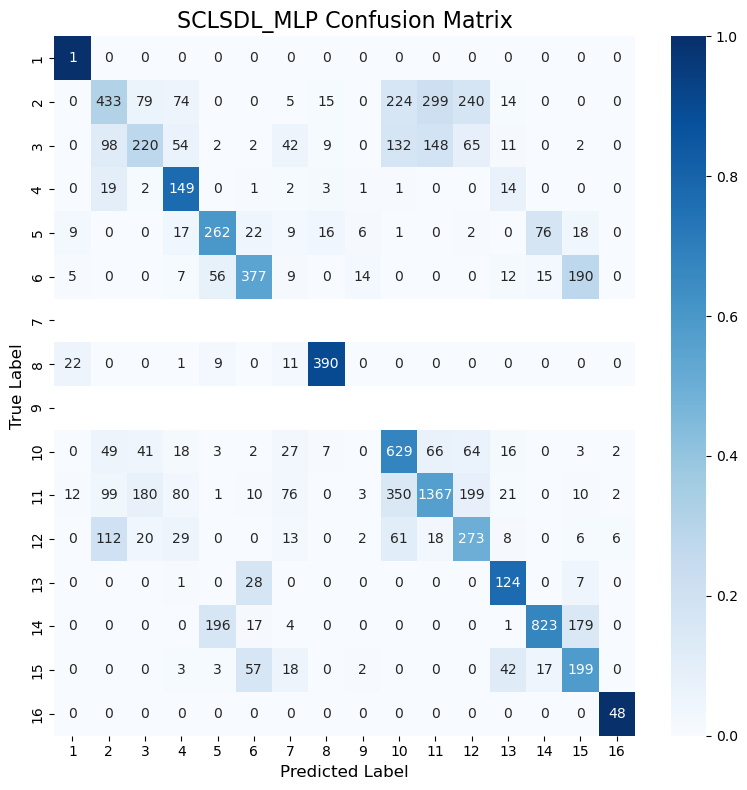

Classification Accuracy: 55.32%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          78.00
1    LRM (CAE)          45.97
2    MLP (CAE)          53.68
3     TSCL LRM          49.66
4     TSCL MLP          53.11
5  SCL_SDL LRM          55.68
6  SCL_SDL MLP          55.32

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          78.00
5  SCL_SDL LRM          55.68
6  SCL_SDL MLP          55.32
2    MLP (CAE)          53.68
4     TSCL MLP          53.11
3     TSCL LRM          49.66
1    LRM (CAE)          45.97
